In [1]:
import pandapower
import pandapower.networks
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation

In [2]:
import pandapower as pp
net = pp.converter.from_mpc('C:/Users/xfang/gitrepos/matpower6.0/case_39.mat', f_hz=60,casename_mpc_file='ans')

In [3]:
import pandas as pd
Load_timeseries =  pd.read_excel(r'C:\Users\xfang\gitrepos\andes\andes\cases\ieee39\load_profile_1.xlsx')

In [4]:
import pandapower.networks as pn
#net =  pn.case39()
load_factor = Load_timeseries.loc[0,'Load']

net.load.p_mw=net.load.p_mw*load_factor
#net.load.p_mw=net.load.p_mw

pp.runopp(net, verbose=True, delta=1e-16)
reference_load = net.res_load.p_mw

gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.46 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    7367.0        -160.0 to 2807.0
Generators        10     On-line Capacity      7367.0        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5894.6            1592.1
Loads             19     Load                  5856.4            1734.5
  Fixed           19       Fixed               5856.4            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.16            974.56
Transformers  

In [5]:
import numpy as np
initial_gen_max = np.zeros(10)
initial_gen_min = np.zeros(10)
for k in range(9):
    initial_gen_max[k]= net.gen.max_p_mw[k]
    initial_gen_min[k]= net.gen.min_p_mw[k]
initial_gen_max[9] = net.ext_grid.max_p_mw[0]
initial_gen_min[9] = net.ext_grid.min_p_mw[0]

In [6]:
import andes
import numpy as np

andes.config_logger(stream_level=20)

In [7]:
print(andes.__version__)

1.5.10.post11.dev0+g1603c094


In [8]:
#ieee39_raw = andes.get_case("ieee39/ieee39.raw")
#ieee39_dyr = andes.get_case("ieee39/IEEE39.dyr")
ieee39 = andes.get_case("ieee39/ieee39.xlsx")
ss = andes.load(ieee39, setup=False, no_output=True)

Working directory: "C:\Users\xfang\OneDrive\Paper during NREL\Close-loop_ACOPF-dynamics"
Loaded config from file "C:\Users\xfang\.andes\andes.rc"
Loaded generated Python code in "C:\Users\xfang\.andes\pycode".
Parsing input file "c:\users\xfang\gitrepos\andes\andes\cases\ieee39\ieee39.xlsx"...
Input file parsed in 0.5797 seconds.


In [9]:
ss.setup()
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

shed_buses = np.array(ss.PQ.bus.v)
pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
new_load = np.zeros(19)

new_gen_setting = np.zeros(10)
pre_gen = np.zeros(10)

for i in range(19):
    new_load[i]=net.res_load.p_mw[i]/100

pq_p_new = new_load
ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)
ss.setup()

gen_buses = np.array(ss.PV.bus.v)
pv_shed_idx = ss.PV.find_idx(keys='bus', values=gen_buses)
new_gen = np.zeros(10)
for i in range(9):
    new_gen[i]=net.res_gen.p_mw[i]/100
pv_p_new = new_gen[0:9]
ss.PV.set(src='p0', idx=pv_shed_idx, attr='v', value=pv_p_new)

slack_gen_buses = np.array(ss.Slack.bus.v)
slack_shed_idx = ss.Slack.find_idx(keys='bus', values=slack_gen_buses)
slack_gen=net.res_ext_grid.p_mw[0]/100
new_gen[9]= slack_gen
ss.Slack.set(src='p0', idx=slack_shed_idx, attr='v', value=slack_gen)

ss.PFlow.run()

for k in range(10):
    pre_gen[k]=new_gen[k]
    new_gen_setting[k] = new_gen[k]

ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0737 seconds.
System has been setup. Calling setup twice is not allowed.
-> System connectivity check results:
  No islanded bus detected.
  A total of 1 island(s) detected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.2882 seconds.
0: |F(x)| = 7.561234472
1: |F(x)| = 2.916445037
2: |F(x)| = 0.1312866396
3: |F(x)| = 0.0003487368406
4: |F(x)| = 4.215676697e-09
Converged in 5 iterations in 0.0169 seconds.


In [10]:
ss.TDS.init()

Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.012  | 0.001
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_8  | 0.029  | 0.006
 GENROU_9  | 0.018  | 0.001
 GENROU_10 | 0.003  | 0.000


Initialization for dynamics completed in 0.8686 seconds.
Initialization was successful.


array([ 1.11400274e-01,  6.84611073e-01,  8.89141368e-01,  7.72927991e-01,
        9.18754354e-01,  7.25188869e-01,  9.40465936e-01,  6.35205773e-01,
        5.98090452e-01, -1.05529111e-01,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.06082398e+00,  1.27164352e+00,  1.01375506e+00,  8.93995044e-01,
        1.15757945e+00,  1.07662215e+00,  8.78254334e-01,  8.46012402e-01,
        1.02566945e+00,  1.02762996e+00,  1.41022852e-01,  5.64712218e-01,
        6.45325075e-01,  6.21355352e-01,  6.75411359e-01,  5.91796299e-01,
        6.94607000e-01,  5.65253974e-01,  4.52317694e-01,  6.03742970e-02,
        1.02688863e+00,  9.92782962e-01,  8.35614649e-01,  8.26691749e-01,
        7.99122492e-01,  9.25764507e-01,  8.01953905e-01,  7.85632120e-01,
        9.40742714e-01,  1.02715454e+00,  2.09678714e-01,  6.57013273e-01,
        7.24981841e-01,  

In [11]:
tg_names = ss.TGOV1N.idx.v
tg_idx = ss.TGOV1N.find_idx(keys='idx', values=tg_names)
new_gen_setting=ss.TurbineGov.get(src='pref0',idx=tg_idx, attr='v')

In [18]:
ss.TurbineGov.get(src='pref0',idx=tg_idx, attr='v')

array([4.28516927, 6.62174647, 7.27406643, 6.52813279, 5.08348356,
       7.13358166, 5.80791231, 3.24585268, 7.73880757, 5.79578546])

In [15]:
pq_p =ss.PQ.p0.v
tg_names = ss.TGOV1N.idx.v
tg_idx = ss.TGOV1N.find_idx(keys='idx', values=tg_names)
#ss.TDS.init()
for i in range(200):
    pq_p_new = pq_p
    ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)
    ss.TurbineGov.set(src='pref0',idx=tg_idx, attr='v', value=new_gen_setting)
    ss.TDS.config.tf = i+1
    ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


 32%|#############4                            | 32/100 [00:00<00:00, 286.49%/s]

Simulation completed in 0.1126 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 387.88%/s]

Simulation completed in 0.2588 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 558.57%/s]

Simulation completed in 0.1810 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 588.05%/s]

Simulation completed in 0.1710 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 611.39%/s]

Simulation completed in 0.1645 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 616.99%/s]

Simulation completed in 0.1630 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 602.17%/s]

Simulation completed in 0.1670 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 620.81%/s]

Simulation completed in 0.1620 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 598.51%/s]

Simulation completed in 0.1680 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 617.00%/s]

Simulation completed in 0.1630 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 605.82%/s]

Simulation completed in 0.1660 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 558.55%/s]

Simulation completed in 0.1800 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 436.88%/s]

Simulation completed in 0.2298 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 529.07%/s]

Simulation completed in 0.1900 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 510.21%/s]

Simulation completed in 0.1969 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 544.93%/s]

Simulation completed in 0.1845 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 518.15%/s]

Simulation completed in 0.1939 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 564.85%/s]

Simulation completed in 0.1780 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 552.41%/s]

Simulation completed in 0.1820 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 563.20%/s]

Simulation completed in 0.1795 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 596.83%/s]

Simulation completed in 0.1685 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 640.60%/s]

Simulation completed in 0.1581 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 620.82%/s]

Simulation completed in 0.1630 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 644.78%/s]

Simulation completed in 0.1560 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 648.93%/s]

Simulation completed in 0.1560 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 604.02%/s]

Simulation completed in 0.1665 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 646.86%/s]

Simulation completed in 0.1565 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 618.94%/s]

Simulation completed in 0.1635 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 630.62%/s]

Simulation completed in 0.1605 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 640.53%/s]

Simulation completed in 0.1571 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 625.50%/s]

Simulation completed in 0.1618 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 634.60%/s]

Simulation completed in 0.1585 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 630.62%/s]

Simulation completed in 0.1595 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 581.24%/s]

Simulation completed in 0.1730 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 549.39%/s]

Simulation completed in 0.1830 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 620.81%/s]

Simulation completed in 0.1630 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 512.85%/s]

Simulation completed in 0.1959 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 581.24%/s]

Simulation completed in 0.1740 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 615.15%/s]

Simulation completed in 0.1645 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 626.69%/s]

Simulation completed in 0.1615 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 602.14%/s]

Simulation completed in 0.1670 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 560.15%/s]

Simulation completed in 0.1795 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 523.56%/s]

Simulation completed in 0.1920 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 607.68%/s]

Simulation completed in 0.1655 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 526.31%/s]

Simulation completed in 0.1909 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 605.81%/s]

Simulation completed in 0.1650 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 598.58%/s]

Simulation completed in 0.1680 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 613.21%/s]

Simulation completed in 0.1640 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 609.50%/s]

Simulation completed in 0.1650 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 571.31%/s]

Simulation completed in 0.1760 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 616.99%/s]

Simulation completed in 0.1640 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 560.16%/s]

Simulation completed in 0.1795 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 561.62%/s]

Simulation completed in 0.1800 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 605.83%/s]

Simulation completed in 0.1660 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 628.61%/s]

Simulation completed in 0.1600 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 602.17%/s]

Simulation completed in 0.1670 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 507.64%/s]

Simulation completed in 0.1989 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 420.37%/s]

Simulation completed in 0.2388 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 474.04%/s]

Simulation completed in 0.2119 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 459.86%/s]

Simulation completed in 0.2194 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 431.10%/s]

Simulation completed in 0.2319 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 492.67%/s]

Simulation completed in 0.2049 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 373.42%/s]

Simulation completed in 0.2687 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 431.24%/s]

Simulation completed in 0.2328 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 491.51%/s]

Simulation completed in 0.2054 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 459.95%/s]

Simulation completed in 0.2194 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 491.51%/s]

Simulation completed in 0.2044 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 433.05%/s]

Simulation completed in 0.2319 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 447.63%/s]

Simulation completed in 0.2243 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 496.37%/s]

Simulation completed in 0.2034 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 466.36%/s]

Simulation completed in 0.2154 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 445.64%/s]

Simulation completed in 0.2263 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 489.11%/s]

Simulation completed in 0.2054 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 484.39%/s]

Simulation completed in 0.2084 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 421.23%/s]

Simulation completed in 0.2393 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 453.70%/s]

Simulation completed in 0.2214 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 469.66%/s]

Simulation completed in 0.2139 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 467.31%/s]

Simulation completed in 0.2159 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 431.19%/s]

Simulation completed in 0.2339 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 432.91%/s]

Simulation completed in 0.2329 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 411.60%/s]

Simulation completed in 0.2439 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 409.85%/s]

Simulation completed in 0.2460 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 454.64%/s]

Simulation completed in 0.2219 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 413.31%/s]

Simulation completed in 0.2439 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 385.99%/s]

Simulation completed in 0.2590 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 420.23%/s]

Simulation completed in 0.2389 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 491.50%/s]

Simulation completed in 0.2054 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 500.73%/s]

Simulation completed in 0.2007 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 479.75%/s]

Simulation completed in 0.2094 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 498.39%/s]

Simulation completed in 0.2021 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 497.60%/s]

Simulation completed in 0.2019 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 476.40%/s]

Simulation completed in 0.2109 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 485.40%/s]

Simulation completed in 0.2080 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 491.39%/s]

Simulation completed in 0.2045 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 474.06%/s]

Simulation completed in 0.2119 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 477.09%/s]

Simulation completed in 0.2115 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 487.80%/s]

Simulation completed in 0.2060 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 440.46%/s]

Simulation completed in 0.2300 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 485.51%/s]

Simulation completed in 0.2069 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 403.29%/s]

Simulation completed in 0.2484 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 510.63%/s]

Simulation completed in 0.1968 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 602.34%/s]

Simulation completed in 0.1680 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 406.60%/s]

Simulation completed in 0.2489 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 485.51%/s]

Simulation completed in 0.2069 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 492.70%/s]

Simulation completed in 0.2039 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 490.17%/s]

Simulation completed in 0.2060 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 492.48%/s]

Simulation completed in 0.2050 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 495.07%/s]

Simulation completed in 0.2029 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 495.05%/s]

Simulation completed in 0.2029 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 465.14%/s]

Simulation completed in 0.2159 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 493.93%/s]

Simulation completed in 0.2034 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 514.19%/s]

Simulation completed in 0.1954 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 502.56%/s]

Simulation completed in 0.2009 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 469.18%/s]

Simulation completed in 0.2141 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 502.96%/s]

Simulation completed in 0.1998 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 501.34%/s]

Simulation completed in 0.1994 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 476.60%/s]

Simulation completed in 0.2117 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 451.39%/s]

Simulation completed in 0.2230 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 447.65%/s]

Simulation completed in 0.2243 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 477.70%/s]

Simulation completed in 0.2143 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 483.11%/s]

Simulation completed in 0.2089 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 504.98%/s]

Simulation completed in 0.1990 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 490.28%/s]

Simulation completed in 0.2050 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 469.39%/s]

Simulation completed in 0.2140 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 510.40%/s]

Simulation completed in 0.1979 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 493.78%/s]

Simulation completed in 0.2035 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 487.83%/s]

Simulation completed in 0.2070 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 500.19%/s]

Simulation completed in 0.2019 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 480.77%/s]

Simulation completed in 0.2099 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 506.40%/s]

Simulation completed in 0.1984 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 491.51%/s]

Simulation completed in 0.2034 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 506.40%/s]

Simulation completed in 0.1984 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 508.97%/s]

Simulation completed in 0.1984 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 500.45%/s]

Simulation completed in 0.2018 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 512.93%/s]

Simulation completed in 0.1959 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 506.19%/s]

Simulation completed in 0.1985 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 498.84%/s]

Simulation completed in 0.2014 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 502.91%/s]

Simulation completed in 0.1998 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 511.04%/s]

Simulation completed in 0.1976 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 485.42%/s]

Simulation completed in 0.2070 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 485.32%/s]

Simulation completed in 0.2070 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 492.54%/s]

Simulation completed in 0.2040 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 495.82%/s]

Simulation completed in 0.2026 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 497.57%/s]

Simulation completed in 0.2024 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 489.11%/s]

Simulation completed in 0.2064 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 488.17%/s]

Simulation completed in 0.2068 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 510.17%/s]

Simulation completed in 0.1975 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 487.76%/s]

Simulation completed in 0.2060 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 501.19%/s]

Simulation completed in 0.2015 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 515.69%/s]

Simulation completed in 0.1959 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 493.85%/s]

Simulation completed in 0.2034 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 503.86%/s]

Simulation completed in 0.2004 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 506.40%/s]

Simulation completed in 0.1984 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 479.75%/s]

Simulation completed in 0.2094 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 497.55%/s]

Simulation completed in 0.2009 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 516.87%/s]

Simulation completed in 0.1954 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 490.25%/s]

Simulation completed in 0.2049 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 486.73%/s]

Simulation completed in 0.2064 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 461.35%/s]

Simulation completed in 0.2177 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 441.71%/s]

Simulation completed in 0.2273 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 482.06%/s]

Simulation completed in 0.2094 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 477.33%/s]

Simulation completed in 0.2110 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 471.76%/s]

Simulation completed in 0.2130 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 494.87%/s]

Simulation completed in 0.2030 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 496.37%/s]

Simulation completed in 0.2024 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 482.06%/s]

Simulation completed in 0.2084 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 477.46%/s]

Simulation completed in 0.2104 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 502.60%/s]

Simulation completed in 0.1999 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 501.34%/s]

Simulation completed in 0.2014 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 482.06%/s]

Simulation completed in 0.2094 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 493.93%/s]

Simulation completed in 0.2034 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 501.34%/s]

Simulation completed in 0.2014 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 482.06%/s]

Simulation completed in 0.2094 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 501.34%/s]

Simulation completed in 0.2004 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 516.84%/s]

Simulation completed in 0.1954 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 496.37%/s]

Simulation completed in 0.2034 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 496.37%/s]

Simulation completed in 0.2024 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 498.85%/s]

Simulation completed in 0.2024 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 488.39%/s]

Simulation completed in 0.2057 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 503.21%/s]

Simulation completed in 0.2002 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 498.84%/s]

Simulation completed in 0.2024 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 479.75%/s]

Simulation completed in 0.2094 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 501.34%/s]

Simulation completed in 0.2004 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 448.55%/s]

Simulation completed in 0.2239 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 474.04%/s]

Simulation completed in 0.2129 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 482.06%/s]

Simulation completed in 0.2084 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 428.50%/s]

Simulation completed in 0.2343 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 384.89%/s]

Simulation completed in 0.2618 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 470.70%/s]

Simulation completed in 0.2134 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 459.95%/s]

Simulation completed in 0.2194 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 462.01%/s]

Simulation completed in 0.2174 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 471.82%/s]

Simulation completed in 0.2129 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 455.76%/s]

Simulation completed in 0.2214 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 428.45%/s]

Simulation completed in 0.2353 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 328.14%/s]

Simulation completed in 0.3057 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 449.63%/s]

Simulation completed in 0.2234 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 522.22%/s]

Simulation completed in 0.1924 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 389.37%/s]

Simulation completed in 0.2578 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 475.20%/s]

Simulation completed in 0.2124 seconds.



100%|#######################################| 100.0/100 [00:00<00:00, 466.36%/s]

Simulation completed in 0.2164 seconds.


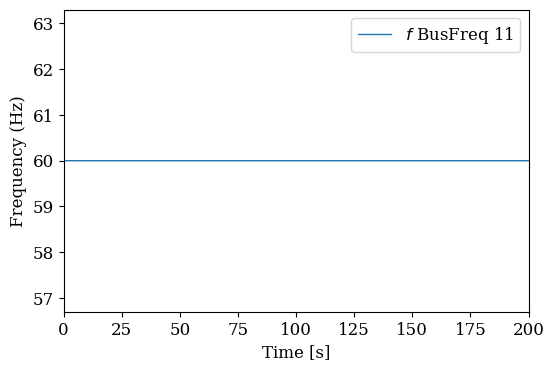

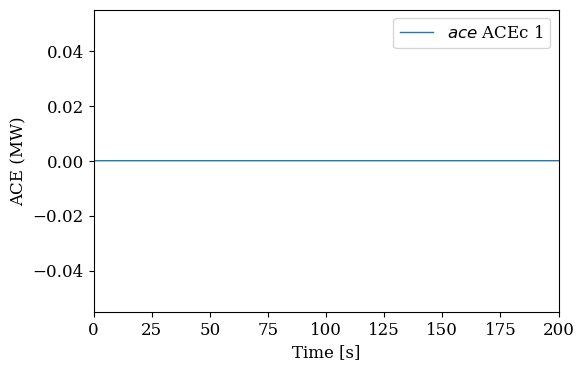

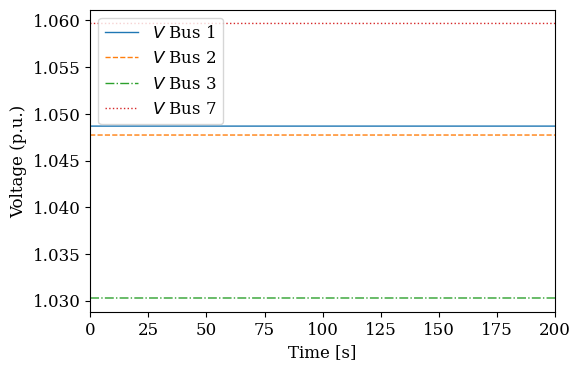

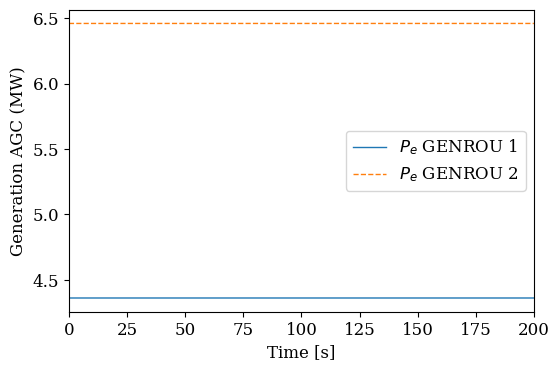

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [16]:
ss.TDS.load_plotter()
ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.GENROU.Pe, a=(0,1),ylabel='Generation AGC (MW)')

In [12]:
ss.GENROU.Pe.v

array([4.36086385, 6.45999998, 7.24999998, 6.51999998, 5.07999998,
       6.86999998, 5.79999998, 3.21521338, 7.64783381, 5.73110425])

In [12]:
Ppf = np.array(ss.PQ.Ppf.v)
shed_buses = np.array(ss.PQ.bus.v)
pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
pq_p =ss.PQ.p0.v
#pq_p = ss.PQ.get(src='Ppf', idx=pq_shed_idx, attr='v')

#set new generation set point
tg_names = ss.TGOV1N.idx.v
tg_idx = ss.TGOV1N.find_idx(keys='idx', values=tg_names)
tg_idx1 = ss.TGOV1N.find_idx(keys='idx', values=tg_names)[0:10]

AGC_response1 = np.zeros(9)
ACE_integral = 0
ACE_raw = 0
KI = 0.1
KP = 0.1

ed_interval= 300 #perform ACOPF dispatch every 5 minutes

Dynamic_power = np.zeros(10)

#perform 1-hour time domain simulation
for i in range(3600):
    print(i)  
    #perform ACOPF dispatch every 5 minutes
    if i>0 and i%ed_interval==0:
        
        for k in range(10):
            pre_gen[k]=new_gen[k]
            
            
        # obtain the initial power point from dynamic simulation 
        for m in range(9):
            net.gen.max_p_mw[m] = min(initial_gen_max[m],ss.GENROU.Pe.v[m]*100 + 100)
            net.gen.min_p_mw[m] = max(initial_gen_min[m],ss.GENROU.Pe.v[m]*100 - 100)
        net.ext_grid.max_p_mw[0] = min(initial_gen_max[9],ss.GENROU.Pe.v[9]*100 + 100)
        net.ext_grid.min_p_mw[0] = max(initial_gen_min[9],ss.GENROU.Pe.v[9]*100 - 100)        
            
        load_factor = np.average(Load_timeseries.loc[i:i+ed_interval,'Load'])
        net.load.p_mw=reference_load*load_factor
        pp.runopp(net, verbose=True, delta=1e-10)
               
        #after ACOPF, update generation reference points
        for k in range(0,9):
            new_gen[k]=(net.res_gen.p_mw[k])/100
        new_gen[9]=(net.res_ext_grid.p_mw[0])/100
        #new_gen[0]=0
        
       #set the new reference points    
    for k in range(0,10):
        new_gen_setting[k] = new_gen_setting[k] + (new_gen[k]-pre_gen[k])*(2/ed_interval)
    #new_gen_setting[0] = 0   
    
        #trip Gen1 in scheduling
    #if i>12 :
    #    net.gen.max_p_mw[0]=0
    #    net.gen.max_q_mvar[0]=0
    #    net.gen.min_q_mvar[0]=0
                   
    ACE_integral = ACE_integral + ss.ACEc.ace.v
    ACE_raw = -(KP*ss.ACEc.ace.v + KI*ACE_integral)
               
    AGC_response = ACE_raw*(1/10)*np.ones(10)    
     
    #AGC model    
    if i%4==0:  
        # Pref setting points update from ACOPF
        ss.TurbineGov.set(src='pref0',idx=tg_idx, attr='v', value=new_gen_setting)
        # SFR setting points update from AGC
        ss.TurbineGov.set(src='paux0',idx=tg_idx1, attr='v', value=AGC_response) 
    
    pq_p_new = pq_p*Load_timeseries.loc[i,'Load']
    #pq_p_new = pq_p
    ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)
    ss.TDS.config.tf = float(i) +1
    ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1.0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


0
 32%|#############4                            | 32/100 [00:00<00:00, 356.51%/s]

Simulation completed in 0.0907 seconds.



1
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



2
100%|#######################################| 100.0/100 [00:00<00:00, 453.70%/s]

Simulation completed in 0.2214 seconds.



3
100%|#######################################| 100.0/100 [00:00<00:00, 479.75%/s]

Simulation completed in 0.2094 seconds.



4
100%|#######################################| 100.0/100 [00:00<00:00, 536.19%/s]

Simulation completed in 0.1874 seconds.



5
100%|#######################################| 100.0/100 [00:00<00:00, 449.63%/s]

Simulation completed in 0.2243 seconds.



6
100%|#######################################| 100.0/100 [00:00<00:00, 409.26%/s]

Simulation completed in 0.2453 seconds.



7
100%|#######################################| 100.0/100 [00:00<00:00, 447.62%/s]

Simulation completed in 0.2244 seconds.



8
100%|#######################################| 100.0/100 [00:00<00:00, 443.66%/s]

Simulation completed in 0.2263 seconds.



9
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2583 seconds.



10
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3071 seconds.



11
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



12
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



13
100%|#######################################| 100.0/100 [00:00<00:00, 464.20%/s]

Simulation completed in 0.2164 seconds.



14
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



15
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



16
100%|#######################################| 100.0/100 [00:00<00:00, 472.96%/s]

Simulation completed in 0.2134 seconds.



17
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



18
100%|#######################################| 100.0/100 [00:00<00:00, 449.63%/s]

Simulation completed in 0.2234 seconds.



19
100%|#######################################| 100.0/100 [00:00<00:00, 472.89%/s]

Simulation completed in 0.2114 seconds.



20
100%|#######################################| 100.0/100 [00:00<00:00, 447.62%/s]

Simulation completed in 0.2243 seconds.



21
100%|#######################################| 100.0/100 [00:00<00:00, 477.46%/s]

Simulation completed in 0.2104 seconds.



22
100%|#######################################| 100.0/100 [00:00<00:00, 466.36%/s]

Simulation completed in 0.2154 seconds.



23
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2463 seconds.



24
100%|#######################################| 100.0/100 [00:00<00:00, 459.94%/s]

Simulation completed in 0.2184 seconds.



25
100%|#######################################| 100.0/100 [00:00<00:00, 379.75%/s]

Simulation completed in 0.2643 seconds.



26
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



27
100%|#######################################| 100.0/100 [00:00<00:00, 417.78%/s]

Simulation completed in 0.2413 seconds.



28
100%|#######################################| 100.0/100 [00:00<00:00, 455.76%/s]

Simulation completed in 0.2204 seconds.



29
100%|#######################################| 100.0/100 [00:00<00:00, 408.36%/s]

Simulation completed in 0.2458 seconds.



30
100%|#######################################| 100.0/100 [00:00<00:00, 430.33%/s]

Simulation completed in 0.2343 seconds.



31
100%|#######################################| 100.0/100 [00:00<00:00, 466.28%/s]

Simulation completed in 0.2164 seconds.



32
100%|#######################################| 100.0/100 [00:00<00:00, 443.66%/s]

Simulation completed in 0.2273 seconds.



33
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2936 seconds.



34
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2523 seconds.



35
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2872 seconds.



36
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



37
100%|#######################################| 100.0/100 [00:00<00:00, 437.85%/s]

Simulation completed in 0.2293 seconds.



38
100%|#######################################| 100.0/100 [00:00<00:00, 455.76%/s]

Simulation completed in 0.2204 seconds.



39
100%|#######################################| 100.0/100 [00:00<00:00, 447.63%/s]

Simulation completed in 0.2253 seconds.



40
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2443 seconds.



41
100%|#######################################| 100.0/100 [00:00<00:00, 445.64%/s]

Simulation completed in 0.2253 seconds.



42
100%|#######################################| 100.0/100 [00:00<00:00, 445.63%/s]

Simulation completed in 0.2253 seconds.



43
100%|#######################################| 100.0/100 [00:00<00:00, 441.71%/s]

Simulation completed in 0.2283 seconds.



44
100%|#######################################| 100.0/100 [00:00<00:00, 435.95%/s]

Simulation completed in 0.2303 seconds.



45
100%|#######################################| 100.0/100 [00:00<00:00, 447.62%/s]

Simulation completed in 0.2253 seconds.



46
100%|#######################################| 100.0/100 [00:00<00:00, 441.71%/s]

Simulation completed in 0.2273 seconds.



47
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



48
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



49
100%|#######################################| 100.0/100 [00:00<00:00, 409.26%/s]

Simulation completed in 0.2453 seconds.



50
100%|#######################################| 100.0/100 [00:00<00:00, 432.19%/s]

Simulation completed in 0.2323 seconds.



51
100%|#######################################| 100.0/100 [00:00<00:00, 424.86%/s]

Simulation completed in 0.2363 seconds.



52
100%|#######################################| 100.0/100 [00:00<00:00, 423.07%/s]

Simulation completed in 0.2373 seconds.



53
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3081 seconds.



54
100%|#######################################| 100.0/100 [00:00<00:00, 348.16%/s]

Simulation completed in 0.2882 seconds.



55
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



56
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



57
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



58
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2772 seconds.



59
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



60
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3620 seconds.



61
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



62
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



63
100%|#######################################| 100.0/100 [00:00<00:00, 361.97%/s]

Simulation completed in 0.2772 seconds.



64
100%|#######################################| 100.0/100 [00:00<00:00, 359.32%/s]

Simulation completed in 0.2802 seconds.



65
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



66
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



67
100%|#######################################| 100.0/100 [00:00<00:00, 342.18%/s]

Simulation completed in 0.2942 seconds.



68
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3450 seconds.



69
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



70
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3241 seconds.



71
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



72
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



73
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2972 seconds.



74
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



75
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



76
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



77
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



78
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



79
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



80
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



81
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



82
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



83
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



84
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



85
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



86
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



87
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



88
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



89
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



90
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



91
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3540 seconds.



92
100%|#######################################| 100.0/100 [00:00<00:00, 272.69%/s]

Simulation completed in 0.3687 seconds.



93
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



94
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



95
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3540 seconds.



96
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



97
100%|#######################################| 100.0/100 [00:00<00:00, 258.42%/s]

Simulation completed in 0.3879 seconds.



98
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



99
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3530 seconds.



100
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



101
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2792 seconds.



102
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



103
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



104
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3650 seconds.



105
100%|#######################################| 100.0/100 [00:00<00:00, 263.17%/s]

Simulation completed in 0.3809 seconds.



106
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



107
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



108
100%|#######################################| 100.0/100 [00:00<00:00, 270.99%/s]

Simulation completed in 0.3710 seconds.



109
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3620 seconds.



110
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2962 seconds.



111
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2872 seconds.



112
100%|#######################################| 100.0/100 [00:00<00:00, 311.84%/s]

Simulation completed in 0.3226 seconds.



113
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



114
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



115
100%|#######################################| 100.0/100 [00:00<00:00, 273.95%/s]

Simulation completed in 0.3660 seconds.



116
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3450 seconds.



117
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3261 seconds.



118
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



119
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



120
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



121
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3121 seconds.



122
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



123
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



124
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



125
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



126
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



127
100%|#######################################| 100.0/100 [00:00<00:00, 277.36%/s]

Simulation completed in 0.3625 seconds.



128
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



129
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3450 seconds.



130
100%|#######################################| 100.0/100 [00:00<00:00, 315.79%/s]

Simulation completed in 0.3186 seconds.



131
100%|#######################################| 100.0/100 [00:00<00:00, 298.42%/s]

Simulation completed in 0.3370 seconds.



132
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



133
100%|#######################################| 100.0/100 [00:00<00:00, 265.96%/s]

Simulation completed in 0.3769 seconds.



134
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



135
100%|#######################################| 100.0/100 [00:00<00:00, 259.09%/s]

Simulation completed in 0.3869 seconds.



136
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3530 seconds.



137
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



138
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



139
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3580 seconds.



140
100%|#######################################| 100.0/100 [00:00<00:00, 251.61%/s]

Simulation completed in 0.3984 seconds.



141
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3610 seconds.



142
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



143
100%|#######################################| 100.0/100 [00:00<00:00, 353.63%/s]

Simulation completed in 0.2837 seconds.



144
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3660 seconds.



145
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3460 seconds.



146
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3201 seconds.



147
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



148
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



149
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



150
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2982 seconds.



151
100%|#######################################| 100.0/100 [00:00<00:00, 360.62%/s]

Simulation completed in 0.2782 seconds.



152
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



153
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



154
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



155
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



156
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



157
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3680 seconds.



158
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3361 seconds.



159
100%|#######################################| 100.0/100 [00:00<00:00, 363.91%/s]

Simulation completed in 0.2757 seconds.



160
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



161
100%|#######################################| 100.0/100 [00:00<00:00, 374.82%/s]

Simulation completed in 0.2687 seconds.



162
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3081 seconds.



163
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2982 seconds.



164
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3710 seconds.



165
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



166
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



167
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2872 seconds.



168
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3341 seconds.



169
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



170
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



171
100%|#######################################| 100.0/100 [00:00<00:00, 358.72%/s]

Simulation completed in 0.2807 seconds.



172
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



173
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2962 seconds.



174
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3600 seconds.



175
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3630 seconds.



176
100%|#######################################| 100.0/100 [00:00<00:00, 339.87%/s]

Simulation completed in 0.2962 seconds.



177
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3470 seconds.



178
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3520 seconds.



179
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



180
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



181
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



182
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



183
100%|#######################################| 100.0/100 [00:00<00:00, 258.42%/s]

Simulation completed in 0.3879 seconds.



184
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3361 seconds.



185
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



186
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3680 seconds.



187
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



188
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



189
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2852 seconds.



190
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



191
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



192
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



193
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



194
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



195
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



196
100%|#######################################| 100.0/100 [00:00<00:00, 283.22%/s]

Simulation completed in 0.3540 seconds.



197
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



198
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2952 seconds.



199
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



200
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3600 seconds.



201
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



202
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



203
100%|#######################################| 100.0/100 [00:00<00:00, 363.26%/s]

Simulation completed in 0.2762 seconds.



204
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



205
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2782 seconds.



206
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



207
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



208
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3351 seconds.



209
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



210
100%|#######################################| 100.0/100 [00:00<00:00, 363.94%/s]

Simulation completed in 0.2757 seconds.



211
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



212
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2752 seconds.



213
100%|#######################################| 100.0/100 [00:00<00:00, 322.38%/s]

Simulation completed in 0.3121 seconds.



214
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



215
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



216
100%|#######################################| 100.0/100 [00:00<00:00, 291.47%/s]

Simulation completed in 0.3450 seconds.



217
100%|#######################################| 100.0/100 [00:00<00:00, 332.01%/s]

Simulation completed in 0.3021 seconds.



218
100%|#######################################| 100.0/100 [00:00<00:00, 330.36%/s]

Simulation completed in 0.3046 seconds.



219
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



220
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



221
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



222
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



223
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3650 seconds.



224
100%|#######################################| 100.0/100 [00:00<00:00, 298.42%/s]

Simulation completed in 0.3360 seconds.



225
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3690 seconds.



226
100%|#######################################| 100.0/100 [00:00<00:00, 273.96%/s]

Simulation completed in 0.3660 seconds.



227
100%|#######################################| 100.0/100 [00:00<00:00, 270.97%/s]

Simulation completed in 0.3710 seconds.



228
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2992 seconds.



229
100%|#######################################| 100.0/100 [00:00<00:00, 348.10%/s]

Simulation completed in 0.2882 seconds.



230
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3739 seconds.



231
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3400 seconds.



232
100%|#######################################| 100.0/100 [00:00<00:00, 292.35%/s]

Simulation completed in 0.3430 seconds.



233
100%|#######################################| 100.0/100 [00:00<00:00, 359.42%/s]

Simulation completed in 0.2802 seconds.



234
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3710 seconds.



235
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3061 seconds.



236
100%|#######################################| 100.0/100 [00:00<00:00, 271.75%/s]

Simulation completed in 0.3689 seconds.



237
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



238
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3041 seconds.



239
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2991 seconds.



240
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2872 seconds.



241
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2842 seconds.



242
100%|#######################################| 100.0/100 [00:00<00:00, 340.92%/s]

Simulation completed in 0.2953 seconds.



243
100%|#######################################| 100.0/100 [00:00<00:00, 346.94%/s]

Simulation completed in 0.2902 seconds.



244
100%|#######################################| 100.0/100 [00:00<00:00, 274.64%/s]

Simulation completed in 0.3651 seconds.



245
100%|#######################################| 100.0/100 [00:00<00:00, 276.25%/s]

Simulation completed in 0.3639 seconds.



246
100%|#######################################| 100.0/100 [00:00<00:00, 280.10%/s]

Simulation completed in 0.3580 seconds.



247
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3630 seconds.



248
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3221 seconds.



249
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



250
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



251
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2842 seconds.



252
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



253
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



254
100%|#######################################| 100.0/100 [00:00<00:00, 333.12%/s]

Simulation completed in 0.3011 seconds.



255
100%|#######################################| 100.0/100 [00:00<00:00, 346.94%/s]

Simulation completed in 0.2902 seconds.



256
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



257
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



258
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



259
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



260
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



261
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



262
100%|#######################################| 100.0/100 [00:00<00:00, 323.45%/s]

Simulation completed in 0.3111 seconds.



263
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2972 seconds.



264
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



265
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



266
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



267
100%|#######################################| 100.0/100 [00:00<00:00, 300.17%/s]

Simulation completed in 0.3351 seconds.



268
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3291 seconds.



269
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3341 seconds.



270
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



271
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2952 seconds.



272
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2912 seconds.



273
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



274
100%|#######################################| 100.0/100 [00:00<00:00, 329.28%/s]

Simulation completed in 0.3036 seconds.



275
100%|#######################################| 100.0/100 [00:00<00:00, 293.22%/s]

Simulation completed in 0.3420 seconds.



276
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



277
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2692 seconds.



278
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



279
100%|#######################################| 100.0/100 [00:00<00:00, 354.34%/s]

Simulation completed in 0.2832 seconds.



280
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



281
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



282
100%|#######################################| 100.0/100 [00:00<00:00, 356.87%/s]

Simulation completed in 0.2822 seconds.



283
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2792 seconds.



284
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



285
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2981 seconds.



286
100%|#######################################| 100.0/100 [00:00<00:00, 367.33%/s]

Simulation completed in 0.2742 seconds.



287
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



288
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



289
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



290
100%|#######################################| 100.0/100 [00:00<00:00, 282.47%/s]

Simulation completed in 0.3560 seconds.



291
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3739 seconds.



292
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



293
100%|#######################################| 100.0/100 [00:00<00:00, 284.88%/s]

Simulation completed in 0.3530 seconds.



294
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



295
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3480 seconds.



296
100%|#######################################| 100.0/100 [00:00<00:00, 342.19%/s]

Simulation completed in 0.2942 seconds.



297
100%|#######################################| 100.0/100 [00:00<00:00, 313.34%/s]

Simulation completed in 0.3201 seconds.



298
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



299
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3101 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


300
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.62 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6340.9        -160.0 to 2807.0
Generators        10     On-line Capacity      6340.9        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5890.5            1590.9
Loads             19     Load                  5852.4            1734.5
  Fixed           19       Fixed               5852.4            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.05            973.41
Transforme

100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



301
100%|#######################################| 100.0/100 [00:00<00:00, 263.16%/s]

Simulation completed in 0.3810 seconds.



302
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3829 seconds.



303
100%|#######################################| 100.0/100 [00:00<00:00, 255.81%/s]

Simulation completed in 0.3929 seconds.



304
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



305
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



306
100%|#######################################| 100.0/100 [00:00<00:00, 372.04%/s]

Simulation completed in 0.2707 seconds.



307
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



308
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



309
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



310
100%|#######################################| 100.0/100 [00:00<00:00, 283.23%/s]

Simulation completed in 0.3540 seconds.



311
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.



312
100%|#######################################| 100.0/100 [00:00<00:00, 255.78%/s]

Simulation completed in 0.3929 seconds.



313
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3101 seconds.



314
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3001 seconds.



315
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3759 seconds.



316
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2872 seconds.



317
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2972 seconds.



318
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3031 seconds.



319
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



320
100%|#######################################| 100.0/100 [00:00<00:00, 244.56%/s]

Simulation completed in 0.4099 seconds.



321
100%|#######################################| 100.0/100 [00:00<00:00, 250.04%/s]

Simulation completed in 0.4019 seconds.



322
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3161 seconds.



323
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



324
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3291 seconds.



325
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3091 seconds.



326
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



327
100%|#######################################| 100.0/100 [00:00<00:00, 331.97%/s]

Simulation completed in 0.3022 seconds.



328
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3450 seconds.



329
100%|#######################################| 100.0/100 [00:00<00:00, 363.32%/s]

Simulation completed in 0.2772 seconds.



330
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3371 seconds.



331
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



332
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3191 seconds.



333
100%|#######################################| 100.0/100 [00:00<00:00, 302.93%/s]

Simulation completed in 0.3311 seconds.



334
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3011 seconds.



335
100%|#######################################| 100.0/100 [00:00<00:00, 242.19%/s]

Simulation completed in 0.4148 seconds.



336
100%|#######################################| 100.0/100 [00:00<00:00, 351.86%/s]

Simulation completed in 0.2862 seconds.



337
100%|#######################################| 100.0/100 [00:00<00:00, 350.53%/s]

Simulation completed in 0.2862 seconds.



338
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3420 seconds.



339
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3231 seconds.



340
100%|#######################################| 100.0/100 [00:00<00:00, 313.34%/s]

Simulation completed in 0.3201 seconds.



341
100%|#######################################| 100.0/100 [00:00<00:00, 379.04%/s]

Simulation completed in 0.2648 seconds.



342
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



343
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



344
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



345
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



346
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



347
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



348
100%|#######################################| 100.0/100 [00:00<00:00, 364.66%/s]

Simulation completed in 0.2762 seconds.



349
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2792 seconds.



350
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



351
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



352
100%|#######################################| 100.0/100 [00:00<00:00, 304.77%/s]

Simulation completed in 0.3291 seconds.



353
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



354
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



355
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



356
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3720 seconds.



357
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



358
100%|#######################################| 100.0/100 [00:00<00:00, 263.86%/s]

Simulation completed in 0.3809 seconds.



359
100%|#######################################| 100.0/100 [00:00<00:00, 279.29%/s]

Simulation completed in 0.3600 seconds.



360
100%|#######################################| 100.0/100 [00:00<00:00, 349.37%/s]

Simulation completed in 0.2872 seconds.



361
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



362
100%|#######################################| 100.0/100 [00:00<00:00, 292.32%/s]

Simulation completed in 0.3440 seconds.



363
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



364
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3769 seconds.



365
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



366
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



367
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2662 seconds.



368
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



369
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



370
100%|#######################################| 100.0/100 [00:00<00:00, 286.49%/s]

Simulation completed in 0.3510 seconds.



371
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



372
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



373
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2982 seconds.



374
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



375
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2593 seconds.



376
100%|#######################################| 100.0/100 [00:00<00:00, 322.41%/s]

Simulation completed in 0.3121 seconds.



377
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3600 seconds.



378
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



379
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



380
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



381
100%|#######################################| 100.0/100 [00:00<00:00, 308.51%/s]

Simulation completed in 0.3261 seconds.



382
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



383
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



384
100%|#######################################| 100.0/100 [00:00<00:00, 350.63%/s]

Simulation completed in 0.2871 seconds.



385
100%|#######################################| 100.0/100 [00:00<00:00, 346.94%/s]

Simulation completed in 0.2892 seconds.



386
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



387
100%|#######################################| 100.0/100 [00:00<00:00, 371.37%/s]

Simulation completed in 0.2702 seconds.



388
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3241 seconds.



389
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2782 seconds.



390
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



391
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



392
100%|#######################################| 100.0/100 [00:00<00:00, 274.68%/s]

Simulation completed in 0.3650 seconds.



393
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2872 seconds.



394
100%|#######################################| 100.0/100 [00:00<00:00, 268.46%/s]

Simulation completed in 0.3744 seconds.



395
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



396
100%|#######################################| 100.0/100 [00:00<00:00, 333.12%/s]

Simulation completed in 0.3011 seconds.



397
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2792 seconds.



398
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



399
100%|#######################################| 100.0/100 [00:00<00:00, 254.49%/s]

Simulation completed in 0.3949 seconds.



400
100%|#######################################| 100.0/100 [00:00<00:00, 251.30%/s]

Simulation completed in 0.3999 seconds.



401
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3191 seconds.



402
100%|#######################################| 100.0/100 [00:00<00:00, 275.08%/s]

Simulation completed in 0.3655 seconds.



403
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



404
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



405
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



406
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3480 seconds.



407
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



408
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



409
100%|#######################################| 100.0/100 [00:00<00:00, 267.01%/s]

Simulation completed in 0.3765 seconds.



410
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



411
100%|#######################################| 100.0/100 [00:00<00:00, 356.87%/s]

Simulation completed in 0.2822 seconds.



412
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2852 seconds.



413
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



414
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2752 seconds.



415
100%|#######################################| 100.0/100 [00:00<00:00, 281.24%/s]

Simulation completed in 0.3565 seconds.



416
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2802 seconds.



417
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



418
100%|#######################################| 100.0/100 [00:00<00:00, 370.04%/s]

Simulation completed in 0.2712 seconds.



419
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2782 seconds.



420
100%|#######################################| 100.0/100 [00:00<00:00, 293.16%/s]

Simulation completed in 0.3431 seconds.



421
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



422
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



423
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



424
100%|#######################################| 100.0/100 [00:00<00:00, 271.00%/s]

Simulation completed in 0.3709 seconds.



425
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



426
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



427
100%|#######################################| 100.0/100 [00:00<00:00, 365.98%/s]

Simulation completed in 0.2752 seconds.



428
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



429
100%|#######################################| 100.0/100 [00:00<00:00, 288.95%/s]

Simulation completed in 0.3480 seconds.



430
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



431
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3730 seconds.



432
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



433
100%|#######################################| 100.0/100 [00:00<00:00, 332.01%/s]

Simulation completed in 0.3031 seconds.



434
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2842 seconds.



435
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2792 seconds.



436
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



437
100%|#######################################| 100.0/100 [00:00<00:00, 362.04%/s]

Simulation completed in 0.2772 seconds.



438
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3610 seconds.



439
100%|#######################################| 100.0/100 [00:00<00:00, 343.96%/s]

Simulation completed in 0.2927 seconds.



440
100%|#######################################| 100.0/100 [00:00<00:00, 374.18%/s]

Simulation completed in 0.2692 seconds.



441
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



442
100%|#######################################| 100.0/100 [00:00<00:00, 351.86%/s]

Simulation completed in 0.2862 seconds.



443
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3640 seconds.



444
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



445
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



446
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



447
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



448
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



449
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



450
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3111 seconds.



451
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2962 seconds.



452
100%|#######################################| 100.0/100 [00:00<00:00, 363.32%/s]

Simulation completed in 0.2772 seconds.



453
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



454
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



455
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



456
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



457
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



458
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



459
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



460
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



461
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



462
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



463
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3630 seconds.



464
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



465
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



466
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3061 seconds.



467
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



468
100%|#######################################| 100.0/100 [00:00<00:00, 286.45%/s]

Simulation completed in 0.3511 seconds.



469
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



470
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



471
100%|#######################################| 100.0/100 [00:00<00:00, 271.70%/s]

Simulation completed in 0.3700 seconds.



472
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3390 seconds.



473
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



474
100%|#######################################| 100.0/100 [00:00<00:00, 271.02%/s]

Simulation completed in 0.3699 seconds.



475
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



476
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3121 seconds.



477
100%|#######################################| 100.0/100 [00:00<00:00, 326.68%/s]

Simulation completed in 0.3081 seconds.



478
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



479
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



480
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



481
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



482
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3759 seconds.



483
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3081 seconds.



484
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



485
100%|#######################################| 100.0/100 [00:00<00:00, 363.28%/s]

Simulation completed in 0.2772 seconds.



486
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



487
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3620 seconds.



488
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



489
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



490
100%|#######################################| 100.0/100 [00:00<00:00, 315.34%/s]

Simulation completed in 0.3181 seconds.



491
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3739 seconds.



492
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



493
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



494
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



495
100%|#######################################| 100.0/100 [00:00<00:00, 270.99%/s]

Simulation completed in 0.3700 seconds.



496
100%|#######################################| 100.0/100 [00:00<00:00, 346.94%/s]

Simulation completed in 0.2902 seconds.



497
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



498
100%|#######################################| 100.0/100 [00:00<00:00, 258.42%/s]

Simulation completed in 0.3889 seconds.



499
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



500
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



501
100%|#######################################| 100.0/100 [00:00<00:00, 249.42%/s]

Simulation completed in 0.4029 seconds.



502
100%|#######################################| 100.0/100 [00:00<00:00, 220.83%/s]

Simulation completed in 0.4548 seconds.



503
100%|#######################################| 100.0/100 [00:00<00:00, 229.97%/s]

Simulation completed in 0.4358 seconds.



504
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3690 seconds.



505
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3071 seconds.



506
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3331 seconds.



507
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



508
100%|#######################################| 100.0/100 [00:00<00:00, 307.60%/s]

Simulation completed in 0.3270 seconds.



509
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.



510
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



511
100%|#######################################| 100.0/100 [00:00<00:00, 349.40%/s]

Simulation completed in 0.2871 seconds.



512
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2862 seconds.



513
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3899 seconds.



514
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3480 seconds.



515
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3660 seconds.



516
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



517
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



518
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



519
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3730 seconds.



520
100%|#######################################| 100.0/100 [00:00<00:00, 334.18%/s]

Simulation completed in 0.3012 seconds.



521
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



522
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



523
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



524
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3251 seconds.



525
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



526
100%|#######################################| 100.0/100 [00:00<00:00, 256.44%/s]

Simulation completed in 0.3909 seconds.



527
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



528
100%|#######################################| 100.0/100 [00:00<00:00, 321.41%/s]

Simulation completed in 0.3131 seconds.



529
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



530
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2952 seconds.



531
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2842 seconds.



532
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3680 seconds.



533
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2922 seconds.



534
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



535
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



536
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3779 seconds.



537
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



538
100%|#######################################| 100.0/100 [00:00<00:00, 358.09%/s]

Simulation completed in 0.2812 seconds.



539
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3051 seconds.



540
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3191 seconds.



541
100%|#######################################| 100.0/100 [00:00<00:00, 346.88%/s]

Simulation completed in 0.2892 seconds.



542
100%|#######################################| 100.0/100 [00:00<00:00, 257.09%/s]

Simulation completed in 0.3899 seconds.



543
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



544
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



545
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3370 seconds.



546
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



547
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



548
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



549
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3710 seconds.



550
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3730 seconds.



551
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



552
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



553
100%|#######################################| 100.0/100 [00:00<00:00, 281.61%/s]

Simulation completed in 0.3560 seconds.



554
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3161 seconds.



555
100%|#######################################| 100.0/100 [00:00<00:00, 322.41%/s]

Simulation completed in 0.3121 seconds.



556
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2991 seconds.



557
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



558
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



559
100%|#######################################| 100.0/100 [00:00<00:00, 257.10%/s]

Simulation completed in 0.3909 seconds.



560
100%|#######################################| 100.0/100 [00:00<00:00, 334.22%/s]

Simulation completed in 0.3001 seconds.



561
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



562
100%|#######################################| 100.0/100 [00:00<00:00, 224.31%/s]

Simulation completed in 0.4478 seconds.



563
100%|#######################################| 100.0/100 [00:00<00:00, 230.50%/s]

Simulation completed in 0.4368 seconds.



564
100%|#######################################| 100.0/100 [00:00<00:00, 297.56%/s]

Simulation completed in 0.3370 seconds.



565
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3011 seconds.



566
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



567
100%|#######################################| 100.0/100 [00:00<00:00, 316.76%/s]

Simulation completed in 0.3166 seconds.



568
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3371 seconds.



569
100%|#######################################| 100.0/100 [00:00<00:00, 251.95%/s]

Simulation completed in 0.3988 seconds.



570
100%|#######################################| 100.0/100 [00:00<00:00, 310.46%/s]

Simulation completed in 0.3240 seconds.



571
100%|#######################################| 100.0/100 [00:00<00:00, 257.81%/s]

Simulation completed in 0.3898 seconds.



572
100%|#######################################| 100.0/100 [00:00<00:00, 310.46%/s]

Simulation completed in 0.3231 seconds.



573
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3251 seconds.



574
100%|#######################################| 100.0/100 [00:00<00:00, 341.08%/s]

Simulation completed in 0.2941 seconds.



575
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3680 seconds.



576
100%|#######################################| 100.0/100 [00:00<00:00, 255.78%/s]

Simulation completed in 0.3929 seconds.



577
100%|#######################################| 100.0/100 [00:00<00:00, 256.46%/s]

Simulation completed in 0.3919 seconds.



578
100%|#######################################| 100.0/100 [00:00<00:00, 315.79%/s]

Simulation completed in 0.3186 seconds.



579
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3759 seconds.



580
100%|#######################################| 100.0/100 [00:00<00:00, 268.09%/s]

Simulation completed in 0.3749 seconds.



581
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3460 seconds.



582
100%|#######################################| 100.0/100 [00:00<00:00, 256.44%/s]

Simulation completed in 0.3919 seconds.



583
100%|#######################################| 100.0/100 [00:00<00:00, 269.53%/s]

Simulation completed in 0.3720 seconds.



584
100%|#######################################| 100.0/100 [00:00<00:00, 291.44%/s]

Simulation completed in 0.3451 seconds.



585
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



586
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



587
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3560 seconds.



588
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



589
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3789 seconds.



590
100%|#######################################| 100.0/100 [00:00<00:00, 272.46%/s]

Simulation completed in 0.3680 seconds.



591
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3610 seconds.



592
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



593
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3390 seconds.



594
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



595
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3819 seconds.



596
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



597
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3361 seconds.



598
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



599
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2872 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


600
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.60 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6321.3        -160.0 to 2807.0
Generators        10     On-line Capacity      6321.3        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5897.6            1593.0
Loads             19     Load                  5859.3            1734.5
  Fixed           19       Fixed               5859.3            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.24            975.43
Transforme

100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3520 seconds.



601
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2922 seconds.



602
100%|#######################################| 100.0/100 [00:00<00:00, 361.97%/s]

Simulation completed in 0.2772 seconds.



603
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3400 seconds.



604
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



605
100%|#######################################| 100.0/100 [00:00<00:00, 299.74%/s]

Simulation completed in 0.3356 seconds.



606
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



607
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



608
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



609
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3640 seconds.



610
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3061 seconds.



611
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



612
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



613
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3041 seconds.



614
100%|#######################################| 100.0/100 [00:00<00:00, 356.77%/s]

Simulation completed in 0.2822 seconds.



615
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



616
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



617
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



618
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2892 seconds.



619
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



620
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



621
100%|#######################################| 100.0/100 [00:00<00:00, 364.54%/s]

Simulation completed in 0.2763 seconds.



622
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



623
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



624
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



625
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



626
100%|#######################################| 100.0/100 [00:00<00:00, 273.95%/s]

Simulation completed in 0.3670 seconds.



627
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3021 seconds.



628
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3371 seconds.



629
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3241 seconds.



630
100%|#######################################| 100.0/100 [00:00<00:00, 275.43%/s]

Simulation completed in 0.3640 seconds.



631
100%|#######################################| 100.0/100 [00:00<00:00, 264.56%/s]

Simulation completed in 0.3789 seconds.



632
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



633
100%|#######################################| 100.0/100 [00:00<00:00, 332.01%/s]

Simulation completed in 0.3021 seconds.



634
100%|#######################################| 100.0/100 [00:00<00:00, 285.63%/s]

Simulation completed in 0.3510 seconds.



635
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



636
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



637
100%|#######################################| 100.0/100 [00:00<00:00, 362.00%/s]

Simulation completed in 0.2772 seconds.



638
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



639
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



640
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



641
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



642
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2822 seconds.



643
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3630 seconds.



644
100%|#######################################| 100.0/100 [00:00<00:00, 272.46%/s]

Simulation completed in 0.3680 seconds.



645
100%|#######################################| 100.0/100 [00:00<00:00, 280.46%/s]

Simulation completed in 0.3585 seconds.



646
100%|#######################################| 100.0/100 [00:00<00:00, 315.30%/s]

Simulation completed in 0.3181 seconds.



647
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3191 seconds.



648
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



649
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



650
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3520 seconds.



651
100%|#######################################| 100.0/100 [00:00<00:00, 346.30%/s]

Simulation completed in 0.2897 seconds.



652
100%|#######################################| 100.0/100 [00:00<00:00, 291.47%/s]

Simulation completed in 0.3440 seconds.



653
100%|#######################################| 100.0/100 [00:00<00:00, 268.09%/s]

Simulation completed in 0.3749 seconds.



654
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3221 seconds.



655
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



656
100%|#######################################| 100.0/100 [00:00<00:00, 344.61%/s]

Simulation completed in 0.2921 seconds.



657
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3650 seconds.



658
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2842 seconds.



659
100%|#######################################| 100.0/100 [00:00<00:00, 274.70%/s]

Simulation completed in 0.3650 seconds.



660
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3680 seconds.



661
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



662
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3640 seconds.



663
100%|#######################################| 100.0/100 [00:00<00:00, 262.47%/s]

Simulation completed in 0.3829 seconds.



664
100%|#######################################| 100.0/100 [00:00<00:00, 320.37%/s]

Simulation completed in 0.3141 seconds.



665
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3061 seconds.



666
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2852 seconds.



667
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



668
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



669
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



670
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



671
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



672
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3640 seconds.



673
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



674
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



675
100%|#######################################| 100.0/100 [00:00<00:00, 346.94%/s]

Simulation completed in 0.2892 seconds.



676
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



677
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



678
100%|#######################################| 100.0/100 [00:00<00:00, 336.46%/s]

Simulation completed in 0.2992 seconds.



679
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3361 seconds.



680
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



681
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2942 seconds.



682
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



683
100%|#######################################| 100.0/100 [00:00<00:00, 297.08%/s]

Simulation completed in 0.3376 seconds.



684
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



685
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



686
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



687
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



688
100%|#######################################| 100.0/100 [00:00<00:00, 247.57%/s]

Simulation completed in 0.4049 seconds.



689
100%|#######################################| 100.0/100 [00:00<00:00, 273.95%/s]

Simulation completed in 0.3670 seconds.



690
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2842 seconds.



691
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



692
100%|#######################################| 100.0/100 [00:00<00:00, 353.01%/s]

Simulation completed in 0.2852 seconds.



693
100%|#######################################| 100.0/100 [00:00<00:00, 271.02%/s]

Simulation completed in 0.3699 seconds.



694
100%|#######################################| 100.0/100 [00:00<00:00, 282.45%/s]

Simulation completed in 0.3560 seconds.



695
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3460 seconds.



696
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



697
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



698
100%|#######################################| 100.0/100 [00:00<00:00, 361.97%/s]

Simulation completed in 0.2782 seconds.



699
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



700
100%|#######################################| 100.0/100 [00:00<00:00, 358.09%/s]

Simulation completed in 0.2812 seconds.



701
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



702
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



703
100%|#######################################| 100.0/100 [00:00<00:00, 354.34%/s]

Simulation completed in 0.2832 seconds.



704
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



705
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



706
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



707
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2852 seconds.



708
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3680 seconds.



709
100%|#######################################| 100.0/100 [00:00<00:00, 329.28%/s]

Simulation completed in 0.3046 seconds.



710
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3051 seconds.



711
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



712
100%|#######################################| 100.0/100 [00:00<00:00, 261.79%/s]

Simulation completed in 0.3839 seconds.



713
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



714
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



715
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



716
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



717
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2802 seconds.



718
100%|#######################################| 100.0/100 [00:00<00:00, 363.28%/s]

Simulation completed in 0.2762 seconds.



719
100%|#######################################| 100.0/100 [00:00<00:00, 350.54%/s]

Simulation completed in 0.2862 seconds.



720
100%|#######################################| 100.0/100 [00:00<00:00, 302.04%/s]

Simulation completed in 0.3330 seconds.



721
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3560 seconds.



722
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3540 seconds.



723
100%|#######################################| 100.0/100 [00:00<00:00, 293.64%/s]

Simulation completed in 0.3425 seconds.



724
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3071 seconds.



725
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3011 seconds.



726
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



727
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



728
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



729
100%|#######################################| 100.0/100 [00:00<00:00, 264.58%/s]

Simulation completed in 0.3789 seconds.



730
100%|#######################################| 100.0/100 [00:00<00:00, 298.42%/s]

Simulation completed in 0.3370 seconds.



731
100%|#######################################| 100.0/100 [00:00<00:00, 258.42%/s]

Simulation completed in 0.3889 seconds.



732
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



733
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3540 seconds.



734
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



735
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3380 seconds.



736
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



737
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



738
100%|#######################################| 100.0/100 [00:00<00:00, 372.68%/s]

Simulation completed in 0.2703 seconds.



739
100%|#######################################| 100.0/100 [00:00<00:00, 271.00%/s]

Simulation completed in 0.3700 seconds.



740
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3749 seconds.



741
100%|#######################################| 100.0/100 [00:00<00:00, 243.37%/s]

Simulation completed in 0.4128 seconds.



742
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



743
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3899 seconds.



744
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



745
100%|#######################################| 100.0/100 [00:00<00:00, 299.30%/s]

Simulation completed in 0.3351 seconds.



746
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



747
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



748
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



749
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.



750
100%|#######################################| 100.0/100 [00:00<00:00, 354.29%/s]

Simulation completed in 0.2842 seconds.



751
100%|#######################################| 100.0/100 [00:00<00:00, 215.63%/s]

Simulation completed in 0.4647 seconds.



752
100%|#######################################| 100.0/100 [00:00<00:00, 254.49%/s]

Simulation completed in 0.3939 seconds.



753
100%|#######################################| 100.0/100 [00:00<00:00, 313.33%/s]

Simulation completed in 0.3201 seconds.



754
100%|#######################################| 100.0/100 [00:00<00:00, 258.42%/s]

Simulation completed in 0.3889 seconds.



755
100%|#######################################| 100.0/100 [00:00<00:00, 313.33%/s]

Simulation completed in 0.3201 seconds.



756
100%|#######################################| 100.0/100 [00:00<00:00, 274.70%/s]

Simulation completed in 0.3650 seconds.



757
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3480 seconds.



758
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2932 seconds.



759
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



760
100%|#######################################| 100.0/100 [00:00<00:00, 259.76%/s]

Simulation completed in 0.3869 seconds.



761
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



762
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3271 seconds.



763
100%|#######################################| 100.0/100 [00:00<00:00, 228.40%/s]

Simulation completed in 0.4398 seconds.



764
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3171 seconds.



765
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3380 seconds.



766
100%|#######################################| 100.0/100 [00:00<00:00, 260.43%/s]

Simulation completed in 0.3849 seconds.



767
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



768
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3610 seconds.



769
100%|#######################################| 100.0/100 [00:00<00:00, 279.29%/s]

Simulation completed in 0.3600 seconds.



770
100%|#######################################| 100.0/100 [00:00<00:00, 272.46%/s]

Simulation completed in 0.3690 seconds.



771
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



772
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3749 seconds.



773
100%|#######################################| 100.0/100 [00:00<00:00, 232.64%/s]

Simulation completed in 0.4318 seconds.



774
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3730 seconds.



775
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3640 seconds.



776
100%|#######################################| 100.0/100 [00:00<00:00, 304.77%/s]

Simulation completed in 0.3301 seconds.



777
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2942 seconds.



778
100%|#######################################| 100.0/100 [00:00<00:00, 264.56%/s]

Simulation completed in 0.3789 seconds.



779
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3580 seconds.



780
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3680 seconds.



781
100%|#######################################| 100.0/100 [00:00<00:00, 239.87%/s]

Simulation completed in 0.4188 seconds.



782
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3480 seconds.



783
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



784
100%|#######################################| 100.0/100 [00:00<00:00, 254.49%/s]

Simulation completed in 0.3949 seconds.



785
100%|#######################################| 100.0/100 [00:00<00:00, 245.15%/s]

Simulation completed in 0.4099 seconds.



786
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3241 seconds.



787
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



788
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



789
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3241 seconds.



790
100%|#######################################| 100.0/100 [00:00<00:00, 207.16%/s]

Simulation completed in 0.4847 seconds.



791
100%|#######################################| 100.0/100 [00:00<00:00, 240.45%/s]

Simulation completed in 0.4178 seconds.



792
100%|#######################################| 100.0/100 [00:00<00:00, 179.69%/s]

Simulation completed in 0.5585 seconds.



793
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3560 seconds.



794
100%|#######################################| 100.0/100 [00:00<00:00, 249.42%/s]

Simulation completed in 0.4029 seconds.



795
100%|#######################################| 100.0/100 [00:00<00:00, 231.03%/s]

Simulation completed in 0.4348 seconds.



796
100%|#######################################| 100.0/100 [00:00<00:00, 165.19%/s]

Simulation completed in 0.6063 seconds.



797
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3510 seconds.



798
100%|#######################################| 100.0/100 [00:00<00:00, 335.31%/s]

Simulation completed in 0.2982 seconds.



799
100%|#######################################| 100.0/100 [00:00<00:00, 287.30%/s]

Simulation completed in 0.3490 seconds.



800
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



801
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2852 seconds.



802
100%|#######################################| 100.0/100 [00:00<00:00, 263.86%/s]

Simulation completed in 0.3809 seconds.



803
100%|#######################################| 100.0/100 [00:00<00:00, 258.08%/s]

Simulation completed in 0.3894 seconds.



804
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.



805
100%|#######################################| 100.0/100 [00:00<00:00, 382.75%/s]

Simulation completed in 0.2632 seconds.



806
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



807
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3131 seconds.



808
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



809
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



810
100%|#######################################| 100.0/100 [00:00<00:00, 269.54%/s]

Simulation completed in 0.3720 seconds.



811
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



812
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



813
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



814
100%|#######################################| 100.0/100 [00:00<00:00, 313.82%/s]

Simulation completed in 0.3206 seconds.



815
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.



816
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3141 seconds.



817
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3161 seconds.



818
100%|#######################################| 100.0/100 [00:00<00:00, 248.80%/s]

Simulation completed in 0.4039 seconds.



819
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3231 seconds.



820
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



821
100%|#######################################| 100.0/100 [00:00<00:00, 334.22%/s]

Simulation completed in 0.3001 seconds.



822
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



823
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



824
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



825
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3590 seconds.



826
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



827
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



828
100%|#######################################| 100.0/100 [00:00<00:00, 336.46%/s]

Simulation completed in 0.2992 seconds.



829
100%|#######################################| 100.0/100 [00:00<00:00, 280.07%/s]

Simulation completed in 0.3580 seconds.



830
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



831
100%|#######################################| 100.0/100 [00:00<00:00, 363.28%/s]

Simulation completed in 0.2762 seconds.



832
100%|#######################################| 100.0/100 [00:00<00:00, 338.16%/s]

Simulation completed in 0.2987 seconds.



833
100%|#######################################| 100.0/100 [00:00<00:00, 221.83%/s]

Simulation completed in 0.4547 seconds.



834
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



835
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



836
100%|#######################################| 100.0/100 [00:00<00:00, 332.01%/s]

Simulation completed in 0.3021 seconds.



837
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



838
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



839
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3560 seconds.



840
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



841
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



842
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



843
100%|#######################################| 100.0/100 [00:00<00:00, 251.30%/s]

Simulation completed in 0.3999 seconds.



844
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3909 seconds.



845
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



846
100%|#######################################| 100.0/100 [00:00<00:00, 261.11%/s]

Simulation completed in 0.3839 seconds.



847
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3420 seconds.



848
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



849
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3071 seconds.



850
100%|#######################################| 100.0/100 [00:00<00:00, 289.72%/s]

Simulation completed in 0.3481 seconds.



851
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



852
100%|#######################################| 100.0/100 [00:00<00:00, 270.98%/s]

Simulation completed in 0.3710 seconds.



853
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



854
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3061 seconds.



855
100%|#######################################| 100.0/100 [00:00<00:00, 249.42%/s]

Simulation completed in 0.4019 seconds.



856
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



857
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



858
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3769 seconds.



859
100%|#######################################| 100.0/100 [00:00<00:00, 257.04%/s]

Simulation completed in 0.3910 seconds.



860
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



861
100%|#######################################| 100.0/100 [00:00<00:00, 355.55%/s]

Simulation completed in 0.2822 seconds.



862
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3740 seconds.



863
100%|#######################################| 100.0/100 [00:00<00:00, 265.96%/s]

Simulation completed in 0.3779 seconds.



864
100%|#######################################| 100.0/100 [00:00<00:00, 365.26%/s]

Simulation completed in 0.2747 seconds.



865
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



866
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



867
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



868
100%|#######################################| 100.0/100 [00:00<00:00, 288.95%/s]

Simulation completed in 0.3480 seconds.



869
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



870
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3181 seconds.



871
100%|#######################################| 100.0/100 [00:00<00:00, 360.63%/s]

Simulation completed in 0.2792 seconds.



872
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



873
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2872 seconds.



874
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



875
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



876
100%|#######################################| 100.0/100 [00:00<00:00, 280.89%/s]

Simulation completed in 0.3580 seconds.



877
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



878
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



879
100%|#######################################| 100.0/100 [00:00<00:00, 308.51%/s]

Simulation completed in 0.3261 seconds.



880
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3131 seconds.



881
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



882
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



883
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



884
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



885
100%|#######################################| 100.0/100 [00:00<00:00, 350.62%/s]

Simulation completed in 0.2871 seconds.



886
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



887
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



888
100%|#######################################| 100.0/100 [00:00<00:00, 310.46%/s]

Simulation completed in 0.3231 seconds.



889
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



890
100%|#######################################| 100.0/100 [00:00<00:00, 288.95%/s]

Simulation completed in 0.3480 seconds.



891
100%|#######################################| 100.0/100 [00:00<00:00, 280.83%/s]

Simulation completed in 0.3580 seconds.



892
100%|#######################################| 100.0/100 [00:00<00:00, 375.58%/s]

Simulation completed in 0.2682 seconds.



893
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



894
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2992 seconds.



895
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



896
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



897
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3011 seconds.



898
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



899
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2672 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


900
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.64 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6310.6        -160.0 to 2807.0
Generators        10     On-line Capacity      6310.6        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5898.4            1593.2
Loads             19     Load                  5860.1            1734.5
  Fixed           19       Fixed               5860.1            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.26            975.67
Transforme

100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



901
100%|#######################################| 100.0/100 [00:00<00:00, 312.84%/s]

Simulation completed in 0.3206 seconds.



902
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



903
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3530 seconds.



904
100%|#######################################| 100.0/100 [00:00<00:00, 278.55%/s]

Simulation completed in 0.3609 seconds.



905
100%|#######################################| 100.0/100 [00:00<00:00, 287.30%/s]

Simulation completed in 0.3490 seconds.



906
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2632 seconds.



907
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



908
100%|#######################################| 100.0/100 [00:00<00:00, 278.55%/s]

Simulation completed in 0.3610 seconds.



909
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



910
100%|#######################################| 100.0/100 [00:00<00:00, 334.22%/s]

Simulation completed in 0.3011 seconds.



911
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



912
100%|#######################################| 100.0/100 [00:00<00:00, 300.64%/s]

Simulation completed in 0.3346 seconds.



913
100%|#######################################| 100.0/100 [00:00<00:00, 307.59%/s]

Simulation completed in 0.3261 seconds.



914
100%|#######################################| 100.0/100 [00:00<00:00, 236.48%/s]

Simulation completed in 0.4248 seconds.



915
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3191 seconds.



916
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



917
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



918
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



919
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3301 seconds.



920
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



921
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



922
100%|#######################################| 100.0/100 [00:00<00:00, 277.36%/s]

Simulation completed in 0.3625 seconds.



923
100%|#######################################| 100.0/100 [00:00<00:00, 280.89%/s]

Simulation completed in 0.3580 seconds.



924
100%|#######################################| 100.0/100 [00:00<00:00, 309.94%/s]

Simulation completed in 0.3246 seconds.



925
100%|#######################################| 100.0/100 [00:00<00:00, 363.28%/s]

Simulation completed in 0.2772 seconds.



926
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



927
100%|#######################################| 100.0/100 [00:00<00:00, 312.39%/s]

Simulation completed in 0.3221 seconds.



928
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



929
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



930
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2842 seconds.



931
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



932
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



933
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3331 seconds.



934
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3301 seconds.



935
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



936
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



937
100%|#######################################| 100.0/100 [00:00<00:00, 287.68%/s]

Simulation completed in 0.3485 seconds.



938
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



939
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



940
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3540 seconds.



941
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3630 seconds.



942
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



943
100%|#######################################| 100.0/100 [00:00<00:00, 326.65%/s]

Simulation completed in 0.3081 seconds.



944
100%|#######################################| 100.0/100 [00:00<00:00, 278.12%/s]

Simulation completed in 0.3615 seconds.



945
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3660 seconds.



946
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



947
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



948
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



949
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2852 seconds.



950
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



951
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



952
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



953
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2672 seconds.



954
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3460 seconds.



955
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3450 seconds.



956
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



957
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



958
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2662 seconds.



959
100%|#######################################| 100.0/100 [00:00<00:00, 370.04%/s]

Simulation completed in 0.2722 seconds.



960
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



961
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3021 seconds.



962
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



963
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



964
100%|#######################################| 100.0/100 [00:00<00:00, 362.61%/s]

Simulation completed in 0.2767 seconds.



965
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3351 seconds.



966
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3261 seconds.



967
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



968
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3650 seconds.



969
100%|#######################################| 100.0/100 [00:00<00:00, 273.96%/s]

Simulation completed in 0.3670 seconds.



970
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3261 seconds.



971
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



972
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3251 seconds.



973
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3021 seconds.



974
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2652 seconds.



975
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



976
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



977
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3101 seconds.



978
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



979
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



980
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



981
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



982
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



983
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



984
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



985
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2662 seconds.



986
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3121 seconds.



987
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



988
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



989
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



990
100%|#######################################| 100.0/100 [00:00<00:00, 339.93%/s]

Simulation completed in 0.2951 seconds.



991
100%|#######################################| 100.0/100 [00:00<00:00, 362.02%/s]

Simulation completed in 0.2762 seconds.



992
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



993
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



994
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



995
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



996
100%|#######################################| 100.0/100 [00:00<00:00, 289.82%/s]

Simulation completed in 0.3470 seconds.



997
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2992 seconds.



998
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



999
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3590 seconds.



1000
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



1001
100%|#######################################| 100.0/100 [00:00<00:00, 360.65%/s]

Simulation completed in 0.2792 seconds.



1002
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1003
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



1004
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3769 seconds.



1005
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



1006
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2792 seconds.



1007
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



1008
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



1009
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



1010
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



1011
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



1012
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



1013
100%|#######################################| 100.0/100 [00:00<00:00, 376.22%/s]

Simulation completed in 0.2667 seconds.



1014
100%|#######################################| 100.0/100 [00:00<00:00, 299.30%/s]

Simulation completed in 0.3351 seconds.



1015
100%|#######################################| 100.0/100 [00:00<00:00, 376.22%/s]

Simulation completed in 0.2677 seconds.



1016
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1017
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3331 seconds.



1018
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



1019
100%|#######################################| 100.0/100 [00:00<00:00, 372.76%/s]

Simulation completed in 0.2702 seconds.



1020
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3071 seconds.



1021
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



1022
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3321 seconds.



1023
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1024
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



1025
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3460 seconds.



1026
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3131 seconds.



1027
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



1028
100%|#######################################| 100.0/100 [00:00<00:00, 320.38%/s]

Simulation completed in 0.3131 seconds.



1029
100%|#######################################| 100.0/100 [00:00<00:00, 389.37%/s]

Simulation completed in 0.2588 seconds.



1030
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2632 seconds.



1031
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3610 seconds.



1032
100%|#######################################| 100.0/100 [00:00<00:00, 314.35%/s]

Simulation completed in 0.3191 seconds.



1033
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



1034
100%|#######################################| 100.0/100 [00:00<00:00, 330.91%/s]

Simulation completed in 0.3031 seconds.



1035
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



1036
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3640 seconds.



1037
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3789 seconds.



1038
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



1039
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



1040
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2942 seconds.



1041
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



1042
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2613 seconds.



1043
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



1044
100%|#######################################| 100.0/100 [00:00<00:00, 379.85%/s]

Simulation completed in 0.2642 seconds.



1045
100%|#######################################| 100.0/100 [00:00<00:00, 375.58%/s]

Simulation completed in 0.2672 seconds.



1046
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



1047
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



1048
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



1049
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3759 seconds.



1050
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



1051
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



1052
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



1053
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2623 seconds.



1054
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



1055
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



1056
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3061 seconds.



1057
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



1058
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



1059
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3540 seconds.



1060
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



1061
100%|#######################################| 100.0/100 [00:00<00:00, 385.65%/s]

Simulation completed in 0.2612 seconds.



1062
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3590 seconds.



1063
100%|#######################################| 100.0/100 [00:00<00:00, 235.93%/s]

Simulation completed in 0.4258 seconds.



1064
100%|#######################################| 100.0/100 [00:00<00:00, 346.33%/s]

Simulation completed in 0.2907 seconds.



1065
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



1066
100%|#######################################| 100.0/100 [00:00<00:00, 330.91%/s]

Simulation completed in 0.3041 seconds.



1067
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



1068
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2662 seconds.



1069
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



1070
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2662 seconds.



1071
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1072
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



1073
100%|#######################################| 100.0/100 [00:00<00:00, 332.01%/s]

Simulation completed in 0.3021 seconds.



1074
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1075
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



1076
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3490 seconds.



1077
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3500 seconds.



1078
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



1079
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



1080
100%|#######################################| 100.0/100 [00:00<00:00, 308.51%/s]

Simulation completed in 0.3261 seconds.



1081
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



1082
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3390 seconds.



1083
100%|#######################################| 100.0/100 [00:00<00:00, 313.81%/s]

Simulation completed in 0.3196 seconds.



1084
100%|#######################################| 100.0/100 [00:00<00:00, 392.41%/s]

Simulation completed in 0.2568 seconds.



1085
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



1086
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3231 seconds.



1087
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3371 seconds.



1088
100%|#######################################| 100.0/100 [00:00<00:00, 281.25%/s]

Simulation completed in 0.3575 seconds.



1089
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



1090
100%|#######################################| 100.0/100 [00:00<00:00, 386.35%/s]

Simulation completed in 0.2608 seconds.



1091
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



1092
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2662 seconds.



1093
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



1094
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3061 seconds.



1095
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3111 seconds.



1096
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



1097
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3540 seconds.



1098
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



1099
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



1100
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



1101
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



1102
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



1103
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



1104
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3769 seconds.



1105
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



1106
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3071 seconds.



1107
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



1108
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



1109
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



1110
100%|#######################################| 100.0/100 [00:00<00:00, 222.82%/s]

Simulation completed in 0.4507 seconds.



1111
100%|#######################################| 100.0/100 [00:00<00:00, 260.44%/s]

Simulation completed in 0.3859 seconds.



1112
100%|#######################################| 100.0/100 [00:00<00:00, 261.79%/s]

Simulation completed in 0.3839 seconds.



1113
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3111 seconds.



1114
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3061 seconds.



1115
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3241 seconds.



1116
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1117
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



1118
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3630 seconds.



1119
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



1120
100%|#######################################| 100.0/100 [00:00<00:00, 361.97%/s]

Simulation completed in 0.2772 seconds.



1121
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



1122
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3251 seconds.



1123
100%|#######################################| 100.0/100 [00:00<00:00, 239.30%/s]

Simulation completed in 0.4198 seconds.



1124
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3371 seconds.



1125
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2692 seconds.



1126
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



1127
100%|#######################################| 100.0/100 [00:00<00:00, 286.51%/s]

Simulation completed in 0.3500 seconds.



1128
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



1129
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



1130
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2932 seconds.



1131
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3730 seconds.



1132
100%|#######################################| 100.0/100 [00:00<00:00, 174.38%/s]

Simulation completed in 0.5744 seconds.



1133
100%|#######################################| 100.0/100 [00:00<00:00, 117.69%/s]

Simulation completed in 0.8527 seconds.



1134
100%|########################################| 100.0/100 [00:03<00:00, 25.14%/s]

Simulation completed in 3.9883 seconds.



1135
100%|########################################| 100.0/100 [00:01<00:00, 97.63%/s]

Simulation completed in 1.0252 seconds.



1136
100%|########################################| 100.0/100 [00:01<00:00, 78.52%/s]

Simulation completed in 1.2755 seconds.



1137
100%|#######################################| 100.0/100 [00:00<00:00, 132.45%/s]

Simulation completed in 0.7569 seconds.



1138
100%|#######################################| 100.0/100 [00:00<00:00, 141.82%/s]

Simulation completed in 0.7140 seconds.



1139
100%|#######################################| 100.0/100 [00:00<00:00, 135.50%/s]

Simulation completed in 0.7390 seconds.



1140
100%|#######################################| 100.0/100 [00:00<00:00, 210.20%/s]

Simulation completed in 0.4807 seconds.



1141
100%|#######################################| 100.0/100 [00:00<00:00, 171.69%/s]

Simulation completed in 0.5844 seconds.



1142
100%|#######################################| 100.0/100 [00:00<00:00, 217.50%/s]

Simulation completed in 0.4617 seconds.



1143
100%|#######################################| 100.0/100 [00:00<00:00, 111.65%/s]

Simulation completed in 0.8986 seconds.



1144
100%|#######################################| 100.0/100 [00:00<00:00, 157.16%/s]

Simulation completed in 0.6382 seconds.



1145
100%|#######################################| 100.0/100 [00:00<00:00, 190.26%/s]

Simulation completed in 0.5285 seconds.



1146
100%|########################################| 100.0/100 [00:01<00:00, 66.78%/s]

Simulation completed in 1.4995 seconds.



1147
100%|########################################| 100.0/100 [00:01<00:00, 99.77%/s]

Simulation completed in 1.0092 seconds.



1148
100%|#######################################| 100.0/100 [00:00<00:00, 141.02%/s]

Simulation completed in 0.7110 seconds.



1149
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3630 seconds.



1150
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1151
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3321 seconds.



1152
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2982 seconds.



1153
100%|#######################################| 100.0/100 [00:00<00:00, 368.68%/s]

Simulation completed in 0.2732 seconds.



1154
100%|#######################################| 100.0/100 [00:00<00:00, 322.44%/s]

Simulation completed in 0.3111 seconds.



1155
100%|#######################################| 100.0/100 [00:00<00:00, 203.38%/s]

Simulation completed in 0.4936 seconds.



1156
100%|#######################################| 100.0/100 [00:00<00:00, 298.42%/s]

Simulation completed in 0.3370 seconds.



1157
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



1158
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3620 seconds.



1159
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1160
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3520 seconds.



1161
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



1162
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1163
100%|#######################################| 100.0/100 [00:00<00:00, 274.32%/s]

Simulation completed in 0.3655 seconds.



1164
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3540 seconds.



1165
100%|#######################################| 100.0/100 [00:00<00:00, 279.32%/s]

Simulation completed in 0.3600 seconds.



1166
100%|#######################################| 100.0/100 [00:00<00:00, 236.48%/s]

Simulation completed in 0.4248 seconds.



1167
100%|#######################################| 100.0/100 [00:00<00:00, 247.25%/s]

Simulation completed in 0.4064 seconds.



1168
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



1169
100%|#######################################| 100.0/100 [00:00<00:00, 282.43%/s]

Simulation completed in 0.3560 seconds.



1170
100%|#######################################| 100.0/100 [00:00<00:00, 229.70%/s]

Simulation completed in 0.4373 seconds.



1171
100%|#######################################| 100.0/100 [00:00<00:00, 209.54%/s]

Simulation completed in 0.4902 seconds.



1172
100%|#######################################| 100.0/100 [00:00<00:00, 183.27%/s]

Simulation completed in 0.5466 seconds.



1173
100%|#######################################| 100.0/100 [00:00<00:00, 242.17%/s]

Simulation completed in 0.4149 seconds.



1174
100%|#######################################| 100.0/100 [00:00<00:00, 250.04%/s]

Simulation completed in 0.4029 seconds.



1175
100%|#######################################| 100.0/100 [00:00<00:00, 207.84%/s]

Simulation completed in 0.4831 seconds.



1176
100%|#######################################| 100.0/100 [00:00<00:00, 200.54%/s]

Simulation completed in 0.4996 seconds.



1177
100%|#######################################| 100.0/100 [00:00<00:00, 213.10%/s]

Simulation completed in 0.4712 seconds.



1178
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



1179
100%|#######################################| 100.0/100 [00:00<00:00, 257.85%/s]

Simulation completed in 0.3888 seconds.



1180
100%|#######################################| 100.0/100 [00:00<00:00, 297.96%/s]

Simulation completed in 0.3376 seconds.



1181
100%|#######################################| 100.0/100 [00:00<00:00, 345.02%/s]

Simulation completed in 0.2918 seconds.



1182
100%|#######################################| 100.0/100 [00:00<00:00, 360.02%/s]

Simulation completed in 0.2797 seconds.



1183
100%|#######################################| 100.0/100 [00:00<00:00, 349.37%/s]

Simulation completed in 0.2882 seconds.



1184
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3710 seconds.



1185
100%|#######################################| 100.0/100 [00:00<00:00, 309.50%/s]

Simulation completed in 0.3250 seconds.



1186
100%|#######################################| 100.0/100 [00:00<00:00, 372.04%/s]

Simulation completed in 0.2707 seconds.



1187
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2892 seconds.



1188
100%|#######################################| 100.0/100 [00:00<00:00, 341.34%/s]

Simulation completed in 0.2949 seconds.



1189
100%|#######################################| 100.0/100 [00:00<00:00, 257.10%/s]

Simulation completed in 0.3909 seconds.



1190
100%|#######################################| 100.0/100 [00:00<00:00, 221.83%/s]

Simulation completed in 0.4527 seconds.



1191
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1192
100%|#######################################| 100.0/100 [00:00<00:00, 357.43%/s]

Simulation completed in 0.2807 seconds.



1193
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



1194
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



1195
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3291 seconds.



1196
100%|#######################################| 100.0/100 [00:00<00:00, 348.74%/s]

Simulation completed in 0.2887 seconds.



1197
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3191 seconds.



1198
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2972 seconds.



1199
100%|#######################################| 100.0/100 [00:00<00:00, 313.34%/s]

Simulation completed in 0.3201 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


1200
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.63 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6311.6        -160.0 to 2807.0
Generators        10     On-line Capacity      6311.6        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5895.8            1592.5
Loads             19     Load                  5857.6            1734.5
  Fixed           19       Fixed               5857.6            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.19            974.92
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2982 seconds.



1201
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



1202
100%|#######################################| 100.0/100 [00:00<00:00, 310.29%/s]

Simulation completed in 0.3242 seconds.



1203
100%|#######################################| 100.0/100 [00:00<00:00, 247.57%/s]

Simulation completed in 0.4059 seconds.



1204
100%|#######################################| 100.0/100 [00:00<00:00, 261.10%/s]

Simulation completed in 0.3849 seconds.



1205
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



1206
100%|#######################################| 100.0/100 [00:00<00:00, 328.78%/s]

Simulation completed in 0.3051 seconds.



1207
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3710 seconds.



1208
100%|#######################################| 100.0/100 [00:00<00:00, 245.42%/s]

Simulation completed in 0.4084 seconds.



1209
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2872 seconds.



1210
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3640 seconds.



1211
100%|#######################################| 100.0/100 [00:00<00:00, 319.82%/s]

Simulation completed in 0.3136 seconds.



1212
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



1213
100%|#######################################| 100.0/100 [00:00<00:00, 334.21%/s]

Simulation completed in 0.3002 seconds.



1214
100%|#######################################| 100.0/100 [00:00<00:00, 367.73%/s]

Simulation completed in 0.2729 seconds.



1215
100%|#######################################| 100.0/100 [00:00<00:00, 365.26%/s]

Simulation completed in 0.2747 seconds.



1216
100%|#######################################| 100.0/100 [00:00<00:00, 361.97%/s]

Simulation completed in 0.2772 seconds.



1217
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



1218
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2952 seconds.



1219
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1220
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3779 seconds.



1221
100%|#######################################| 100.0/100 [00:00<00:00, 291.47%/s]

Simulation completed in 0.3450 seconds.



1222
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



1223
100%|#######################################| 100.0/100 [00:00<00:00, 362.62%/s]

Simulation completed in 0.2767 seconds.



1224
100%|#######################################| 100.0/100 [00:00<00:00, 375.58%/s]

Simulation completed in 0.2672 seconds.



1225
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3201 seconds.



1226
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3510 seconds.



1227
100%|#######################################| 100.0/100 [00:00<00:00, 298.44%/s]

Simulation completed in 0.3360 seconds.



1228
100%|#######################################| 100.0/100 [00:00<00:00, 370.71%/s]

Simulation completed in 0.2707 seconds.



1229
100%|#######################################| 100.0/100 [00:00<00:00, 358.14%/s]

Simulation completed in 0.2812 seconds.



1230
100%|#######################################| 100.0/100 [00:00<00:00, 353.10%/s]

Simulation completed in 0.2852 seconds.



1231
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2872 seconds.



1232
100%|#######################################| 100.0/100 [00:00<00:00, 341.59%/s]

Simulation completed in 0.2947 seconds.



1233
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3600 seconds.



1234
100%|#######################################| 100.0/100 [00:00<00:00, 276.59%/s]

Simulation completed in 0.3625 seconds.



1235
100%|#######################################| 100.0/100 [00:00<00:00, 349.40%/s]

Simulation completed in 0.2881 seconds.



1236
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



1237
100%|#######################################| 100.0/100 [00:00<00:00, 356.84%/s]

Simulation completed in 0.2812 seconds.



1238
100%|#######################################| 100.0/100 [00:00<00:00, 269.53%/s]

Simulation completed in 0.3730 seconds.



1239
100%|#######################################| 100.0/100 [00:00<00:00, 265.24%/s]

Simulation completed in 0.3790 seconds.



1240
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3560 seconds.



1241
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2991 seconds.



1242
100%|#######################################| 100.0/100 [00:00<00:00, 339.58%/s]

Simulation completed in 0.2964 seconds.



1243
100%|#######################################| 100.0/100 [00:00<00:00, 293.60%/s]

Simulation completed in 0.3425 seconds.



1244
100%|#######################################| 100.0/100 [00:00<00:00, 345.81%/s]

Simulation completed in 0.2911 seconds.



1245
100%|#######################################| 100.0/100 [00:00<00:00, 265.96%/s]

Simulation completed in 0.3769 seconds.



1246
100%|#######################################| 100.0/100 [00:00<00:00, 311.86%/s]

Simulation completed in 0.3226 seconds.



1247
100%|#######################################| 100.0/100 [00:00<00:00, 330.26%/s]

Simulation completed in 0.3047 seconds.



1248
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



1249
100%|#######################################| 100.0/100 [00:00<00:00, 282.53%/s]

Simulation completed in 0.3559 seconds.



1250
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3301 seconds.



1251
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3061 seconds.



1252
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3710 seconds.



1253
100%|#######################################| 100.0/100 [00:00<00:00, 243.37%/s]

Simulation completed in 0.4118 seconds.



1254
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3440 seconds.



1255
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3410 seconds.



1256
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3021 seconds.



1257
100%|#######################################| 100.0/100 [00:00<00:00, 331.99%/s]

Simulation completed in 0.3032 seconds.



1258
100%|#######################################| 100.0/100 [00:00<00:00, 330.89%/s]

Simulation completed in 0.3022 seconds.



1259
100%|#######################################| 100.0/100 [00:00<00:00, 317.33%/s]

Simulation completed in 0.3171 seconds.



1260
100%|#######################################| 100.0/100 [00:00<00:00, 331.90%/s]

Simulation completed in 0.3032 seconds.



1261
100%|#######################################| 100.0/100 [00:00<00:00, 331.45%/s]

Simulation completed in 0.3027 seconds.



1262
100%|#######################################| 100.0/100 [00:00<00:00, 325.52%/s]

Simulation completed in 0.3091 seconds.



1263
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3071 seconds.



1264
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



1265
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3011 seconds.



1266
100%|#######################################| 100.0/100 [00:00<00:00, 337.27%/s]

Simulation completed in 0.2974 seconds.



1267
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3051 seconds.



1268
100%|#######################################| 100.0/100 [00:00<00:00, 312.62%/s]

Simulation completed in 0.3208 seconds.



1269
100%|#######################################| 100.0/100 [00:00<00:00, 311.41%/s]

Simulation completed in 0.3221 seconds.



1270
100%|#######################################| 100.0/100 [00:00<00:00, 257.80%/s]

Simulation completed in 0.3898 seconds.



1271
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1272
100%|#######################################| 100.0/100 [00:00<00:00, 297.97%/s]

Simulation completed in 0.3376 seconds.



1273
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3091 seconds.



1274
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3001 seconds.



1275
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



1276
100%|#######################################| 100.0/100 [00:00<00:00, 364.77%/s]

Simulation completed in 0.2761 seconds.



1277
100%|#######################################| 100.0/100 [00:00<00:00, 359.36%/s]

Simulation completed in 0.2792 seconds.



1278
100%|#######################################| 100.0/100 [00:00<00:00, 348.75%/s]

Simulation completed in 0.2887 seconds.



1279
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



1280
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



1281
100%|#######################################| 100.0/100 [00:00<00:00, 319.30%/s]

Simulation completed in 0.3141 seconds.



1282
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1283
100%|#######################################| 100.0/100 [00:00<00:00, 352.52%/s]

Simulation completed in 0.2856 seconds.



1284
100%|#######################################| 100.0/100 [00:00<00:00, 369.34%/s]

Simulation completed in 0.2727 seconds.



1285
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



1286
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



1287
100%|#######################################| 100.0/100 [00:00<00:00, 275.83%/s]

Simulation completed in 0.3635 seconds.



1288
100%|#######################################| 100.0/100 [00:00<00:00, 294.46%/s]

Simulation completed in 0.3405 seconds.



1289
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



1290
100%|#######################################| 100.0/100 [00:00<00:00, 365.26%/s]

Simulation completed in 0.2757 seconds.



1291
100%|#######################################| 100.0/100 [00:00<00:00, 252.57%/s]

Simulation completed in 0.3969 seconds.



1292
100%|#######################################| 100.0/100 [00:00<00:00, 285.48%/s]

Simulation completed in 0.3512 seconds.



1293
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



1294
100%|#######################################| 100.0/100 [00:00<00:00, 357.43%/s]

Simulation completed in 0.2807 seconds.



1295
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



1296
100%|#######################################| 100.0/100 [00:00<00:00, 265.23%/s]

Simulation completed in 0.3790 seconds.



1297
100%|#######################################| 100.0/100 [00:00<00:00, 342.78%/s]

Simulation completed in 0.2927 seconds.



1298
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



1299
100%|#######################################| 100.0/100 [00:00<00:00, 367.94%/s]

Simulation completed in 0.2727 seconds.



1300
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



1301
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



1302
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



1303
100%|#######################################| 100.0/100 [00:00<00:00, 342.15%/s]

Simulation completed in 0.2942 seconds.



1304
100%|#######################################| 100.0/100 [00:00<00:00, 346.94%/s]

Simulation completed in 0.2892 seconds.



1305
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



1306
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3889 seconds.



1307
100%|#######################################| 100.0/100 [00:00<00:00, 217.73%/s]

Simulation completed in 0.4612 seconds.



1308
100%|#######################################| 100.0/100 [00:00<00:00, 263.86%/s]

Simulation completed in 0.3809 seconds.



1309
100%|#######################################| 100.0/100 [00:00<00:00, 286.43%/s]

Simulation completed in 0.3511 seconds.



1310
100%|#######################################| 100.0/100 [00:00<00:00, 337.63%/s]

Simulation completed in 0.2981 seconds.



1311
100%|#######################################| 100.0/100 [00:00<00:00, 263.12%/s]

Simulation completed in 0.3820 seconds.



1312
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



1313
100%|#######################################| 100.0/100 [00:00<00:00, 264.55%/s]

Simulation completed in 0.3800 seconds.



1314
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3580 seconds.



1315
100%|#######################################| 100.0/100 [00:00<00:00, 346.34%/s]

Simulation completed in 0.2942 seconds.



1316
100%|#######################################| 100.0/100 [00:00<00:00, 269.54%/s]

Simulation completed in 0.3730 seconds.



1317
100%|#######################################| 100.0/100 [00:00<00:00, 375.51%/s]

Simulation completed in 0.2673 seconds.



1318
100%|#######################################| 100.0/100 [00:00<00:00, 270.99%/s]

Simulation completed in 0.3710 seconds.



1319
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



1320
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



1321
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



1322
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3291 seconds.



1323
100%|#######################################| 100.0/100 [00:00<00:00, 313.40%/s]

Simulation completed in 0.3210 seconds.



1324
100%|#######################################| 100.0/100 [00:00<00:00, 287.28%/s]

Simulation completed in 0.3490 seconds.



1325
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



1326
100%|#######################################| 100.0/100 [00:00<00:00, 275.42%/s]

Simulation completed in 0.3650 seconds.



1327
100%|#######################################| 100.0/100 [00:00<00:00, 309.01%/s]

Simulation completed in 0.3246 seconds.



1328
100%|#######################################| 100.0/100 [00:00<00:00, 246.66%/s]

Simulation completed in 0.4074 seconds.



1329
100%|#######################################| 100.0/100 [00:00<00:00, 255.12%/s]

Simulation completed in 0.3939 seconds.



1330
100%|#######################################| 100.0/100 [00:00<00:00, 290.13%/s]

Simulation completed in 0.3466 seconds.



1331
100%|#######################################| 100.0/100 [00:00<00:00, 274.73%/s]

Simulation completed in 0.3649 seconds.



1332
100%|#######################################| 100.0/100 [00:00<00:00, 270.25%/s]

Simulation completed in 0.3710 seconds.



1333
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2842 seconds.



1334
100%|#######################################| 100.0/100 [00:00<00:00, 361.94%/s]

Simulation completed in 0.2772 seconds.



1335
100%|#######################################| 100.0/100 [00:00<00:00, 350.56%/s]

Simulation completed in 0.2862 seconds.



1336
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



1337
100%|#######################################| 100.0/100 [00:00<00:00, 301.55%/s]

Simulation completed in 0.3336 seconds.



1338
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



1339
100%|#######################################| 100.0/100 [00:00<00:00, 380.51%/s]

Simulation completed in 0.2638 seconds.



1340
100%|#######################################| 100.0/100 [00:00<00:00, 358.07%/s]

Simulation completed in 0.2812 seconds.



1341
100%|#######################################| 100.0/100 [00:00<00:00, 282.83%/s]

Simulation completed in 0.3555 seconds.



1342
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



1343
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



1344
100%|#######################################| 100.0/100 [00:00<00:00, 351.79%/s]

Simulation completed in 0.2852 seconds.



1345
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



1346
100%|#######################################| 100.0/100 [00:00<00:00, 263.86%/s]

Simulation completed in 0.3799 seconds.



1347
100%|#######################################| 100.0/100 [00:00<00:00, 269.17%/s]

Simulation completed in 0.3725 seconds.



1348
100%|#######################################| 100.0/100 [00:00<00:00, 320.32%/s]

Simulation completed in 0.3131 seconds.



1349
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2991 seconds.



1350
100%|#######################################| 100.0/100 [00:00<00:00, 353.03%/s]

Simulation completed in 0.2842 seconds.



1351
100%|#######################################| 100.0/100 [00:00<00:00, 331.45%/s]

Simulation completed in 0.3027 seconds.



1352
100%|#######################################| 100.0/100 [00:00<00:00, 252.24%/s]

Simulation completed in 0.3994 seconds.



1353
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3740 seconds.



1354
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



1355
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



1356
100%|#######################################| 100.0/100 [00:00<00:00, 265.96%/s]

Simulation completed in 0.3769 seconds.



1357
100%|#######################################| 100.0/100 [00:00<00:00, 284.44%/s]

Simulation completed in 0.3535 seconds.



1358
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



1359
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3759 seconds.



1360
100%|#######################################| 100.0/100 [00:00<00:00, 275.08%/s]

Simulation completed in 0.3655 seconds.



1361
100%|#######################################| 100.0/100 [00:00<00:00, 317.72%/s]

Simulation completed in 0.3167 seconds.



1362
100%|#######################################| 100.0/100 [00:00<00:00, 358.72%/s]

Simulation completed in 0.2807 seconds.



1363
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



1364
100%|#######################################| 100.0/100 [00:00<00:00, 297.51%/s]

Simulation completed in 0.3381 seconds.



1365
100%|#######################################| 100.0/100 [00:00<00:00, 308.51%/s]

Simulation completed in 0.3261 seconds.



1366
100%|#######################################| 100.0/100 [00:00<00:00, 341.00%/s]

Simulation completed in 0.2952 seconds.



1367
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



1368
100%|#######################################| 100.0/100 [00:00<00:00, 310.46%/s]

Simulation completed in 0.3240 seconds.



1369
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



1370
100%|#######################################| 100.0/100 [00:00<00:00, 349.34%/s]

Simulation completed in 0.2872 seconds.



1371
100%|#######################################| 100.0/100 [00:00<00:00, 364.58%/s]

Simulation completed in 0.2752 seconds.



1372
100%|#######################################| 100.0/100 [00:00<00:00, 363.94%/s]

Simulation completed in 0.2767 seconds.



1373
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



1374
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2682 seconds.



1375
100%|#######################################| 100.0/100 [00:00<00:00, 291.46%/s]

Simulation completed in 0.3450 seconds.



1376
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2992 seconds.



1377
100%|#######################################| 100.0/100 [00:00<00:00, 296.03%/s]

Simulation completed in 0.3398 seconds.



1378
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



1379
100%|#######################################| 100.0/100 [00:00<00:00, 294.89%/s]

Simulation completed in 0.3411 seconds.



1380
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



1381
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



1382
100%|#######################################| 100.0/100 [00:00<00:00, 269.54%/s]

Simulation completed in 0.3720 seconds.



1383
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



1384
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



1385
100%|#######################################| 100.0/100 [00:00<00:00, 277.74%/s]

Simulation completed in 0.3620 seconds.



1386
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



1387
100%|#######################################| 100.0/100 [00:00<00:00, 345.57%/s]

Simulation completed in 0.2903 seconds.



1388
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



1389
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



1390
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



1391
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



1392
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



1393
100%|#######################################| 100.0/100 [00:00<00:00, 265.65%/s]

Simulation completed in 0.3779 seconds.



1394
100%|#######################################| 100.0/100 [00:00<00:00, 246.05%/s]

Simulation completed in 0.4084 seconds.



1395
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2942 seconds.



1396
100%|#######################################| 100.0/100 [00:00<00:00, 371.42%/s]

Simulation completed in 0.2712 seconds.



1397
100%|#######################################| 100.0/100 [00:00<00:00, 274.70%/s]

Simulation completed in 0.3650 seconds.



1398
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3620 seconds.



1399
100%|#######################################| 100.0/100 [00:00<00:00, 303.37%/s]

Simulation completed in 0.3306 seconds.



1400
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2632 seconds.



1401
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



1402
100%|#######################################| 100.0/100 [00:00<00:00, 369.29%/s]

Simulation completed in 0.2727 seconds.



1403
100%|#######################################| 100.0/100 [00:00<00:00, 365.37%/s]

Simulation completed in 0.2756 seconds.



1404
100%|#######################################| 100.0/100 [00:00<00:00, 265.24%/s]

Simulation completed in 0.3790 seconds.



1405
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



1406
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



1407
100%|#######################################| 100.0/100 [00:00<00:00, 370.66%/s]

Simulation completed in 0.2707 seconds.



1408
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3291 seconds.



1409
100%|#######################################| 100.0/100 [00:00<00:00, 290.61%/s]

Simulation completed in 0.3460 seconds.



1410
100%|#######################################| 100.0/100 [00:00<00:00, 205.67%/s]

Simulation completed in 0.4872 seconds.



1411
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3470 seconds.



1412
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3550 seconds.



1413
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



1414
100%|#######################################| 100.0/100 [00:00<00:00, 363.94%/s]

Simulation completed in 0.2757 seconds.



1415
100%|#######################################| 100.0/100 [00:00<00:00, 375.58%/s]

Simulation completed in 0.2682 seconds.



1416
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3540 seconds.



1417
100%|#######################################| 100.0/100 [00:00<00:00, 266.94%/s]

Simulation completed in 0.3766 seconds.



1418
100%|#######################################| 100.0/100 [00:00<00:00, 310.41%/s]

Simulation completed in 0.3231 seconds.



1419
100%|#######################################| 100.0/100 [00:00<00:00, 245.15%/s]

Simulation completed in 0.4099 seconds.



1420
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



1421
100%|#######################################| 100.0/100 [00:00<00:00, 321.35%/s]

Simulation completed in 0.3141 seconds.



1422
100%|#######################################| 100.0/100 [00:00<00:00, 265.95%/s]

Simulation completed in 0.3780 seconds.



1423
100%|#######################################| 100.0/100 [00:00<00:00, 292.30%/s]

Simulation completed in 0.3450 seconds.



1424
100%|#######################################| 100.0/100 [00:00<00:00, 304.29%/s]

Simulation completed in 0.3306 seconds.



1425
100%|#######################################| 100.0/100 [00:00<00:00, 219.13%/s]

Simulation completed in 0.4583 seconds.



1426
100%|#######################################| 100.0/100 [00:00<00:00, 261.80%/s]

Simulation completed in 0.3839 seconds.



1427
100%|#######################################| 100.0/100 [00:00<00:00, 293.60%/s]

Simulation completed in 0.3425 seconds.



1428
100%|#######################################| 100.0/100 [00:00<00:00, 239.30%/s]

Simulation completed in 0.4188 seconds.



1429
100%|#######################################| 100.0/100 [00:00<00:00, 308.54%/s]

Simulation completed in 0.3251 seconds.



1430
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3201 seconds.



1431
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



1432
100%|#######################################| 100.0/100 [00:00<00:00, 310.41%/s]

Simulation completed in 0.3241 seconds.



1433
100%|#######################################| 100.0/100 [00:00<00:00, 235.92%/s]

Simulation completed in 0.4248 seconds.



1434
100%|#######################################| 100.0/100 [00:00<00:00, 231.27%/s]

Simulation completed in 0.4333 seconds.



1435
100%|#######################################| 100.0/100 [00:00<00:00, 208.74%/s]

Simulation completed in 0.4850 seconds.



1436
100%|#######################################| 100.0/100 [00:00<00:00, 225.57%/s]

Simulation completed in 0.4453 seconds.



1437
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



1438
100%|#######################################| 100.0/100 [00:00<00:00, 195.47%/s]

Simulation completed in 0.5135 seconds.



1439
100%|#######################################| 100.0/100 [00:00<00:00, 234.17%/s]

Simulation completed in 0.4290 seconds.



1440
100%|#######################################| 100.0/100 [00:00<00:00, 301.02%/s]

Simulation completed in 0.3341 seconds.



1441
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



1442
100%|#######################################| 100.0/100 [00:00<00:00, 319.66%/s]

Simulation completed in 0.3148 seconds.



1443
100%|#######################################| 100.0/100 [00:00<00:00, 330.91%/s]

Simulation completed in 0.3031 seconds.



1444
100%|#######################################| 100.0/100 [00:00<00:00, 319.80%/s]

Simulation completed in 0.3136 seconds.



1445
100%|#######################################| 100.0/100 [00:00<00:00, 268.76%/s]

Simulation completed in 0.3740 seconds.



1446
100%|#######################################| 100.0/100 [00:00<00:00, 242.47%/s]

Simulation completed in 0.4134 seconds.



1447
100%|#######################################| 100.0/100 [00:00<00:00, 280.10%/s]

Simulation completed in 0.3590 seconds.



1448
100%|#######################################| 100.0/100 [00:00<00:00, 269.54%/s]

Simulation completed in 0.3730 seconds.



1449
100%|#######################################| 100.0/100 [00:00<00:00, 321.44%/s]

Simulation completed in 0.3120 seconds.



1450
100%|#######################################| 100.0/100 [00:00<00:00, 313.81%/s]

Simulation completed in 0.3196 seconds.



1451
100%|#######################################| 100.0/100 [00:00<00:00, 255.78%/s]

Simulation completed in 0.3929 seconds.



1452
100%|#######################################| 100.0/100 [00:00<00:00, 282.41%/s]

Simulation completed in 0.3550 seconds.



1453
100%|#######################################| 100.0/100 [00:00<00:00, 229.70%/s]

Simulation completed in 0.4373 seconds.



1454
100%|#######################################| 100.0/100 [00:00<00:00, 218.44%/s]

Simulation completed in 0.4607 seconds.



1455
100%|#######################################| 100.0/100 [00:00<00:00, 196.03%/s]

Simulation completed in 0.5121 seconds.



1456
100%|#######################################| 100.0/100 [00:00<00:00, 233.34%/s]

Simulation completed in 0.4305 seconds.



1457
100%|#######################################| 100.0/100 [00:00<00:00, 229.18%/s]

Simulation completed in 0.4403 seconds.



1458
100%|#######################################| 100.0/100 [00:00<00:00, 271.35%/s]

Simulation completed in 0.3705 seconds.



1459
100%|#######################################| 100.0/100 [00:00<00:00, 306.60%/s]

Simulation completed in 0.3281 seconds.



1460
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3440 seconds.



1461
100%|#######################################| 100.0/100 [00:00<00:00, 305.13%/s]

Simulation completed in 0.3297 seconds.



1462
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3101 seconds.



1463
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3510 seconds.



1464
100%|#######################################| 100.0/100 [00:00<00:00, 313.34%/s]

Simulation completed in 0.3211 seconds.



1465
100%|#######################################| 100.0/100 [00:00<00:00, 330.52%/s]

Simulation completed in 0.3045 seconds.



1466
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



1467
100%|#######################################| 100.0/100 [00:00<00:00, 330.94%/s]

Simulation completed in 0.3031 seconds.



1468
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3610 seconds.



1469
100%|#######################################| 100.0/100 [00:00<00:00, 318.29%/s]

Simulation completed in 0.3161 seconds.



1470
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3121 seconds.



1471
100%|#######################################| 100.0/100 [00:00<00:00, 261.30%/s]

Simulation completed in 0.3846 seconds.



1472
100%|#######################################| 100.0/100 [00:00<00:00, 257.72%/s]

Simulation completed in 0.3910 seconds.



1473
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3261 seconds.



1474
100%|#######################################| 100.0/100 [00:00<00:00, 330.10%/s]

Simulation completed in 0.3039 seconds.



1475
100%|#######################################| 100.0/100 [00:00<00:00, 263.48%/s]

Simulation completed in 0.3805 seconds.



1476
100%|#######################################| 100.0/100 [00:00<00:00, 329.27%/s]

Simulation completed in 0.3056 seconds.



1477
100%|#######################################| 100.0/100 [00:00<00:00, 250.33%/s]

Simulation completed in 0.4014 seconds.



1478
100%|#######################################| 100.0/100 [00:00<00:00, 244.55%/s]

Simulation completed in 0.4109 seconds.



1479
100%|#######################################| 100.0/100 [00:00<00:00, 325.55%/s]

Simulation completed in 0.3091 seconds.



1480
100%|#######################################| 100.0/100 [00:00<00:00, 254.49%/s]

Simulation completed in 0.3959 seconds.



1481
100%|#######################################| 100.0/100 [00:00<00:00, 296.20%/s]

Simulation completed in 0.3396 seconds.



1482
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



1483
100%|#######################################| 100.0/100 [00:00<00:00, 320.22%/s]

Simulation completed in 0.3142 seconds.



1484
100%|#######################################| 100.0/100 [00:00<00:00, 251.93%/s]

Simulation completed in 0.3979 seconds.



1485
100%|#######################################| 100.0/100 [00:00<00:00, 310.73%/s]

Simulation completed in 0.3228 seconds.



1486
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3171 seconds.



1487
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3101 seconds.



1488
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3356 seconds.



1489
100%|#######################################| 100.0/100 [00:00<00:00, 325.49%/s]

Simulation completed in 0.3102 seconds.



1490
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



1491
100%|#######################################| 100.0/100 [00:00<00:00, 321.35%/s]

Simulation completed in 0.3141 seconds.



1492
100%|#######################################| 100.0/100 [00:00<00:00, 254.49%/s]

Simulation completed in 0.3939 seconds.



1493
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3131 seconds.



1494
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



1495
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3261 seconds.



1496
100%|#######################################| 100.0/100 [00:00<00:00, 292.32%/s]

Simulation completed in 0.3430 seconds.



1497
100%|#######################################| 100.0/100 [00:00<00:00, 328.23%/s]

Simulation completed in 0.3076 seconds.



1498
100%|#######################################| 100.0/100 [00:00<00:00, 246.64%/s]

Simulation completed in 0.4074 seconds.



1499
100%|#######################################| 100.0/100 [00:00<00:00, 251.32%/s]

Simulation completed in 0.3998 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


1500
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.65 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6354.1        -160.0 to 2807.0
Generators        10     On-line Capacity      6354.1        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5902.1            1594.4
Loads             19     Load                  5863.7            1734.5
  Fixed           19       Fixed               5863.7            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.37            976.76
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 297.96%/s]

Simulation completed in 0.3376 seconds.



1501
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3121 seconds.



1502
100%|#######################################| 100.0/100 [00:00<00:00, 314.13%/s]

Simulation completed in 0.3203 seconds.



1503
100%|#######################################| 100.0/100 [00:00<00:00, 322.42%/s]

Simulation completed in 0.3121 seconds.



1504
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3899 seconds.



1505
100%|#######################################| 100.0/100 [00:00<00:00, 254.48%/s]

Simulation completed in 0.3949 seconds.



1506
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3301 seconds.



1507
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3091 seconds.



1508
100%|#######################################| 100.0/100 [00:00<00:00, 333.09%/s]

Simulation completed in 0.3022 seconds.



1509
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3530 seconds.



1510
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3390 seconds.



1511
100%|#######################################| 100.0/100 [00:00<00:00, 287.70%/s]

Simulation completed in 0.3495 seconds.



1512
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3111 seconds.



1513
100%|#######################################| 100.0/100 [00:00<00:00, 287.29%/s]

Simulation completed in 0.3490 seconds.



1514
100%|#######################################| 100.0/100 [00:00<00:00, 273.95%/s]

Simulation completed in 0.3660 seconds.



1515
100%|#######################################| 100.0/100 [00:00<00:00, 327.46%/s]

Simulation completed in 0.3063 seconds.



1516
100%|#######################################| 100.0/100 [00:00<00:00, 250.35%/s]

Simulation completed in 0.4004 seconds.



1517
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3091 seconds.



1518
100%|#######################################| 100.0/100 [00:00<00:00, 319.36%/s]

Simulation completed in 0.3151 seconds.



1519
100%|#######################################| 100.0/100 [00:00<00:00, 320.35%/s]

Simulation completed in 0.3151 seconds.



1520
100%|#######################################| 100.0/100 [00:00<00:00, 321.35%/s]

Simulation completed in 0.3131 seconds.



1521
100%|#######################################| 100.0/100 [00:00<00:00, 309.91%/s]

Simulation completed in 0.3246 seconds.



1522
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3829 seconds.



1523
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3121 seconds.



1524
100%|#######################################| 100.0/100 [00:00<00:00, 254.48%/s]

Simulation completed in 0.3939 seconds.



1525
100%|#######################################| 100.0/100 [00:00<00:00, 220.35%/s]

Simulation completed in 0.4588 seconds.



1526
100%|#######################################| 100.0/100 [00:00<00:00, 259.09%/s]

Simulation completed in 0.3869 seconds.



1527
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3241 seconds.



1528
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3101 seconds.



1529
100%|#######################################| 100.0/100 [00:00<00:00, 326.59%/s]

Simulation completed in 0.3081 seconds.



1530
100%|#######################################| 100.0/100 [00:00<00:00, 241.31%/s]

Simulation completed in 0.4163 seconds.



1531
100%|#######################################| 100.0/100 [00:00<00:00, 236.20%/s]

Simulation completed in 0.4253 seconds.



1532
100%|#######################################| 100.0/100 [00:00<00:00, 272.09%/s]

Simulation completed in 0.3695 seconds.



1533
100%|#######################################| 100.0/100 [00:00<00:00, 247.25%/s]

Simulation completed in 0.4054 seconds.



1534
100%|#######################################| 100.0/100 [00:00<00:00, 310.46%/s]

Simulation completed in 0.3240 seconds.



1535
100%|#######################################| 100.0/100 [00:00<00:00, 330.36%/s]

Simulation completed in 0.3036 seconds.



1536
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2932 seconds.



1537
100%|#######################################| 100.0/100 [00:00<00:00, 262.44%/s]

Simulation completed in 0.3830 seconds.



1538
100%|#######################################| 100.0/100 [00:00<00:00, 319.30%/s]

Simulation completed in 0.3151 seconds.



1539
100%|#######################################| 100.0/100 [00:00<00:00, 241.61%/s]

Simulation completed in 0.4158 seconds.



1540
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3341 seconds.



1541
100%|#######################################| 100.0/100 [00:00<00:00, 230.49%/s]

Simulation completed in 0.4358 seconds.



1542
100%|#######################################| 100.0/100 [00:00<00:00, 246.36%/s]

Simulation completed in 0.4059 seconds.



1543
100%|#######################################| 100.0/100 [00:00<00:00, 252.58%/s]

Simulation completed in 0.3969 seconds.



1544
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3450 seconds.



1545
100%|#######################################| 100.0/100 [00:00<00:00, 280.82%/s]

Simulation completed in 0.3580 seconds.



1546
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



1547
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3390 seconds.



1548
100%|#######################################| 100.0/100 [00:00<00:00, 324.50%/s]

Simulation completed in 0.3101 seconds.



1549
100%|#######################################| 100.0/100 [00:00<00:00, 239.30%/s]

Simulation completed in 0.4198 seconds.



1550
100%|#######################################| 100.0/100 [00:00<00:00, 255.13%/s]

Simulation completed in 0.3939 seconds.



1551
100%|#######################################| 100.0/100 [00:00<00:00, 329.82%/s]

Simulation completed in 0.3051 seconds.



1552
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3301 seconds.



1553
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



1554
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



1555
100%|#######################################| 100.0/100 [00:00<00:00, 322.41%/s]

Simulation completed in 0.3121 seconds.



1556
100%|#######################################| 100.0/100 [00:00<00:00, 253.84%/s]

Simulation completed in 0.3949 seconds.



1557
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3231 seconds.



1558
100%|#######################################| 100.0/100 [00:00<00:00, 305.66%/s]

Simulation completed in 0.3291 seconds.



1559
100%|#######################################| 100.0/100 [00:00<00:00, 330.95%/s]

Simulation completed in 0.3041 seconds.



1560
100%|#######################################| 100.0/100 [00:00<00:00, 245.15%/s]

Simulation completed in 0.4089 seconds.



1561
100%|#######################################| 100.0/100 [00:00<00:00, 297.95%/s]

Simulation completed in 0.3366 seconds.



1562
100%|#######################################| 100.0/100 [00:00<00:00, 323.48%/s]

Simulation completed in 0.3111 seconds.



1563
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3191 seconds.



1564
100%|#######################################| 100.0/100 [00:00<00:00, 318.80%/s]

Simulation completed in 0.3146 seconds.



1565
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3051 seconds.



1566
100%|#######################################| 100.0/100 [00:00<00:00, 326.46%/s]

Simulation completed in 0.3073 seconds.



1567
100%|#######################################| 100.0/100 [00:00<00:00, 249.42%/s]

Simulation completed in 0.4029 seconds.



1568
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3670 seconds.



1569
100%|#######################################| 100.0/100 [00:00<00:00, 270.99%/s]

Simulation completed in 0.3710 seconds.



1570
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3101 seconds.



1571
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



1572
100%|#######################################| 100.0/100 [00:00<00:00, 275.08%/s]

Simulation completed in 0.3665 seconds.



1573
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3291 seconds.



1574
100%|#######################################| 100.0/100 [00:00<00:00, 243.96%/s]

Simulation completed in 0.4118 seconds.



1575
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



1576
100%|#######################################| 100.0/100 [00:00<00:00, 246.98%/s]

Simulation completed in 0.4068 seconds.



1577
100%|#######################################| 100.0/100 [00:00<00:00, 249.42%/s]

Simulation completed in 0.4029 seconds.



1578
100%|#######################################| 100.0/100 [00:00<00:00, 333.12%/s]

Simulation completed in 0.3021 seconds.



1579
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



1580
100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3141 seconds.



1581
100%|#######################################| 100.0/100 [00:00<00:00, 261.39%/s]

Simulation completed in 0.3855 seconds.



1582
100%|#######################################| 100.0/100 [00:00<00:00, 246.05%/s]

Simulation completed in 0.4074 seconds.



1583
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3081 seconds.



1584
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



1585
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



1586
100%|#######################################| 100.0/100 [00:00<00:00, 323.45%/s]

Simulation completed in 0.3111 seconds.



1587
100%|#######################################| 100.0/100 [00:00<00:00, 256.44%/s]

Simulation completed in 0.3919 seconds.



1588
100%|#######################################| 100.0/100 [00:00<00:00, 257.74%/s]

Simulation completed in 0.3899 seconds.



1589
100%|#######################################| 100.0/100 [00:00<00:00, 253.25%/s]

Simulation completed in 0.3978 seconds.



1590
100%|#######################################| 100.0/100 [00:00<00:00, 239.30%/s]

Simulation completed in 0.4188 seconds.



1591
100%|#######################################| 100.0/100 [00:00<00:00, 299.73%/s]

Simulation completed in 0.3356 seconds.



1592
100%|#######################################| 100.0/100 [00:00<00:00, 260.39%/s]

Simulation completed in 0.3860 seconds.



1593
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3420 seconds.



1594
100%|#######################################| 100.0/100 [00:00<00:00, 284.42%/s]

Simulation completed in 0.3535 seconds.



1595
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3251 seconds.



1596
100%|#######################################| 100.0/100 [00:00<00:00, 250.66%/s]

Simulation completed in 0.4009 seconds.



1597
100%|#######################################| 100.0/100 [00:00<00:00, 230.49%/s]

Simulation completed in 0.4358 seconds.



1598
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3331 seconds.



1599
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.



1600
100%|#######################################| 100.0/100 [00:00<00:00, 232.10%/s]

Simulation completed in 0.4328 seconds.



1601
100%|#######################################| 100.0/100 [00:00<00:00, 271.63%/s]

Simulation completed in 0.3691 seconds.



1602
100%|#######################################| 100.0/100 [00:00<00:00, 296.68%/s]

Simulation completed in 0.3400 seconds.



1603
100%|#######################################| 100.0/100 [00:00<00:00, 325.00%/s]

Simulation completed in 0.3096 seconds.



1604
100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3151 seconds.



1605
100%|#######################################| 100.0/100 [00:00<00:00, 233.17%/s]

Simulation completed in 0.4298 seconds.



1606
100%|#######################################| 100.0/100 [00:00<00:00, 182.30%/s]

Simulation completed in 0.5505 seconds.



1607
100%|#######################################| 100.0/100 [00:00<00:00, 234.82%/s]

Simulation completed in 0.4278 seconds.



1608
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3610 seconds.



1609
100%|#######################################| 100.0/100 [00:00<00:00, 278.29%/s]

Simulation completed in 0.3602 seconds.



1610
100%|#######################################| 100.0/100 [00:00<00:00, 307.54%/s]

Simulation completed in 0.3271 seconds.



1611
100%|#######################################| 100.0/100 [00:00<00:00, 246.95%/s]

Simulation completed in 0.4059 seconds.



1612
100%|#######################################| 100.0/100 [00:00<00:00, 243.96%/s]

Simulation completed in 0.4109 seconds.



1613
100%|#######################################| 100.0/100 [00:00<00:00, 317.77%/s]

Simulation completed in 0.3166 seconds.



1614
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



1615
100%|#######################################| 100.0/100 [00:00<00:00, 256.44%/s]

Simulation completed in 0.3919 seconds.



1616
100%|#######################################| 100.0/100 [00:00<00:00, 316.34%/s]

Simulation completed in 0.3171 seconds.



1617
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3081 seconds.



1618
100%|#######################################| 100.0/100 [00:00<00:00, 246.65%/s]

Simulation completed in 0.4074 seconds.



1619
100%|#######################################| 100.0/100 [00:00<00:00, 227.87%/s]

Simulation completed in 0.4408 seconds.



1620
100%|#######################################| 100.0/100 [00:00<00:00, 241.31%/s]

Simulation completed in 0.4154 seconds.



1621
100%|#######################################| 100.0/100 [00:00<00:00, 290.20%/s]

Simulation completed in 0.3465 seconds.



1622
100%|#######################################| 100.0/100 [00:00<00:00, 239.30%/s]

Simulation completed in 0.4188 seconds.



1623
100%|#######################################| 100.0/100 [00:00<00:00, 300.18%/s]

Simulation completed in 0.3341 seconds.



1624
100%|#######################################| 100.0/100 [00:00<00:00, 376.03%/s]

Simulation completed in 0.2674 seconds.



1625
100%|#######################################| 100.0/100 [00:00<00:00, 293.16%/s]

Simulation completed in 0.3431 seconds.



1626
100%|#######################################| 100.0/100 [00:00<00:00, 285.25%/s]

Simulation completed in 0.3515 seconds.



1627
100%|#######################################| 100.0/100 [00:00<00:00, 370.66%/s]

Simulation completed in 0.2717 seconds.



1628
100%|#######################################| 100.0/100 [00:00<00:00, 370.63%/s]

Simulation completed in 0.2718 seconds.



1629
100%|#######################################| 100.0/100 [00:00<00:00, 369.30%/s]

Simulation completed in 0.2727 seconds.



1630
100%|#######################################| 100.0/100 [00:00<00:00, 375.58%/s]

Simulation completed in 0.2682 seconds.



1631
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



1632
100%|#######################################| 100.0/100 [00:00<00:00, 306.61%/s]

Simulation completed in 0.3261 seconds.



1633
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



1634
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2672 seconds.



1635
100%|#######################################| 100.0/100 [00:00<00:00, 360.71%/s]

Simulation completed in 0.2782 seconds.



1636
100%|#######################################| 100.0/100 [00:00<00:00, 362.04%/s]

Simulation completed in 0.2782 seconds.



1637
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2862 seconds.



1638
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



1639
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



1640
100%|#######################################| 100.0/100 [00:00<00:00, 309.79%/s]

Simulation completed in 0.3253 seconds.



1641
100%|#######################################| 100.0/100 [00:00<00:00, 362.62%/s]

Simulation completed in 0.2777 seconds.



1642
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2972 seconds.



1643
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.



1644
100%|#######################################| 100.0/100 [00:00<00:00, 351.79%/s]

Simulation completed in 0.2852 seconds.



1645
100%|#######################################| 100.0/100 [00:00<00:00, 372.08%/s]

Simulation completed in 0.2707 seconds.



1646
100%|#######################################| 100.0/100 [00:00<00:00, 361.95%/s]

Simulation completed in 0.2782 seconds.



1647
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



1648
100%|#######################################| 100.0/100 [00:00<00:00, 369.61%/s]

Simulation completed in 0.2725 seconds.



1649
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



1650
100%|#######################################| 100.0/100 [00:00<00:00, 368.56%/s]

Simulation completed in 0.2723 seconds.



1651
100%|#######################################| 100.0/100 [00:00<00:00, 358.86%/s]

Simulation completed in 0.2796 seconds.



1652
100%|#######################################| 100.0/100 [00:00<00:00, 322.38%/s]

Simulation completed in 0.3121 seconds.



1653
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



1654
100%|#######################################| 100.0/100 [00:00<00:00, 274.70%/s]

Simulation completed in 0.3650 seconds.



1655
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3061 seconds.



1656
100%|#######################################| 100.0/100 [00:00<00:00, 347.53%/s]

Simulation completed in 0.2887 seconds.



1657
100%|#######################################| 100.0/100 [00:00<00:00, 273.94%/s]

Simulation completed in 0.3660 seconds.



1658
100%|#######################################| 100.0/100 [00:00<00:00, 308.04%/s]

Simulation completed in 0.3266 seconds.



1659
100%|#######################################| 100.0/100 [00:00<00:00, 325.52%/s]

Simulation completed in 0.3091 seconds.



1660
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



1661
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3610 seconds.



1662
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



1663
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



1664
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3191 seconds.



1665
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



1666
100%|#######################################| 100.0/100 [00:00<00:00, 370.66%/s]

Simulation completed in 0.2717 seconds.



1667
100%|#######################################| 100.0/100 [00:00<00:00, 360.02%/s]

Simulation completed in 0.2797 seconds.



1668
100%|#######################################| 100.0/100 [00:00<00:00, 367.94%/s]

Simulation completed in 0.2727 seconds.



1669
100%|#######################################| 100.0/100 [00:00<00:00, 280.46%/s]

Simulation completed in 0.3585 seconds.



1670
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



1671
100%|#######################################| 100.0/100 [00:00<00:00, 287.30%/s]

Simulation completed in 0.3500 seconds.



1672
100%|#######################################| 100.0/100 [00:00<00:00, 268.45%/s]

Simulation completed in 0.3745 seconds.



1673
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3101 seconds.



1674
100%|#######################################| 100.0/100 [00:00<00:00, 333.96%/s]

Simulation completed in 0.3009 seconds.



1675
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



1676
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



1677
100%|#######################################| 100.0/100 [00:00<00:00, 359.31%/s]

Simulation completed in 0.2803 seconds.



1678
100%|#######################################| 100.0/100 [00:00<00:00, 338.16%/s]

Simulation completed in 0.2977 seconds.



1679
100%|#######################################| 100.0/100 [00:00<00:00, 269.23%/s]

Simulation completed in 0.3724 seconds.



1680
100%|#######################################| 100.0/100 [00:00<00:00, 339.30%/s]

Simulation completed in 0.2957 seconds.



1681
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2662 seconds.



1682
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



1683
100%|#######################################| 100.0/100 [00:00<00:00, 292.32%/s]

Simulation completed in 0.3440 seconds.



1684
100%|#######################################| 100.0/100 [00:00<00:00, 283.27%/s]

Simulation completed in 0.3540 seconds.



1685
100%|#######################################| 100.0/100 [00:00<00:00, 246.36%/s]

Simulation completed in 0.4079 seconds.



1686
100%|#######################################| 100.0/100 [00:00<00:00, 334.20%/s]

Simulation completed in 0.3012 seconds.



1687
100%|#######################################| 100.0/100 [00:00<00:00, 355.60%/s]

Simulation completed in 0.2832 seconds.



1688
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.



1689
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



1690
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2952 seconds.



1691
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



1692
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



1693
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



1694
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2962 seconds.



1695
100%|#######################################| 100.0/100 [00:00<00:00, 296.63%/s]

Simulation completed in 0.3391 seconds.



1696
100%|#######################################| 100.0/100 [00:00<00:00, 260.09%/s]

Simulation completed in 0.3854 seconds.



1697
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



1698
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



1699
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



1700
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2952 seconds.



1701
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2992 seconds.



1702
100%|#######################################| 100.0/100 [00:00<00:00, 279.68%/s]

Simulation completed in 0.3595 seconds.



1703
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3769 seconds.



1704
100%|#######################################| 100.0/100 [00:00<00:00, 258.55%/s]

Simulation completed in 0.3887 seconds.



1705
100%|#######################################| 100.0/100 [00:00<00:00, 323.42%/s]

Simulation completed in 0.3101 seconds.



1706
100%|#######################################| 100.0/100 [00:00<00:00, 266.65%/s]

Simulation completed in 0.3770 seconds.



1707
100%|#######################################| 100.0/100 [00:00<00:00, 347.58%/s]

Simulation completed in 0.2897 seconds.



1708
100%|#######################################| 100.0/100 [00:00<00:00, 338.24%/s]

Simulation completed in 0.2966 seconds.



1709
100%|#######################################| 100.0/100 [00:00<00:00, 252.24%/s]

Simulation completed in 0.3984 seconds.



1710
100%|#######################################| 100.0/100 [00:00<00:00, 288.53%/s]

Simulation completed in 0.3485 seconds.



1711
100%|#######################################| 100.0/100 [00:00<00:00, 325.52%/s]

Simulation completed in 0.3081 seconds.



1712
100%|#######################################| 100.0/100 [00:00<00:00, 227.36%/s]

Simulation completed in 0.4418 seconds.



1713
100%|#######################################| 100.0/100 [00:00<00:00, 267.02%/s]

Simulation completed in 0.3755 seconds.



1714
100%|#######################################| 100.0/100 [00:00<00:00, 241.60%/s]

Simulation completed in 0.4159 seconds.



1715
100%|#######################################| 100.0/100 [00:00<00:00, 260.42%/s]

Simulation completed in 0.3849 seconds.



1716
100%|#######################################| 100.0/100 [00:00<00:00, 248.19%/s]

Simulation completed in 0.4049 seconds.



1717
100%|#######################################| 100.0/100 [00:00<00:00, 261.79%/s]

Simulation completed in 0.3839 seconds.



1718
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3251 seconds.



1719
100%|#######################################| 100.0/100 [00:00<00:00, 276.20%/s]

Simulation completed in 0.3630 seconds.



1720
100%|#######################################| 100.0/100 [00:00<00:00, 298.34%/s]

Simulation completed in 0.3361 seconds.



1721
100%|#######################################| 100.0/100 [00:00<00:00, 374.11%/s]

Simulation completed in 0.2692 seconds.



1722
100%|#######################################| 100.0/100 [00:00<00:00, 393.26%/s]

Simulation completed in 0.2552 seconds.



1723
100%|#######################################| 100.0/100 [00:00<00:00, 373.18%/s]

Simulation completed in 0.2689 seconds.



1724
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



1725
100%|#######################################| 100.0/100 [00:00<00:00, 342.23%/s]

Simulation completed in 0.2932 seconds.



1726
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



1727
100%|#######################################| 100.0/100 [00:00<00:00, 358.14%/s]

Simulation completed in 0.2802 seconds.



1728
100%|#######################################| 100.0/100 [00:00<00:00, 363.64%/s]

Simulation completed in 0.2759 seconds.



1729
100%|#######################################| 100.0/100 [00:00<00:00, 299.75%/s]

Simulation completed in 0.3346 seconds.



1730
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3640 seconds.



1731
100%|#######################################| 100.0/100 [00:00<00:00, 317.34%/s]

Simulation completed in 0.3161 seconds.



1732
100%|#######################################| 100.0/100 [00:00<00:00, 356.06%/s]

Simulation completed in 0.2828 seconds.



1733
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2672 seconds.



1734
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



1735
100%|#######################################| 100.0/100 [00:00<00:00, 297.14%/s]

Simulation completed in 0.3375 seconds.



1736
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



1737
100%|#######################################| 100.0/100 [00:00<00:00, 271.46%/s]

Simulation completed in 0.3703 seconds.



1738
100%|#######################################| 100.0/100 [00:00<00:00, 337.57%/s]

Simulation completed in 0.2972 seconds.



1739
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



1740
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



1741
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



1742
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2842 seconds.



1743
100%|#######################################| 100.0/100 [00:00<00:00, 372.85%/s]

Simulation completed in 0.2701 seconds.



1744
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



1745
100%|#######################################| 100.0/100 [00:00<00:00, 378.35%/s]

Simulation completed in 0.2663 seconds.



1746
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3201 seconds.



1747
100%|#######################################| 100.0/100 [00:00<00:00, 306.61%/s]

Simulation completed in 0.3281 seconds.



1748
100%|#######################################| 100.0/100 [00:00<00:00, 371.31%/s]

Simulation completed in 0.2713 seconds.



1749
100%|#######################################| 100.0/100 [00:00<00:00, 359.40%/s]

Simulation completed in 0.2792 seconds.



1750
100%|#######################################| 100.0/100 [00:00<00:00, 357.71%/s]

Simulation completed in 0.2815 seconds.



1751
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



1752
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2792 seconds.



1753
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



1754
100%|#######################################| 100.0/100 [00:00<00:00, 274.72%/s]

Simulation completed in 0.3650 seconds.



1755
100%|#######################################| 100.0/100 [00:00<00:00, 287.74%/s]

Simulation completed in 0.3485 seconds.



1756
100%|#######################################| 100.0/100 [00:00<00:00, 323.96%/s]

Simulation completed in 0.3096 seconds.



1757
100%|#######################################| 100.0/100 [00:00<00:00, 280.46%/s]

Simulation completed in 0.3575 seconds.



1758
100%|#######################################| 100.0/100 [00:00<00:00, 264.90%/s]

Simulation completed in 0.3794 seconds.



1759
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2842 seconds.



1760
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



1761
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



1762
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2972 seconds.



1763
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1764
100%|#######################################| 100.0/100 [00:00<00:00, 384.19%/s]

Simulation completed in 0.2603 seconds.



1765
100%|#######################################| 100.0/100 [00:00<00:00, 390.90%/s]

Simulation completed in 0.2558 seconds.



1766
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



1767
100%|#######################################| 100.0/100 [00:00<00:00, 342.07%/s]

Simulation completed in 0.2943 seconds.



1768
100%|#######################################| 100.0/100 [00:00<00:00, 371.34%/s]

Simulation completed in 0.2702 seconds.



1769
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



1770
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



1771
100%|#######################################| 100.0/100 [00:00<00:00, 365.26%/s]

Simulation completed in 0.2747 seconds.



1772
100%|#######################################| 100.0/100 [00:00<00:00, 287.68%/s]

Simulation completed in 0.3495 seconds.



1773
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



1774
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3291 seconds.



1775
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



1776
100%|#######################################| 100.0/100 [00:00<00:00, 285.25%/s]

Simulation completed in 0.3525 seconds.



1777
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



1778
100%|#######################################| 100.0/100 [00:00<00:00, 284.03%/s]

Simulation completed in 0.3540 seconds.



1779
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



1780
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2652 seconds.



1781
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



1782
100%|#######################################| 100.0/100 [00:00<00:00, 373.39%/s]

Simulation completed in 0.2698 seconds.



1783
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3121 seconds.



1784
100%|#######################################| 100.0/100 [00:00<00:00, 342.19%/s]

Simulation completed in 0.2942 seconds.



1785
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2682 seconds.



1786
100%|#######################################| 100.0/100 [00:00<00:00, 305.68%/s]

Simulation completed in 0.3281 seconds.



1787
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



1788
100%|#######################################| 100.0/100 [00:00<00:00, 293.65%/s]

Simulation completed in 0.3425 seconds.



1789
100%|#######################################| 100.0/100 [00:00<00:00, 322.39%/s]

Simulation completed in 0.3121 seconds.



1790
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2792 seconds.



1791
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



1792
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



1793
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3041 seconds.



1794
100%|#######################################| 100.0/100 [00:00<00:00, 376.98%/s]

Simulation completed in 0.2672 seconds.



1795
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



1796
100%|#######################################| 100.0/100 [00:00<00:00, 294.97%/s]

Simulation completed in 0.3400 seconds.



1797
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



1798
100%|#######################################| 100.0/100 [00:00<00:00, 306.93%/s]

Simulation completed in 0.3278 seconds.



1799
100%|#######################################| 100.0/100 [00:00<00:00, 248.19%/s]

Simulation completed in 0.4039 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


1800
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.79 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6346.0        -160.0 to 2807.0
Generators        10     On-line Capacity      6346.0        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5893.9            1591.9
Loads             19     Load                  5855.8            1734.5
  Fixed           19       Fixed               5855.8            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.14            974.38
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 216.55%/s]

Simulation completed in 0.4647 seconds.



1801
100%|#######################################| 100.0/100 [00:00<00:00, 262.13%/s]

Simulation completed in 0.3844 seconds.



1802
100%|#######################################| 100.0/100 [00:00<00:00, 228.13%/s]

Simulation completed in 0.4413 seconds.



1803
100%|#######################################| 100.0/100 [00:00<00:00, 302.46%/s]

Simulation completed in 0.3326 seconds.



1804
100%|#######################################| 100.0/100 [00:00<00:00, 340.46%/s]

Simulation completed in 0.2957 seconds.



1805
100%|#######################################| 100.0/100 [00:00<00:00, 345.76%/s]

Simulation completed in 0.2912 seconds.



1806
100%|#######################################| 100.0/100 [00:00<00:00, 261.68%/s]

Simulation completed in 0.3836 seconds.



1807
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3261 seconds.



1808
100%|#######################################| 100.0/100 [00:00<00:00, 369.64%/s]

Simulation completed in 0.2725 seconds.



1809
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



1810
100%|#######################################| 100.0/100 [00:00<00:00, 372.04%/s]

Simulation completed in 0.2707 seconds.



1811
100%|#######################################| 100.0/100 [00:00<00:00, 317.29%/s]

Simulation completed in 0.3161 seconds.



1812
100%|#######################################| 100.0/100 [00:00<00:00, 274.33%/s]

Simulation completed in 0.3665 seconds.



1813
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



1814
100%|#######################################| 100.0/100 [00:00<00:00, 221.10%/s]

Simulation completed in 0.4542 seconds.



1815
100%|#######################################| 100.0/100 [00:00<00:00, 278.08%/s]

Simulation completed in 0.3606 seconds.



1816
100%|#######################################| 100.0/100 [00:00<00:00, 295.79%/s]

Simulation completed in 0.3400 seconds.



1817
100%|#######################################| 100.0/100 [00:00<00:00, 268.10%/s]

Simulation completed in 0.3739 seconds.



1818
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



1819
100%|#######################################| 100.0/100 [00:00<00:00, 340.08%/s]

Simulation completed in 0.2955 seconds.



1820
100%|#######################################| 100.0/100 [00:00<00:00, 275.83%/s]

Simulation completed in 0.3645 seconds.



1821
100%|#######################################| 100.0/100 [00:00<00:00, 354.36%/s]

Simulation completed in 0.2831 seconds.



1822
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



1823
100%|#######################################| 100.0/100 [00:00<00:00, 351.19%/s]

Simulation completed in 0.2867 seconds.



1824
100%|#######################################| 100.0/100 [00:00<00:00, 306.66%/s]

Simulation completed in 0.3270 seconds.



1825
100%|#######################################| 100.0/100 [00:00<00:00, 258.42%/s]

Simulation completed in 0.3909 seconds.



1826
100%|#######################################| 100.0/100 [00:00<00:00, 241.90%/s]

Simulation completed in 0.4153 seconds.



1827
100%|#######################################| 100.0/100 [00:00<00:00, 183.14%/s]

Simulation completed in 0.5480 seconds.



1828
100%|#######################################| 100.0/100 [00:00<00:00, 232.71%/s]

Simulation completed in 0.4327 seconds.



1829
100%|#######################################| 100.0/100 [00:00<00:00, 247.26%/s]

Simulation completed in 0.4064 seconds.



1830
100%|#######################################| 100.0/100 [00:00<00:00, 255.14%/s]

Simulation completed in 0.3939 seconds.



1831
100%|#######################################| 100.0/100 [00:00<00:00, 221.58%/s]

Simulation completed in 0.4532 seconds.



1832
100%|#######################################| 100.0/100 [00:00<00:00, 329.28%/s]

Simulation completed in 0.3056 seconds.



1833
100%|#######################################| 100.0/100 [00:00<00:00, 324.47%/s]

Simulation completed in 0.3091 seconds.



1834
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



1835
100%|#######################################| 100.0/100 [00:00<00:00, 308.55%/s]

Simulation completed in 0.3250 seconds.



1836
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3829 seconds.



1837
100%|#######################################| 100.0/100 [00:00<00:00, 336.45%/s]

Simulation completed in 0.2992 seconds.



1838
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



1839
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2782 seconds.



1840
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2682 seconds.



1841
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



1842
100%|#######################################| 100.0/100 [00:00<00:00, 374.14%/s]

Simulation completed in 0.2682 seconds.



1843
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



1844
100%|#######################################| 100.0/100 [00:00<00:00, 307.09%/s]

Simulation completed in 0.3266 seconds.



1845
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2702 seconds.



1846
100%|#######################################| 100.0/100 [00:00<00:00, 284.05%/s]

Simulation completed in 0.3540 seconds.



1847
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



1848
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3759 seconds.



1849
100%|#######################################| 100.0/100 [00:00<00:00, 344.57%/s]

Simulation completed in 0.2922 seconds.



1850
100%|#######################################| 100.0/100 [00:00<00:00, 380.51%/s]

Simulation completed in 0.2647 seconds.



1851
100%|#######################################| 100.0/100 [00:00<00:00, 363.27%/s]

Simulation completed in 0.2762 seconds.



1852
100%|#######################################| 100.0/100 [00:00<00:00, 381.93%/s]

Simulation completed in 0.2628 seconds.



1853
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



1854
100%|#######################################| 100.0/100 [00:00<00:00, 323.45%/s]

Simulation completed in 0.3111 seconds.



1855
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



1856
100%|#######################################| 100.0/100 [00:00<00:00, 266.31%/s]

Simulation completed in 0.3774 seconds.



1857
100%|#######################################| 100.0/100 [00:00<00:00, 341.62%/s]

Simulation completed in 0.2947 seconds.



1858
100%|#######################################| 100.0/100 [00:00<00:00, 302.93%/s]

Simulation completed in 0.3321 seconds.



1859
100%|#######################################| 100.0/100 [00:00<00:00, 364.62%/s]

Simulation completed in 0.2752 seconds.



1860
100%|#######################################| 100.0/100 [00:00<00:00, 380.52%/s]

Simulation completed in 0.2637 seconds.



1861
100%|#######################################| 100.0/100 [00:00<00:00, 280.85%/s]

Simulation completed in 0.3580 seconds.



1862
100%|#######################################| 100.0/100 [00:00<00:00, 363.94%/s]

Simulation completed in 0.2767 seconds.



1863
100%|#######################################| 100.0/100 [00:00<00:00, 371.37%/s]

Simulation completed in 0.2702 seconds.



1864
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



1865
100%|#######################################| 100.0/100 [00:00<00:00, 273.21%/s]

Simulation completed in 0.3680 seconds.



1866
100%|#######################################| 100.0/100 [00:00<00:00, 297.58%/s]

Simulation completed in 0.3380 seconds.



1867
100%|#######################################| 100.0/100 [00:00<00:00, 374.83%/s]

Simulation completed in 0.2677 seconds.



1868
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



1869
100%|#######################################| 100.0/100 [00:00<00:00, 384.17%/s]

Simulation completed in 0.2622 seconds.



1870
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3500 seconds.



1871
100%|#######################################| 100.0/100 [00:00<00:00, 263.17%/s]

Simulation completed in 0.3819 seconds.



1872
100%|#######################################| 100.0/100 [00:00<00:00, 377.05%/s]

Simulation completed in 0.2662 seconds.



1873
100%|#######################################| 100.0/100 [00:00<00:00, 336.45%/s]

Simulation completed in 0.2992 seconds.



1874
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



1875
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2662 seconds.



1876
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2662 seconds.



1877
100%|#######################################| 100.0/100 [00:00<00:00, 250.05%/s]

Simulation completed in 0.4019 seconds.



1878
100%|#######################################| 100.0/100 [00:00<00:00, 296.57%/s]

Simulation completed in 0.3386 seconds.



1879
100%|#######################################| 100.0/100 [00:00<00:00, 372.72%/s]

Simulation completed in 0.2692 seconds.



1880
100%|#######################################| 100.0/100 [00:00<00:00, 353.04%/s]

Simulation completed in 0.2842 seconds.



1881
100%|#######################################| 100.0/100 [00:00<00:00, 363.27%/s]

Simulation completed in 0.2772 seconds.



1882
100%|#######################################| 100.0/100 [00:00<00:00, 354.92%/s]

Simulation completed in 0.2827 seconds.



1883
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2672 seconds.



1884
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



1885
100%|#######################################| 100.0/100 [00:00<00:00, 277.80%/s]

Simulation completed in 0.3619 seconds.



1886
100%|#######################################| 100.0/100 [00:00<00:00, 272.83%/s]

Simulation completed in 0.3685 seconds.



1887
100%|#######################################| 100.0/100 [00:00<00:00, 280.07%/s]

Simulation completed in 0.3590 seconds.



1888
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2662 seconds.



1889
100%|#######################################| 100.0/100 [00:00<00:00, 286.47%/s]

Simulation completed in 0.3500 seconds.



1890
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



1891
100%|#######################################| 100.0/100 [00:00<00:00, 349.95%/s]

Simulation completed in 0.2877 seconds.



1892
100%|#######################################| 100.0/100 [00:00<00:00, 330.01%/s]

Simulation completed in 0.3050 seconds.



1893
100%|#######################################| 100.0/100 [00:00<00:00, 276.25%/s]

Simulation completed in 0.3639 seconds.



1894
100%|#######################################| 100.0/100 [00:00<00:00, 294.94%/s]

Simulation completed in 0.3400 seconds.



1895
100%|#######################################| 100.0/100 [00:00<00:00, 343.42%/s]

Simulation completed in 0.2921 seconds.



1896
100%|#######################################| 100.0/100 [00:00<00:00, 255.12%/s]

Simulation completed in 0.3939 seconds.



1897
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2952 seconds.



1898
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



1899
100%|#######################################| 100.0/100 [00:00<00:00, 344.54%/s]

Simulation completed in 0.2912 seconds.



1900
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



1901
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3640 seconds.



1902
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2812 seconds.



1903
100%|#######################################| 100.0/100 [00:00<00:00, 284.88%/s]

Simulation completed in 0.3510 seconds.



1904
100%|#######################################| 100.0/100 [00:00<00:00, 272.50%/s]

Simulation completed in 0.3679 seconds.



1905
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3610 seconds.



1906
100%|#######################################| 100.0/100 [00:00<00:00, 318.37%/s]

Simulation completed in 0.3150 seconds.



1907
100%|#######################################| 100.0/100 [00:00<00:00, 368.61%/s]

Simulation completed in 0.2722 seconds.



1908
100%|#######################################| 100.0/100 [00:00<00:00, 283.25%/s]

Simulation completed in 0.3540 seconds.



1909
100%|#######################################| 100.0/100 [00:00<00:00, 287.29%/s]

Simulation completed in 0.3500 seconds.



1910
100%|#######################################| 100.0/100 [00:00<00:00, 379.81%/s]

Simulation completed in 0.2642 seconds.



1911
100%|#######################################| 100.0/100 [00:00<00:00, 370.04%/s]

Simulation completed in 0.2722 seconds.



1912
100%|#######################################| 100.0/100 [00:00<00:00, 335.35%/s]

Simulation completed in 0.3001 seconds.



1913
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



1914
100%|#######################################| 100.0/100 [00:00<00:00, 332.00%/s]

Simulation completed in 0.3032 seconds.



1915
100%|#######################################| 100.0/100 [00:00<00:00, 283.25%/s]

Simulation completed in 0.3550 seconds.



1916
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3779 seconds.



1917
100%|#######################################| 100.0/100 [00:00<00:00, 308.56%/s]

Simulation completed in 0.3260 seconds.



1918
100%|#######################################| 100.0/100 [00:00<00:00, 382.02%/s]

Simulation completed in 0.2637 seconds.



1919
100%|#######################################| 100.0/100 [00:00<00:00, 381.22%/s]

Simulation completed in 0.2643 seconds.



1920
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2692 seconds.



1921
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3410 seconds.



1922
100%|#######################################| 100.0/100 [00:00<00:00, 374.87%/s]

Simulation completed in 0.2687 seconds.



1923
100%|#######################################| 100.0/100 [00:00<00:00, 370.04%/s]

Simulation completed in 0.2712 seconds.



1924
100%|#######################################| 100.0/100 [00:00<00:00, 387.87%/s]

Simulation completed in 0.2588 seconds.



1925
100%|#######################################| 100.0/100 [00:00<00:00, 384.17%/s]

Simulation completed in 0.2622 seconds.



1926
100%|#######################################| 100.0/100 [00:00<00:00, 285.67%/s]

Simulation completed in 0.3510 seconds.



1927
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



1928
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



1929
100%|#######################################| 100.0/100 [00:00<00:00, 349.37%/s]

Simulation completed in 0.2882 seconds.



1930
100%|#######################################| 100.0/100 [00:00<00:00, 376.26%/s]

Simulation completed in 0.2667 seconds.



1931
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



1932
100%|#######################################| 100.0/100 [00:00<00:00, 274.70%/s]

Simulation completed in 0.3650 seconds.



1933
100%|#######################################| 100.0/100 [00:00<00:00, 232.65%/s]

Simulation completed in 0.4318 seconds.



1934
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



1935
100%|#######################################| 100.0/100 [00:00<00:00, 286.89%/s]

Simulation completed in 0.3505 seconds.



1936
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



1937
100%|#######################################| 100.0/100 [00:00<00:00, 270.25%/s]

Simulation completed in 0.3730 seconds.



1938
100%|#######################################| 100.0/100 [00:00<00:00, 251.37%/s]

Simulation completed in 0.3988 seconds.



1939
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2812 seconds.



1940
100%|#######################################| 100.0/100 [00:00<00:00, 291.06%/s]

Simulation completed in 0.3455 seconds.



1941
100%|#######################################| 100.0/100 [00:00<00:00, 347.54%/s]

Simulation completed in 0.2897 seconds.



1942
100%|#######################################| 100.0/100 [00:00<00:00, 314.86%/s]

Simulation completed in 0.3195 seconds.



1943
100%|#######################################| 100.0/100 [00:00<00:00, 299.75%/s]

Simulation completed in 0.3356 seconds.



1944
100%|#######################################| 100.0/100 [00:00<00:00, 341.57%/s]

Simulation completed in 0.2947 seconds.



1945
100%|#######################################| 100.0/100 [00:00<00:00, 350.60%/s]

Simulation completed in 0.2862 seconds.



1946
100%|#######################################| 100.0/100 [00:00<00:00, 296.66%/s]

Simulation completed in 0.3390 seconds.



1947
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



1948
100%|#######################################| 100.0/100 [00:00<00:00, 263.51%/s]

Simulation completed in 0.3814 seconds.



1949
100%|#######################################| 100.0/100 [00:00<00:00, 350.57%/s]

Simulation completed in 0.2872 seconds.



1950
100%|#######################################| 100.0/100 [00:00<00:00, 370.00%/s]

Simulation completed in 0.2712 seconds.



1951
100%|#######################################| 100.0/100 [00:00<00:00, 379.81%/s]

Simulation completed in 0.2652 seconds.



1952
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



1953
100%|#######################################| 100.0/100 [00:00<00:00, 369.30%/s]

Simulation completed in 0.2727 seconds.



1954
100%|#######################################| 100.0/100 [00:00<00:00, 298.42%/s]

Simulation completed in 0.3370 seconds.



1955
100%|#######################################| 100.0/100 [00:00<00:00, 321.41%/s]

Simulation completed in 0.3121 seconds.



1956
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



1957
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



1958
100%|#######################################| 100.0/100 [00:00<00:00, 359.39%/s]

Simulation completed in 0.2792 seconds.



1959
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2672 seconds.



1960
100%|#######################################| 100.0/100 [00:00<00:00, 385.65%/s]

Simulation completed in 0.2612 seconds.



1961
100%|#######################################| 100.0/100 [00:00<00:00, 319.83%/s]

Simulation completed in 0.3146 seconds.



1962
100%|#######################################| 100.0/100 [00:00<00:00, 342.79%/s]

Simulation completed in 0.2927 seconds.



1963
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



1964
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2672 seconds.



1965
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



1966
100%|#######################################| 100.0/100 [00:00<00:00, 372.04%/s]

Simulation completed in 0.2707 seconds.



1967
100%|#######################################| 100.0/100 [00:00<00:00, 382.67%/s]

Simulation completed in 0.2623 seconds.



1968
100%|#######################################| 100.0/100 [00:00<00:00, 314.28%/s]

Simulation completed in 0.3196 seconds.



1969
100%|#######################################| 100.0/100 [00:00<00:00, 378.34%/s]

Simulation completed in 0.2653 seconds.



1970
100%|#######################################| 100.0/100 [00:00<00:00, 268.07%/s]

Simulation completed in 0.3750 seconds.



1971
100%|#######################################| 100.0/100 [00:00<00:00, 274.33%/s]

Simulation completed in 0.3655 seconds.



1972
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



1973
100%|#######################################| 100.0/100 [00:00<00:00, 349.37%/s]

Simulation completed in 0.2872 seconds.



1974
100%|#######################################| 100.0/100 [00:00<00:00, 291.12%/s]

Simulation completed in 0.3444 seconds.



1975
100%|#######################################| 100.0/100 [00:00<00:00, 344.57%/s]

Simulation completed in 0.2922 seconds.



1976
100%|#######################################| 100.0/100 [00:00<00:00, 366.54%/s]

Simulation completed in 0.2728 seconds.



1977
100%|#######################################| 100.0/100 [00:00<00:00, 370.00%/s]

Simulation completed in 0.2722 seconds.



1978
100%|#######################################| 100.0/100 [00:00<00:00, 290.47%/s]

Simulation completed in 0.3462 seconds.



1979
100%|#######################################| 100.0/100 [00:00<00:00, 345.15%/s]

Simulation completed in 0.2917 seconds.



1980
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2972 seconds.



1981
100%|#######################################| 100.0/100 [00:00<00:00, 313.47%/s]

Simulation completed in 0.3200 seconds.



1982
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2593 seconds.



1983
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



1984
100%|#######################################| 100.0/100 [00:00<00:00, 349.41%/s]

Simulation completed in 0.2862 seconds.



1985
100%|#######################################| 100.0/100 [00:00<00:00, 358.77%/s]

Simulation completed in 0.2807 seconds.



1986
100%|#######################################| 100.0/100 [00:00<00:00, 360.45%/s]

Simulation completed in 0.2794 seconds.



1987
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



1988
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3400 seconds.



1989
100%|#######################################| 100.0/100 [00:00<00:00, 308.50%/s]

Simulation completed in 0.3261 seconds.



1990
100%|#######################################| 100.0/100 [00:00<00:00, 324.50%/s]

Simulation completed in 0.3091 seconds.



1991
100%|#######################################| 100.0/100 [00:00<00:00, 268.82%/s]

Simulation completed in 0.3739 seconds.



1992
100%|#######################################| 100.0/100 [00:00<00:00, 285.90%/s]

Simulation completed in 0.3507 seconds.



1993
100%|#######################################| 100.0/100 [00:00<00:00, 367.95%/s]

Simulation completed in 0.2737 seconds.



1994
100%|#######################################| 100.0/100 [00:00<00:00, 365.91%/s]

Simulation completed in 0.2742 seconds.



1995
100%|#######################################| 100.0/100 [00:00<00:00, 367.29%/s]

Simulation completed in 0.2742 seconds.



1996
100%|#######################################| 100.0/100 [00:00<00:00, 342.22%/s]

Simulation completed in 0.2932 seconds.



1997
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



1998
100%|#######################################| 100.0/100 [00:00<00:00, 379.81%/s]

Simulation completed in 0.2642 seconds.



1999
100%|#######################################| 100.0/100 [00:00<00:00, 344.57%/s]

Simulation completed in 0.2912 seconds.



2000
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2942 seconds.



2001
100%|#######################################| 100.0/100 [00:00<00:00, 372.72%/s]

Simulation completed in 0.2702 seconds.



2002
100%|#######################################| 100.0/100 [00:00<00:00, 283.20%/s]

Simulation completed in 0.3541 seconds.



2003
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2812 seconds.



2004
100%|#######################################| 100.0/100 [00:00<00:00, 336.10%/s]

Simulation completed in 0.2995 seconds.



2005
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2006
100%|#######################################| 100.0/100 [00:00<00:00, 290.23%/s]

Simulation completed in 0.3465 seconds.



2007
100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3151 seconds.



2008
100%|#######################################| 100.0/100 [00:00<00:00, 333.12%/s]

Simulation completed in 0.3021 seconds.



2009
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3590 seconds.



2010
100%|#######################################| 100.0/100 [00:00<00:00, 285.69%/s]

Simulation completed in 0.3520 seconds.



2011
100%|#######################################| 100.0/100 [00:00<00:00, 359.39%/s]

Simulation completed in 0.2802 seconds.



2012
100%|#######################################| 100.0/100 [00:00<00:00, 381.51%/s]

Simulation completed in 0.2631 seconds.



2013
100%|#######################################| 100.0/100 [00:00<00:00, 382.75%/s]

Simulation completed in 0.2632 seconds.



2014
100%|#######################################| 100.0/100 [00:00<00:00, 379.11%/s]

Simulation completed in 0.2657 seconds.



2015
100%|#######################################| 100.0/100 [00:00<00:00, 382.75%/s]

Simulation completed in 0.2632 seconds.



2016
100%|#######################################| 100.0/100 [00:00<00:00, 247.88%/s]

Simulation completed in 0.4054 seconds.



2017
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



2018
100%|#######################################| 100.0/100 [00:00<00:00, 317.93%/s]

Simulation completed in 0.3165 seconds.



2019
100%|#######################################| 100.0/100 [00:00<00:00, 269.54%/s]

Simulation completed in 0.3719 seconds.



2020
100%|#######################################| 100.0/100 [00:00<00:00, 288.98%/s]

Simulation completed in 0.3480 seconds.



2021
100%|#######################################| 100.0/100 [00:00<00:00, 335.35%/s]

Simulation completed in 0.3001 seconds.



2022
100%|#######################################| 100.0/100 [00:00<00:00, 348.97%/s]

Simulation completed in 0.2880 seconds.



2023
100%|#######################################| 100.0/100 [00:00<00:00, 365.27%/s]

Simulation completed in 0.2757 seconds.



2024
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2981 seconds.



2025
100%|#######################################| 100.0/100 [00:00<00:00, 353.03%/s]

Simulation completed in 0.2842 seconds.



2026
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2842 seconds.



2027
100%|#######################################| 100.0/100 [00:00<00:00, 282.81%/s]

Simulation completed in 0.3545 seconds.



2028
100%|#######################################| 100.0/100 [00:00<00:00, 278.90%/s]

Simulation completed in 0.3615 seconds.



2029
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



2030
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2662 seconds.



2031
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2672 seconds.



2032
100%|#######################################| 100.0/100 [00:00<00:00, 369.97%/s]

Simulation completed in 0.2712 seconds.



2033
100%|#######################################| 100.0/100 [00:00<00:00, 347.58%/s]

Simulation completed in 0.2896 seconds.



2034
100%|#######################################| 100.0/100 [00:00<00:00, 293.19%/s]

Simulation completed in 0.3420 seconds.



2035
100%|#######################################| 100.0/100 [00:00<00:00, 278.53%/s]

Simulation completed in 0.3610 seconds.



2036
100%|#######################################| 100.0/100 [00:00<00:00, 379.81%/s]

Simulation completed in 0.2642 seconds.



2037
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2782 seconds.



2038
100%|#######################################| 100.0/100 [00:00<00:00, 371.37%/s]

Simulation completed in 0.2702 seconds.



2039
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



2040
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



2041
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



2042
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3051 seconds.



2043
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



2044
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2932 seconds.



2045
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3081 seconds.



2046
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2523 seconds.



2047
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2543 seconds.



2048
100%|#######################################| 100.0/100 [00:00<00:00, 320.86%/s]

Simulation completed in 0.3136 seconds.



2049
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2593 seconds.



2050
100%|#######################################| 100.0/100 [00:00<00:00, 391.75%/s]

Simulation completed in 0.2572 seconds.



2051
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2553 seconds.



2052
100%|#######################################| 100.0/100 [00:00<00:00, 312.39%/s]

Simulation completed in 0.3211 seconds.



2053
100%|#######################################| 100.0/100 [00:00<00:00, 312.39%/s]

Simulation completed in 0.3221 seconds.



2054
100%|#######################################| 100.0/100 [00:00<00:00, 392.43%/s]

Simulation completed in 0.2558 seconds.



2055
100%|#######################################| 100.0/100 [00:00<00:00, 385.70%/s]

Simulation completed in 0.2612 seconds.



2056
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3331 seconds.



2057
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2058
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2059
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



2060
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



2061
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2523 seconds.



2062
100%|#######################################| 100.0/100 [00:00<00:00, 393.26%/s]

Simulation completed in 0.2562 seconds.



2063
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2064
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2065
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2066
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3450 seconds.



2067
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2553 seconds.



2068
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



2069
100%|#######################################| 100.0/100 [00:00<00:00, 330.34%/s]

Simulation completed in 0.3047 seconds.



2070
100%|#######################################| 100.0/100 [00:00<00:00, 267.40%/s]

Simulation completed in 0.3749 seconds.



2071
100%|#######################################| 100.0/100 [00:00<00:00, 278.55%/s]

Simulation completed in 0.3609 seconds.



2072
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



2073
100%|#######################################| 100.0/100 [00:00<00:00, 325.55%/s]

Simulation completed in 0.3091 seconds.



2074
100%|#######################################| 100.0/100 [00:00<00:00, 390.22%/s]

Simulation completed in 0.2582 seconds.



2075
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2076
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



2077
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



2078
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



2079
100%|#######################################| 100.0/100 [00:00<00:00, 387.14%/s]

Simulation completed in 0.2593 seconds.



2080
100%|#######################################| 100.0/100 [00:00<00:00, 304.77%/s]

Simulation completed in 0.3291 seconds.



2081
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3261 seconds.



2082
100%|#######################################| 100.0/100 [00:00<00:00, 287.29%/s]

Simulation completed in 0.3490 seconds.



2083
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



2084
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2543 seconds.



2085
100%|#######################################| 100.0/100 [00:00<00:00, 379.81%/s]

Simulation completed in 0.2652 seconds.



2086
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



2087
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



2088
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



2089
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2573 seconds.



2090
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



2091
100%|#######################################| 100.0/100 [00:00<00:00, 289.85%/s]

Simulation completed in 0.3460 seconds.



2092
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3779 seconds.



2093
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2822 seconds.



2094
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



2095
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2583 seconds.



2096
100%|#######################################| 100.0/100 [00:00<00:00, 387.14%/s]

Simulation completed in 0.2593 seconds.



2097
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



2098
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



2099
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


2100
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.56 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6221.0        -160.0 to 2807.0
Generators        10     On-line Capacity      6221.0        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5893.7            1591.8
Loads             19     Load                  5855.6            1734.5
  Fixed           19       Fixed               5855.6            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.14            974.33
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 342.22%/s]

Simulation completed in 0.2942 seconds.



2101
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2102
100%|#######################################| 100.0/100 [00:00<00:00, 270.27%/s]

Simulation completed in 0.3710 seconds.



2103
100%|#######################################| 100.0/100 [00:00<00:00, 259.77%/s]

Simulation completed in 0.3869 seconds.



2104
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3630 seconds.



2105
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3400 seconds.



2106
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2573 seconds.



2107
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



2108
100%|#######################################| 100.0/100 [00:00<00:00, 312.39%/s]

Simulation completed in 0.3221 seconds.



2109
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



2110
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2652 seconds.



2111
100%|#######################################| 100.0/100 [00:00<00:00, 271.00%/s]

Simulation completed in 0.3700 seconds.



2112
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



2113
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3400 seconds.



2114
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2553 seconds.



2115
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2583 seconds.



2116
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2553 seconds.



2117
100%|#######################################| 100.0/100 [00:00<00:00, 397.94%/s]

Simulation completed in 0.2532 seconds.



2118
100%|#######################################| 100.0/100 [00:00<00:00, 317.31%/s]

Simulation completed in 0.3161 seconds.



2119
100%|#######################################| 100.0/100 [00:00<00:00, 371.41%/s]

Simulation completed in 0.2712 seconds.



2120
100%|#######################################| 100.0/100 [00:00<00:00, 375.59%/s]

Simulation completed in 0.2672 seconds.



2121
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.



2122
100%|#######################################| 100.0/100 [00:00<00:00, 299.73%/s]

Simulation completed in 0.3346 seconds.



2123
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



2124
100%|#######################################| 100.0/100 [00:00<00:00, 379.75%/s]

Simulation completed in 0.2653 seconds.



2125
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



2126
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2573 seconds.



2127
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



2128
100%|#######################################| 100.0/100 [00:00<00:00, 296.18%/s]

Simulation completed in 0.3386 seconds.



2129
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2822 seconds.



2130
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



2131
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3480 seconds.



2132
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



2133
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3520 seconds.



2134
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



2135
100%|#######################################| 100.0/100 [00:00<00:00, 303.85%/s]

Simulation completed in 0.3311 seconds.



2136
100%|#######################################| 100.0/100 [00:00<00:00, 284.04%/s]

Simulation completed in 0.3530 seconds.



2137
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3829 seconds.



2138
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



2139
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2140
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



2141
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3400 seconds.



2142
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3350 seconds.



2143
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3071 seconds.



2144
100%|#######################################| 100.0/100 [00:00<00:00, 337.61%/s]

Simulation completed in 0.2971 seconds.



2145
100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3151 seconds.



2146
100%|#######################################| 100.0/100 [00:00<00:00, 399.48%/s]

Simulation completed in 0.2523 seconds.



2147
100%|#######################################| 100.0/100 [00:00<00:00, 379.09%/s]

Simulation completed in 0.2647 seconds.



2148
100%|#######################################| 100.0/100 [00:00<00:00, 375.59%/s]

Simulation completed in 0.2682 seconds.



2149
100%|#######################################| 100.0/100 [00:00<00:00, 360.72%/s]

Simulation completed in 0.2782 seconds.



2150
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3171 seconds.



2151
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3331 seconds.



2152
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2153
100%|#######################################| 100.0/100 [00:00<00:00, 302.93%/s]

Simulation completed in 0.3321 seconds.



2154
100%|#######################################| 100.0/100 [00:00<00:00, 255.79%/s]

Simulation completed in 0.3919 seconds.



2155
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2156
100%|#######################################| 100.0/100 [00:00<00:00, 406.00%/s]

Simulation completed in 0.2482 seconds.



2157
100%|#######################################| 100.0/100 [00:00<00:00, 372.75%/s]

Simulation completed in 0.2702 seconds.



2158
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



2159
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2543 seconds.



2160
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



2161
100%|#######################################| 100.0/100 [00:00<00:00, 292.36%/s]

Simulation completed in 0.3440 seconds.



2162
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3131 seconds.



2163
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



2164
100%|#######################################| 100.0/100 [00:00<00:00, 407.65%/s]

Simulation completed in 0.2463 seconds.



2165
100%|#######################################| 100.0/100 [00:00<00:00, 324.99%/s]

Simulation completed in 0.3097 seconds.



2166
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3580 seconds.



2167
100%|#######################################| 100.0/100 [00:00<00:00, 238.73%/s]

Simulation completed in 0.4208 seconds.



2168
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



2169
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



2170
100%|#######################################| 100.0/100 [00:00<00:00, 374.14%/s]

Simulation completed in 0.2692 seconds.



2171
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2172
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



2173
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



2174
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3031 seconds.



2175
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2583 seconds.



2176
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



2177
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



2178
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2682 seconds.



2179
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3430 seconds.



2180
100%|#######################################| 100.0/100 [00:00<00:00, 395.49%/s]

Simulation completed in 0.2548 seconds.



2181
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



2182
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2533 seconds.



2183
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



2184
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2553 seconds.



2185
100%|#######################################| 100.0/100 [00:00<00:00, 385.68%/s]

Simulation completed in 0.2612 seconds.



2186
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2187
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



2188
100%|#######################################| 100.0/100 [00:00<00:00, 289.82%/s]

Simulation completed in 0.3470 seconds.



2189
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



2190
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2191
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2192
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2193
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3251 seconds.



2194
100%|#######################################| 100.0/100 [00:00<00:00, 399.48%/s]

Simulation completed in 0.2523 seconds.



2195
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2196
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



2197
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3350 seconds.



2198
100%|#######################################| 100.0/100 [00:00<00:00, 267.38%/s]

Simulation completed in 0.3759 seconds.



2199
100%|#######################################| 100.0/100 [00:00<00:00, 273.98%/s]

Simulation completed in 0.3659 seconds.



2200
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



2201
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2202
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



2203
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2672 seconds.



2204
100%|#######################################| 100.0/100 [00:00<00:00, 299.35%/s]

Simulation completed in 0.3350 seconds.



2205
100%|#######################################| 100.0/100 [00:00<00:00, 382.67%/s]

Simulation completed in 0.2633 seconds.



2206
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



2207
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



2208
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2209
100%|#######################################| 100.0/100 [00:00<00:00, 291.46%/s]

Simulation completed in 0.3450 seconds.



2210
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



2211
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



2212
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2213
100%|#######################################| 100.0/100 [00:00<00:00, 379.07%/s]

Simulation completed in 0.2647 seconds.



2214
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2215
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



2216
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



2217
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



2218
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



2219
100%|#######################################| 100.0/100 [00:00<00:00, 379.86%/s]

Simulation completed in 0.2652 seconds.



2220
100%|#######################################| 100.0/100 [00:00<00:00, 390.19%/s]

Simulation completed in 0.2572 seconds.



2221
100%|#######################################| 100.0/100 [00:00<00:00, 402.69%/s]

Simulation completed in 0.2503 seconds.



2222
100%|#######################################| 100.0/100 [00:00<00:00, 342.79%/s]

Simulation completed in 0.2927 seconds.



2223
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2672 seconds.



2224
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



2225
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2226
100%|#######################################| 100.0/100 [00:00<00:00, 384.17%/s]

Simulation completed in 0.2612 seconds.



2227
100%|#######################################| 100.0/100 [00:00<00:00, 379.86%/s]

Simulation completed in 0.2642 seconds.



2228
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2229
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



2230
100%|#######################################| 100.0/100 [00:00<00:00, 370.64%/s]

Simulation completed in 0.2717 seconds.



2231
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3480 seconds.



2232
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3191 seconds.



2233
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



2234
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



2235
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2236
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2662 seconds.



2237
100%|#######################################| 100.0/100 [00:00<00:00, 391.72%/s]

Simulation completed in 0.2562 seconds.



2238
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



2239
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



2240
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



2241
100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3141 seconds.



2242
100%|#######################################| 100.0/100 [00:00<00:00, 416.11%/s]

Simulation completed in 0.2423 seconds.



2243
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2842 seconds.



2244
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2662 seconds.



2245
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2246
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2682 seconds.



2247
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3580 seconds.



2248
100%|#######################################| 100.0/100 [00:00<00:00, 367.33%/s]

Simulation completed in 0.2742 seconds.



2249
100%|#######################################| 100.0/100 [00:00<00:00, 391.74%/s]

Simulation completed in 0.2572 seconds.



2250
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2662 seconds.



2251
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



2252
100%|#######################################| 100.0/100 [00:00<00:00, 305.20%/s]

Simulation completed in 0.3296 seconds.



2253
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



2254
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



2255
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2892 seconds.



2256
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



2257
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3171 seconds.



2258
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



2259
100%|#######################################| 100.0/100 [00:00<00:00, 391.68%/s]

Simulation completed in 0.2563 seconds.



2260
100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3131 seconds.



2261
100%|#######################################| 100.0/100 [00:00<00:00, 291.89%/s]

Simulation completed in 0.3445 seconds.



2262
100%|#######################################| 100.0/100 [00:00<00:00, 368.58%/s]

Simulation completed in 0.2723 seconds.



2263
100%|#######################################| 100.0/100 [00:00<00:00, 276.99%/s]

Simulation completed in 0.3620 seconds.



2264
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



2265
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



2266
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



2267
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3370 seconds.



2268
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2573 seconds.



2269
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3341 seconds.



2270
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2271
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



2272
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



2273
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



2274
100%|#######################################| 100.0/100 [00:00<00:00, 407.67%/s]

Simulation completed in 0.2472 seconds.



2275
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



2276
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2277
100%|#######################################| 100.0/100 [00:00<00:00, 402.69%/s]

Simulation completed in 0.2503 seconds.



2278
100%|#######################################| 100.0/100 [00:00<00:00, 402.71%/s]

Simulation completed in 0.2493 seconds.



2279
100%|#######################################| 100.0/100 [00:00<00:00, 407.60%/s]

Simulation completed in 0.2473 seconds.



2280
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



2281
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2882 seconds.



2282
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



2283
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2702 seconds.



2284
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



2285
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2453 seconds.



2286
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2287
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



2288
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



2289
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2290
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2991 seconds.



2291
100%|#######################################| 100.0/100 [00:00<00:00, 335.37%/s]

Simulation completed in 0.2991 seconds.



2292
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3171 seconds.



2293
100%|#######################################| 100.0/100 [00:00<00:00, 382.72%/s]

Simulation completed in 0.2622 seconds.



2294
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



2295
100%|#######################################| 100.0/100 [00:00<00:00, 424.86%/s]

Simulation completed in 0.2373 seconds.



2296
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3470 seconds.



2297
100%|#######################################| 100.0/100 [00:00<00:00, 341.09%/s]

Simulation completed in 0.2951 seconds.



2298
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2922 seconds.



2299
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



2300
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3171 seconds.



2301
100%|#######################################| 100.0/100 [00:00<00:00, 360.72%/s]

Simulation completed in 0.2792 seconds.



2302
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3131 seconds.



2303
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3311 seconds.



2304
100%|#######################################| 100.0/100 [00:00<00:00, 377.11%/s]

Simulation completed in 0.2661 seconds.



2305
100%|#######################################| 100.0/100 [00:00<00:00, 390.20%/s]

Simulation completed in 0.2582 seconds.



2306
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



2307
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



2308
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



2309
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



2310
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



2311
100%|#######################################| 100.0/100 [00:00<00:00, 381.18%/s]

Simulation completed in 0.2643 seconds.



2312
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2313
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2314
100%|#######################################| 100.0/100 [00:00<00:00, 416.05%/s]

Simulation completed in 0.2413 seconds.



2315
100%|#######################################| 100.0/100 [00:00<00:00, 390.20%/s]

Simulation completed in 0.2582 seconds.



2316
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



2317
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3121 seconds.



2318
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



2319
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



2320
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



2321
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3021 seconds.



2322
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2533 seconds.



2323
100%|#######################################| 100.0/100 [00:00<00:00, 406.02%/s]

Simulation completed in 0.2482 seconds.



2324
100%|#######################################| 100.0/100 [00:00<00:00, 388.69%/s]

Simulation completed in 0.2592 seconds.



2325
100%|#######################################| 100.0/100 [00:00<00:00, 384.22%/s]

Simulation completed in 0.2622 seconds.



2326
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



2327
100%|#######################################| 100.0/100 [00:00<00:00, 324.53%/s]

Simulation completed in 0.3091 seconds.



2328
100%|#######################################| 100.0/100 [00:00<00:00, 312.39%/s]

Simulation completed in 0.3221 seconds.



2329
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3360 seconds.



2330
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



2331
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2332
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



2333
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



2334
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



2335
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



2336
100%|#######################################| 100.0/100 [00:00<00:00, 313.34%/s]

Simulation completed in 0.3211 seconds.



2337
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



2338
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2952 seconds.



2339
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2812 seconds.



2340
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3221 seconds.



2341
100%|#######################################| 100.0/100 [00:00<00:00, 267.40%/s]

Simulation completed in 0.3749 seconds.



2342
100%|#######################################| 100.0/100 [00:00<00:00, 246.36%/s]

Simulation completed in 0.4079 seconds.



2343
100%|#######################################| 100.0/100 [00:00<00:00, 251.93%/s]

Simulation completed in 0.3979 seconds.



2344
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3650 seconds.



2345
100%|#######################################| 100.0/100 [00:00<00:00, 242.78%/s]

Simulation completed in 0.4138 seconds.



2346
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3081 seconds.



2347
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.



2348
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3171 seconds.



2349
100%|#######################################| 100.0/100 [00:00<00:00, 215.63%/s]

Simulation completed in 0.4647 seconds.



2350
100%|#######################################| 100.0/100 [00:00<00:00, 250.67%/s]

Simulation completed in 0.4009 seconds.



2351
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



2352
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



2353
100%|#######################################| 100.0/100 [00:00<00:00, 261.80%/s]

Simulation completed in 0.3829 seconds.



2354
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



2355
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



2356
100%|#######################################| 100.0/100 [00:00<00:00, 352.42%/s]

Simulation completed in 0.2847 seconds.



2357
100%|#######################################| 100.0/100 [00:00<00:00, 305.70%/s]

Simulation completed in 0.3291 seconds.



2358
100%|#######################################| 100.0/100 [00:00<00:00, 343.39%/s]

Simulation completed in 0.2922 seconds.



2359
100%|#######################################| 100.0/100 [00:00<00:00, 264.56%/s]

Simulation completed in 0.3799 seconds.



2360
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3769 seconds.



2361
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



2362
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2972 seconds.



2363
100%|#######################################| 100.0/100 [00:00<00:00, 320.35%/s]

Simulation completed in 0.3141 seconds.



2364
100%|#######################################| 100.0/100 [00:00<00:00, 300.21%/s]

Simulation completed in 0.3350 seconds.



2365
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2792 seconds.



2366
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



2367
100%|#######################################| 100.0/100 [00:00<00:00, 332.01%/s]

Simulation completed in 0.3021 seconds.



2368
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



2369
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



2370
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



2371
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2842 seconds.



2372
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



2373
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



2374
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3031 seconds.



2375
100%|#######################################| 100.0/100 [00:00<00:00, 259.76%/s]

Simulation completed in 0.3869 seconds.



2376
100%|#######################################| 100.0/100 [00:00<00:00, 324.50%/s]

Simulation completed in 0.3091 seconds.



2377
100%|#######################################| 100.0/100 [00:00<00:00, 322.41%/s]

Simulation completed in 0.3111 seconds.



2378
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



2379
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



2380
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3011 seconds.



2381
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



2382
100%|#######################################| 100.0/100 [00:00<00:00, 305.70%/s]

Simulation completed in 0.3281 seconds.



2383
100%|#######################################| 100.0/100 [00:00<00:00, 248.19%/s]

Simulation completed in 0.4039 seconds.



2384
100%|#######################################| 100.0/100 [00:00<00:00, 259.76%/s]

Simulation completed in 0.3859 seconds.



2385
100%|#######################################| 100.0/100 [00:00<00:00, 258.39%/s]

Simulation completed in 0.3889 seconds.



2386
100%|#######################################| 100.0/100 [00:00<00:00, 323.45%/s]

Simulation completed in 0.3101 seconds.



2387
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3630 seconds.



2388
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3331 seconds.



2389
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2782 seconds.



2390
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



2391
100%|#######################################| 100.0/100 [00:00<00:00, 409.31%/s]

Simulation completed in 0.2463 seconds.



2392
100%|#######################################| 100.0/100 [00:00<00:00, 313.38%/s]

Simulation completed in 0.3211 seconds.



2393
100%|#######################################| 100.0/100 [00:00<00:00, 397.95%/s]

Simulation completed in 0.2532 seconds.



2394
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2395
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3201 seconds.



2396
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3660 seconds.



2397
100%|#######################################| 100.0/100 [00:00<00:00, 255.14%/s]

Simulation completed in 0.3939 seconds.



2398
100%|#######################################| 100.0/100 [00:00<00:00, 268.10%/s]

Simulation completed in 0.3739 seconds.



2399
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


2400
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.78 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6338.0        -160.0 to 2807.0
Generators        10     On-line Capacity      6338.0        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5896.6            1592.7
Loads             19     Load                  5858.4            1734.5
  Fixed           19       Fixed               5858.4            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.22            975.15
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 319.33%/s]

Simulation completed in 0.3151 seconds.



2401
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2952 seconds.



2402
100%|#######################################| 100.0/100 [00:00<00:00, 323.45%/s]

Simulation completed in 0.3111 seconds.



2403
100%|#######################################| 100.0/100 [00:00<00:00, 247.58%/s]

Simulation completed in 0.4059 seconds.



2404
100%|#######################################| 100.0/100 [00:00<00:00, 278.52%/s]

Simulation completed in 0.3610 seconds.



2405
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2981 seconds.



2406
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3011 seconds.



2407
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



2408
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



2409
100%|#######################################| 100.0/100 [00:00<00:00, 325.55%/s]

Simulation completed in 0.3081 seconds.



2410
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



2411
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3181 seconds.



2412
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



2413
100%|#######################################| 100.0/100 [00:00<00:00, 253.84%/s]

Simulation completed in 0.3949 seconds.



2414
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



2415
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



2416
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



2417
100%|#######################################| 100.0/100 [00:00<00:00, 241.61%/s]

Simulation completed in 0.4148 seconds.



2418
100%|#######################################| 100.0/100 [00:00<00:00, 282.45%/s]

Simulation completed in 0.3560 seconds.



2419
100%|#######################################| 100.0/100 [00:00<00:00, 324.50%/s]

Simulation completed in 0.3101 seconds.



2420
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



2421
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2922 seconds.



2422
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3081 seconds.



2423
100%|#######################################| 100.0/100 [00:00<00:00, 333.12%/s]

Simulation completed in 0.3001 seconds.



2424
100%|#######################################| 100.0/100 [00:00<00:00, 260.44%/s]

Simulation completed in 0.3859 seconds.



2425
100%|#######################################| 100.0/100 [00:00<00:00, 320.35%/s]

Simulation completed in 0.3141 seconds.



2426
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



2427
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.



2428
100%|#######################################| 100.0/100 [00:00<00:00, 261.11%/s]

Simulation completed in 0.3849 seconds.



2429
100%|#######################################| 100.0/100 [00:00<00:00, 305.70%/s]

Simulation completed in 0.3291 seconds.



2430
100%|#######################################| 100.0/100 [00:00<00:00, 344.60%/s]

Simulation completed in 0.2921 seconds.



2431
100%|#######################################| 100.0/100 [00:00<00:00, 268.82%/s]

Simulation completed in 0.3739 seconds.



2432
100%|#######################################| 100.0/100 [00:00<00:00, 252.57%/s]

Simulation completed in 0.3969 seconds.



2433
100%|#######################################| 100.0/100 [00:00<00:00, 320.35%/s]

Simulation completed in 0.3141 seconds.



2434
100%|#######################################| 100.0/100 [00:00<00:00, 335.35%/s]

Simulation completed in 0.3001 seconds.



2435
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3061 seconds.



2436
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2872 seconds.



2437
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3171 seconds.



2438
100%|#######################################| 100.0/100 [00:00<00:00, 358.13%/s]

Simulation completed in 0.2812 seconds.



2439
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2440
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3341 seconds.



2441
100%|#######################################| 100.0/100 [00:00<00:00, 250.05%/s]

Simulation completed in 0.4009 seconds.



2442
100%|#######################################| 100.0/100 [00:00<00:00, 255.79%/s]

Simulation completed in 0.3919 seconds.



2443
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3131 seconds.



2444
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2792 seconds.



2445
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



2446
100%|#######################################| 100.0/100 [00:00<00:00, 313.34%/s]

Simulation completed in 0.3201 seconds.



2447
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



2448
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



2449
100%|#######################################| 100.0/100 [00:00<00:00, 262.82%/s]

Simulation completed in 0.3814 seconds.



2450
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3390 seconds.



2451
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3011 seconds.



2452
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



2453
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3251 seconds.



2454
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



2455
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3261 seconds.



2456
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



2457
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3829 seconds.



2458
100%|#######################################| 100.0/100 [00:00<00:00, 248.81%/s]

Simulation completed in 0.4039 seconds.



2459
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



2460
100%|#######################################| 100.0/100 [00:00<00:00, 348.10%/s]

Simulation completed in 0.2882 seconds.



2461
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



2462
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3071 seconds.



2463
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3181 seconds.



2464
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3261 seconds.



2465
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3061 seconds.



2466
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



2467
100%|#######################################| 100.0/100 [00:00<00:00, 344.54%/s]

Simulation completed in 0.2912 seconds.



2468
100%|#######################################| 100.0/100 [00:00<00:00, 346.34%/s]

Simulation completed in 0.2897 seconds.



2469
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3321 seconds.



2470
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3899 seconds.



2471
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



2472
100%|#######################################| 100.0/100 [00:00<00:00, 323.45%/s]

Simulation completed in 0.3101 seconds.



2473
100%|#######################################| 100.0/100 [00:00<00:00, 339.32%/s]

Simulation completed in 0.2957 seconds.



2474
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2822 seconds.



2475
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3899 seconds.



2476
100%|#######################################| 100.0/100 [00:00<00:00, 229.97%/s]

Simulation completed in 0.4368 seconds.



2477
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3061 seconds.



2478
100%|#######################################| 100.0/100 [00:00<00:00, 242.78%/s]

Simulation completed in 0.4138 seconds.



2479
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3650 seconds.



2480
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3789 seconds.



2481
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



2482
100%|#######################################| 100.0/100 [00:00<00:00, 251.93%/s]

Simulation completed in 0.3989 seconds.



2483
100%|#######################################| 100.0/100 [00:00<00:00, 330.92%/s]

Simulation completed in 0.3041 seconds.



2484
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



2485
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3231 seconds.



2486
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3580 seconds.



2487
100%|#######################################| 100.0/100 [00:00<00:00, 262.48%/s]

Simulation completed in 0.3829 seconds.



2488
100%|#######################################| 100.0/100 [00:00<00:00, 268.10%/s]

Simulation completed in 0.3749 seconds.



2489
100%|#######################################| 100.0/100 [00:00<00:00, 276.59%/s]

Simulation completed in 0.3625 seconds.



2490
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



2491
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



2492
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2942 seconds.



2493
100%|#######################################| 100.0/100 [00:00<00:00, 282.45%/s]

Simulation completed in 0.3550 seconds.



2494
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



2495
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2992 seconds.



2496
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2497
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.2992 seconds.



2498
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2499
100%|#######################################| 100.0/100 [00:00<00:00, 294.91%/s]

Simulation completed in 0.3400 seconds.



2500
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



2501
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



2502
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2503
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3301 seconds.



2504
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



2505
100%|#######################################| 100.0/100 [00:00<00:00, 362.02%/s]

Simulation completed in 0.2782 seconds.



2506
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



2507
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3221 seconds.



2508
100%|#######################################| 100.0/100 [00:00<00:00, 356.83%/s]

Simulation completed in 0.2812 seconds.



2509
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2463 seconds.



2510
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2533 seconds.



2511
100%|#######################################| 100.0/100 [00:00<00:00, 323.49%/s]

Simulation completed in 0.3111 seconds.



2512
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



2513
100%|#######################################| 100.0/100 [00:00<00:00, 293.63%/s]

Simulation completed in 0.3425 seconds.



2514
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2822 seconds.



2515
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



2516
100%|#######################################| 100.0/100 [00:00<00:00, 390.20%/s]

Simulation completed in 0.2582 seconds.



2517
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3341 seconds.



2518
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3261 seconds.



2519
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2520
100%|#######################################| 100.0/100 [00:00<00:00, 392.42%/s]

Simulation completed in 0.2568 seconds.



2521
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2522
100%|#######################################| 100.0/100 [00:00<00:00, 404.36%/s]

Simulation completed in 0.2483 seconds.



2523
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2662 seconds.



2524
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



2525
100%|#######################################| 100.0/100 [00:00<00:00, 334.26%/s]

Simulation completed in 0.3011 seconds.



2526
100%|#######################################| 100.0/100 [00:00<00:00, 315.30%/s]

Simulation completed in 0.3181 seconds.



2527
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3370 seconds.



2528
100%|#######################################| 100.0/100 [00:00<00:00, 317.30%/s]

Simulation completed in 0.3161 seconds.



2529
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



2530
100%|#######################################| 100.0/100 [00:00<00:00, 301.97%/s]

Simulation completed in 0.3331 seconds.



2531
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3351 seconds.



2532
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3181 seconds.



2533
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



2534
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



2535
100%|#######################################| 100.0/100 [00:00<00:00, 423.07%/s]

Simulation completed in 0.2373 seconds.



2536
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



2537
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2583 seconds.



2538
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



2539
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



2540
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2541
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



2542
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2932 seconds.



2543
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



2544
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2992 seconds.



2545
100%|#######################################| 100.0/100 [00:00<00:00, 281.68%/s]

Simulation completed in 0.3570 seconds.



2546
100%|#######################################| 100.0/100 [00:00<00:00, 291.49%/s]

Simulation completed in 0.3450 seconds.



2547
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3121 seconds.



2548
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2549
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



2550
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



2551
100%|#######################################| 100.0/100 [00:00<00:00, 346.89%/s]

Simulation completed in 0.2892 seconds.



2552
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



2553
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3440 seconds.



2554
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2852 seconds.



2555
100%|#######################################| 100.0/100 [00:00<00:00, 396.37%/s]

Simulation completed in 0.2532 seconds.



2556
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2652 seconds.



2557
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



2558
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



2559
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



2560
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



2561
100%|#######################################| 100.0/100 [00:00<00:00, 391.72%/s]

Simulation completed in 0.2572 seconds.



2562
100%|#######################################| 100.0/100 [00:00<00:00, 393.24%/s]

Simulation completed in 0.2562 seconds.



2563
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



2564
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



2565
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2613 seconds.



2566
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



2567
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



2568
100%|#######################################| 100.0/100 [00:00<00:00, 288.13%/s]

Simulation completed in 0.3490 seconds.



2569
100%|#######################################| 100.0/100 [00:00<00:00, 283.25%/s]

Simulation completed in 0.3550 seconds.



2570
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



2571
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2593 seconds.



2572
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2952 seconds.



2573
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



2574
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2593 seconds.



2575
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2576
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



2577
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



2578
100%|#######################################| 100.0/100 [00:00<00:00, 372.04%/s]

Simulation completed in 0.2697 seconds.



2579
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



2580
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



2581
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2613 seconds.



2582
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



2583
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



2584
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3351 seconds.



2585
100%|#######################################| 100.0/100 [00:00<00:00, 372.75%/s]

Simulation completed in 0.2702 seconds.



2586
100%|#######################################| 100.0/100 [00:00<00:00, 385.69%/s]

Simulation completed in 0.2612 seconds.



2587
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2772 seconds.



2588
100%|#######################################| 100.0/100 [00:00<00:00, 407.67%/s]

Simulation completed in 0.2472 seconds.



2589
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2991 seconds.



2590
100%|#######################################| 100.0/100 [00:00<00:00, 303.88%/s]

Simulation completed in 0.3310 seconds.



2591
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3131 seconds.



2592
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



2593
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3510 seconds.



2594
100%|#######################################| 100.0/100 [00:00<00:00, 333.11%/s]

Simulation completed in 0.3011 seconds.



2595
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



2596
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



2597
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2598
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



2599
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



2600
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



2601
100%|#######################################| 100.0/100 [00:00<00:00, 298.42%/s]

Simulation completed in 0.3370 seconds.



2602
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3131 seconds.



2603
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2533 seconds.



2604
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



2605
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



2606
100%|#######################################| 100.0/100 [00:00<00:00, 282.04%/s]

Simulation completed in 0.3565 seconds.



2607
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



2608
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



2609
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2543 seconds.



2610
100%|#######################################| 100.0/100 [00:00<00:00, 399.54%/s]

Simulation completed in 0.2522 seconds.



2611
100%|#######################################| 100.0/100 [00:00<00:00, 302.45%/s]

Simulation completed in 0.3326 seconds.



2612
100%|#######################################| 100.0/100 [00:00<00:00, 304.77%/s]

Simulation completed in 0.3291 seconds.



2613
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3061 seconds.



2614
100%|#######################################| 100.0/100 [00:00<00:00, 385.65%/s]

Simulation completed in 0.2612 seconds.



2615
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2616
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3071 seconds.



2617
100%|#######################################| 100.0/100 [00:00<00:00, 389.38%/s]

Simulation completed in 0.2588 seconds.



2618
100%|#######################################| 100.0/100 [00:00<00:00, 343.42%/s]

Simulation completed in 0.2911 seconds.



2619
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



2620
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



2621
100%|#######################################| 100.0/100 [00:00<00:00, 387.19%/s]

Simulation completed in 0.2602 seconds.



2622
100%|#######################################| 100.0/100 [00:00<00:00, 397.94%/s]

Simulation completed in 0.2532 seconds.



2623
100%|#######################################| 100.0/100 [00:00<00:00, 304.80%/s]

Simulation completed in 0.3290 seconds.



2624
100%|#######################################| 100.0/100 [00:00<00:00, 288.98%/s]

Simulation completed in 0.3470 seconds.



2625
100%|#######################################| 100.0/100 [00:00<00:00, 326.61%/s]

Simulation completed in 0.3081 seconds.



2626
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



2627
100%|#######################################| 100.0/100 [00:00<00:00, 291.47%/s]

Simulation completed in 0.3450 seconds.



2628
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3301 seconds.



2629
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2630
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



2631
100%|#######################################| 100.0/100 [00:00<00:00, 384.17%/s]

Simulation completed in 0.2622 seconds.



2632
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2633
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2543 seconds.



2634
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



2635
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



2636
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



2637
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



2638
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



2639
100%|#######################################| 100.0/100 [00:00<00:00, 382.75%/s]

Simulation completed in 0.2622 seconds.



2640
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2641
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



2642
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



2643
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2862 seconds.



2644
100%|#######################################| 100.0/100 [00:00<00:00, 351.82%/s]

Simulation completed in 0.2852 seconds.



2645
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2972 seconds.



2646
100%|#######################################| 100.0/100 [00:00<00:00, 277.75%/s]

Simulation completed in 0.3620 seconds.



2647
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



2648
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



2649
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



2650
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2651
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2972 seconds.



2652
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



2653
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



2654
100%|#######################################| 100.0/100 [00:00<00:00, 384.17%/s]

Simulation completed in 0.2613 seconds.



2655
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3181 seconds.



2656
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



2657
100%|#######################################| 100.0/100 [00:00<00:00, 291.48%/s]

Simulation completed in 0.3440 seconds.



2658
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2722 seconds.



2659
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2573 seconds.



2660
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3311 seconds.



2661
100%|#######################################| 100.0/100 [00:00<00:00, 318.29%/s]

Simulation completed in 0.3161 seconds.



2662
100%|#######################################| 100.0/100 [00:00<00:00, 390.93%/s]

Simulation completed in 0.2567 seconds.



2663
100%|#######################################| 100.0/100 [00:00<00:00, 388.69%/s]

Simulation completed in 0.2592 seconds.



2664
100%|#######################################| 100.0/100 [00:00<00:00, 396.26%/s]

Simulation completed in 0.2533 seconds.



2665
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



2666
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2667
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2668
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2669
100%|#######################################| 100.0/100 [00:00<00:00, 409.26%/s]

Simulation completed in 0.2453 seconds.



2670
100%|#######################################| 100.0/100 [00:00<00:00, 266.67%/s]

Simulation completed in 0.3759 seconds.



2671
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2443 seconds.



2672
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2673
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



2674
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2583 seconds.



2675
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



2676
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



2677
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3051 seconds.



2678
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3360 seconds.



2679
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



2680
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2463 seconds.



2681
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3380 seconds.



2682
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2683
100%|#######################################| 100.0/100 [00:00<00:00, 414.33%/s]

Simulation completed in 0.2433 seconds.



2684
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2685
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



2686
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



2687
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2688
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2762 seconds.



2689
100%|#######################################| 100.0/100 [00:00<00:00, 394.69%/s]

Simulation completed in 0.2553 seconds.



2690
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2691
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2613 seconds.



2692
100%|#######################################| 100.0/100 [00:00<00:00, 416.05%/s]

Simulation completed in 0.2423 seconds.



2693
100%|#######################################| 100.0/100 [00:00<00:00, 301.53%/s]

Simulation completed in 0.3336 seconds.



2694
100%|#######################################| 100.0/100 [00:00<00:00, 331.45%/s]

Simulation completed in 0.3027 seconds.



2695
100%|#######################################| 100.0/100 [00:00<00:00, 274.71%/s]

Simulation completed in 0.3660 seconds.



2696
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



2697
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



2698
100%|#######################################| 100.0/100 [00:00<00:00, 281.61%/s]

Simulation completed in 0.3570 seconds.



2699
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


2700
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.95 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6285.7        -160.0 to 2807.0
Generators        10     On-line Capacity      6285.7        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5894.8            1592.1
Loads             19     Load                  5856.6            1734.5
  Fixed           19       Fixed               5856.6            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.17            974.62
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 343.39%/s]

Simulation completed in 0.2932 seconds.



2701
100%|#######################################| 100.0/100 [00:00<00:00, 287.30%/s]

Simulation completed in 0.3500 seconds.



2702
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



2703
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



2704
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



2705
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



2706
100%|#######################################| 100.0/100 [00:00<00:00, 371.33%/s]

Simulation completed in 0.2712 seconds.



2707
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



2708
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



2709
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



2710
100%|#######################################| 100.0/100 [00:00<00:00, 387.14%/s]

Simulation completed in 0.2593 seconds.



2711
100%|#######################################| 100.0/100 [00:00<00:00, 395.49%/s]

Simulation completed in 0.2538 seconds.



2712
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



2713
100%|#######################################| 100.0/100 [00:00<00:00, 390.85%/s]

Simulation completed in 0.2578 seconds.



2714
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



2715
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



2716
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



2717
100%|#######################################| 100.0/100 [00:00<00:00, 316.34%/s]

Simulation completed in 0.3181 seconds.



2718
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



2719
100%|#######################################| 100.0/100 [00:00<00:00, 294.93%/s]

Simulation completed in 0.3400 seconds.



2720
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3341 seconds.



2721
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2722
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3221 seconds.



2723
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3181 seconds.



2724
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2992 seconds.



2725
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2463 seconds.



2726
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2543 seconds.



2727
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



2728
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



2729
100%|#######################################| 100.0/100 [00:00<00:00, 416.05%/s]

Simulation completed in 0.2423 seconds.



2730
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2731
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3370 seconds.



2732
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



2733
100%|#######################################| 100.0/100 [00:00<00:00, 417.78%/s]

Simulation completed in 0.2403 seconds.



2734
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2523 seconds.



2735
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



2736
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



2737
100%|#######################################| 100.0/100 [00:00<00:00, 410.98%/s]

Simulation completed in 0.2453 seconds.



2738
100%|#######################################| 100.0/100 [00:00<00:00, 390.21%/s]

Simulation completed in 0.2572 seconds.



2739
100%|#######################################| 100.0/100 [00:00<00:00, 381.29%/s]

Simulation completed in 0.2642 seconds.



2740
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



2741
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3201 seconds.



2742
100%|#######################################| 100.0/100 [00:00<00:00, 307.59%/s]

Simulation completed in 0.3270 seconds.



2743
100%|#######################################| 100.0/100 [00:00<00:00, 417.78%/s]

Simulation completed in 0.2413 seconds.



2744
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



2745
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2746
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2747
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3271 seconds.



2748
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



2749
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2991 seconds.



2750
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2751
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2752
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



2753
100%|#######################################| 100.0/100 [00:00<00:00, 399.53%/s]

Simulation completed in 0.2522 seconds.



2754
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3271 seconds.



2755
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2756
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2892 seconds.



2757
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3351 seconds.



2758
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2759
100%|#######################################| 100.0/100 [00:00<00:00, 358.15%/s]

Simulation completed in 0.2812 seconds.



2760
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2761
100%|#######################################| 100.0/100 [00:00<00:00, 416.05%/s]

Simulation completed in 0.2413 seconds.



2762
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



2763
100%|#######################################| 100.0/100 [00:00<00:00, 381.30%/s]

Simulation completed in 0.2642 seconds.



2764
100%|#######################################| 100.0/100 [00:00<00:00, 417.78%/s]

Simulation completed in 0.2413 seconds.



2765
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



2766
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



2767
100%|#######################################| 100.0/100 [00:00<00:00, 391.72%/s]

Simulation completed in 0.2572 seconds.



2768
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



2769
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2722 seconds.



2770
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



2771
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



2772
100%|#######################################| 100.0/100 [00:00<00:00, 363.34%/s]

Simulation completed in 0.2762 seconds.



2773
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2573 seconds.



2774
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



2775
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2662 seconds.



2776
100%|#######################################| 100.0/100 [00:00<00:00, 379.83%/s]

Simulation completed in 0.2652 seconds.



2777
100%|#######################################| 100.0/100 [00:00<00:00, 367.32%/s]

Simulation completed in 0.2732 seconds.



2778
100%|#######################################| 100.0/100 [00:00<00:00, 314.36%/s]

Simulation completed in 0.3201 seconds.



2779
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



2780
100%|#######################################| 100.0/100 [00:00<00:00, 264.56%/s]

Simulation completed in 0.3799 seconds.



2781
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3390 seconds.



2782
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



2783
100%|#######################################| 100.0/100 [00:00<00:00, 372.80%/s]

Simulation completed in 0.2702 seconds.



2784
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2982 seconds.



2785
100%|#######################################| 100.0/100 [00:00<00:00, 372.75%/s]

Simulation completed in 0.2702 seconds.



2786
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



2787
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2788
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3251 seconds.



2789
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



2790
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2453 seconds.



2791
100%|#######################################| 100.0/100 [00:00<00:00, 409.26%/s]

Simulation completed in 0.2453 seconds.



2792
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2622 seconds.



2793
100%|#######################################| 100.0/100 [00:00<00:00, 334.28%/s]

Simulation completed in 0.3011 seconds.



2794
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2795
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



2796
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3360 seconds.



2797
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3171 seconds.



2798
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2632 seconds.



2799
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



2800
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2443 seconds.



2801
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2822 seconds.



2802
100%|#######################################| 100.0/100 [00:00<00:00, 299.34%/s]

Simulation completed in 0.3360 seconds.



2803
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



2804
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



2805
100%|#######################################| 100.0/100 [00:00<00:00, 385.65%/s]

Simulation completed in 0.2612 seconds.



2806
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3191 seconds.



2807
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3101 seconds.



2808
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



2809
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2810
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2811
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2563 seconds.



2812
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3201 seconds.



2813
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



2814
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2815
100%|#######################################| 100.0/100 [00:00<00:00, 314.32%/s]

Simulation completed in 0.3191 seconds.



2816
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2817
100%|#######################################| 100.0/100 [00:00<00:00, 332.05%/s]

Simulation completed in 0.3031 seconds.



2818
100%|#######################################| 100.0/100 [00:00<00:00, 404.37%/s]

Simulation completed in 0.2492 seconds.



2819
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2820
100%|#######################################| 100.0/100 [00:00<00:00, 388.69%/s]

Simulation completed in 0.2582 seconds.



2821
100%|#######################################| 100.0/100 [00:00<00:00, 397.88%/s]

Simulation completed in 0.2533 seconds.



2822
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



2823
100%|#######################################| 100.0/100 [00:00<00:00, 318.78%/s]

Simulation completed in 0.3146 seconds.



2824
100%|#######################################| 100.0/100 [00:00<00:00, 391.72%/s]

Simulation completed in 0.2562 seconds.



2825
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



2826
100%|#######################################| 100.0/100 [00:00<00:00, 353.66%/s]

Simulation completed in 0.2847 seconds.



2827
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2433 seconds.



2828
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



2829
100%|#######################################| 100.0/100 [00:00<00:00, 285.66%/s]

Simulation completed in 0.3510 seconds.



2830
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3091 seconds.



2831
100%|#######################################| 100.0/100 [00:00<00:00, 275.49%/s]

Simulation completed in 0.3649 seconds.



2832
100%|#######################################| 100.0/100 [00:00<00:00, 331.49%/s]

Simulation completed in 0.3036 seconds.



2833
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2672 seconds.



2834
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



2835
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2533 seconds.



2836
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



2837
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2553 seconds.



2838
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2573 seconds.



2839
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2840
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



2841
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



2842
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



2843
100%|#######################################| 100.0/100 [00:00<00:00, 407.66%/s]

Simulation completed in 0.2472 seconds.



2844
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



2845
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3291 seconds.



2846
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2922 seconds.



2847
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



2848
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



2849
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



2850
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



2851
100%|#######################################| 100.0/100 [00:00<00:00, 305.70%/s]

Simulation completed in 0.3281 seconds.



2852
100%|#######################################| 100.0/100 [00:00<00:00, 337.60%/s]

Simulation completed in 0.2982 seconds.



2853
100%|#######################################| 100.0/100 [00:00<00:00, 308.01%/s]

Simulation completed in 0.3276 seconds.



2854
100%|#######################################| 100.0/100 [00:00<00:00, 406.00%/s]

Simulation completed in 0.2483 seconds.



2855
100%|#######################################| 100.0/100 [00:00<00:00, 397.94%/s]

Simulation completed in 0.2532 seconds.



2856
100%|#######################################| 100.0/100 [00:00<00:00, 292.33%/s]

Simulation completed in 0.3430 seconds.



2857
100%|#######################################| 100.0/100 [00:00<00:00, 294.07%/s]

Simulation completed in 0.3410 seconds.



2858
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2859
100%|#######################################| 100.0/100 [00:00<00:00, 360.75%/s]

Simulation completed in 0.2782 seconds.



2860
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



2861
100%|#######################################| 100.0/100 [00:00<00:00, 297.56%/s]

Simulation completed in 0.3380 seconds.



2862
100%|#######################################| 100.0/100 [00:00<00:00, 242.78%/s]

Simulation completed in 0.4128 seconds.



2863
100%|#######################################| 100.0/100 [00:00<00:00, 341.09%/s]

Simulation completed in 0.2951 seconds.



2864
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2732 seconds.



2865
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



2866
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



2867
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2868
100%|#######################################| 100.0/100 [00:00<00:00, 401.04%/s]

Simulation completed in 0.2503 seconds.



2869
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



2870
100%|#######################################| 100.0/100 [00:00<00:00, 357.45%/s]

Simulation completed in 0.2817 seconds.



2871
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2872
100%|#######################################| 100.0/100 [00:00<00:00, 421.29%/s]

Simulation completed in 0.2383 seconds.



2873
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3257 seconds.



2874
100%|#######################################| 100.0/100 [00:00<00:00, 416.05%/s]

Simulation completed in 0.2413 seconds.



2875
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2876
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2622 seconds.



2877
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



2878
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2879
100%|#######################################| 100.0/100 [00:00<00:00, 396.32%/s]

Simulation completed in 0.2533 seconds.



2880
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3400 seconds.



2881
100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



2882
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



2883
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2483 seconds.



2884
100%|#######################################| 100.0/100 [00:00<00:00, 388.68%/s]

Simulation completed in 0.2592 seconds.



2885
100%|#######################################| 100.0/100 [00:00<00:00, 301.11%/s]

Simulation completed in 0.3331 seconds.



2886
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



2887
100%|#######################################| 100.0/100 [00:00<00:00, 401.13%/s]

Simulation completed in 0.2512 seconds.



2888
100%|#######################################| 100.0/100 [00:00<00:00, 363.33%/s]

Simulation completed in 0.2762 seconds.



2889
100%|#######################################| 100.0/100 [00:00<00:00, 414.33%/s]

Simulation completed in 0.2423 seconds.



2890
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



2891
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3051 seconds.



2892
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2453 seconds.



2893
100%|#######################################| 100.0/100 [00:00<00:00, 414.33%/s]

Simulation completed in 0.2423 seconds.



2894
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2583 seconds.



2895
100%|#######################################| 100.0/100 [00:00<00:00, 393.28%/s]

Simulation completed in 0.2552 seconds.



2896
100%|#######################################| 100.0/100 [00:00<00:00, 393.28%/s]

Simulation completed in 0.2552 seconds.



2897
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



2898
100%|#######################################| 100.0/100 [00:00<00:00, 412.68%/s]

Simulation completed in 0.2433 seconds.



2899
100%|#######################################| 100.0/100 [00:00<00:00, 296.68%/s]

Simulation completed in 0.3390 seconds.



2900
100%|#######################################| 100.0/100 [00:00<00:00, 307.60%/s]

Simulation completed in 0.3260 seconds.



2901
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



2902
100%|#######################################| 100.0/100 [00:00<00:00, 327.70%/s]

Simulation completed in 0.3071 seconds.



2903
100%|#######################################| 100.0/100 [00:00<00:00, 409.30%/s]

Simulation completed in 0.2453 seconds.



2904
100%|#######################################| 100.0/100 [00:00<00:00, 311.86%/s]

Simulation completed in 0.3226 seconds.



2905
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



2906
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



2907
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2523 seconds.



2908
100%|#######################################| 100.0/100 [00:00<00:00, 273.96%/s]

Simulation completed in 0.3660 seconds.



2909
100%|#######################################| 100.0/100 [00:00<00:00, 257.10%/s]

Simulation completed in 0.3909 seconds.



2910
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



2911
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



2912
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



2913
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2742 seconds.



2914
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



2915
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



2916
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2917
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2433 seconds.



2918
100%|#######################################| 100.0/100 [00:00<00:00, 396.39%/s]

Simulation completed in 0.2542 seconds.



2919
100%|#######################################| 100.0/100 [00:00<00:00, 361.98%/s]

Simulation completed in 0.2782 seconds.



2920
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



2921
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



2922
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3510 seconds.



2923
100%|#######################################| 100.0/100 [00:00<00:00, 384.24%/s]

Simulation completed in 0.2622 seconds.



2924
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



2925
100%|#######################################| 100.0/100 [00:00<00:00, 419.53%/s]

Simulation completed in 0.2403 seconds.



2926
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2523 seconds.



2927
100%|#######################################| 100.0/100 [00:00<00:00, 416.05%/s]

Simulation completed in 0.2423 seconds.



2928
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3131 seconds.



2929
100%|#######################################| 100.0/100 [00:00<00:00, 349.37%/s]

Simulation completed in 0.2872 seconds.



2930
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



2931
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



2932
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



2933
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



2934
100%|#######################################| 100.0/100 [00:00<00:00, 275.46%/s]

Simulation completed in 0.3650 seconds.



2935
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



2936
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



2937
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



2938
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3331 seconds.



2939
100%|#######################################| 100.0/100 [00:00<00:00, 261.11%/s]

Simulation completed in 0.3849 seconds.



2940
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



2941
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2632 seconds.



2942
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



2943
100%|#######################################| 100.0/100 [00:00<00:00, 368.67%/s]

Simulation completed in 0.2722 seconds.



2944
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2945
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2632 seconds.



2946
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2947
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



2948
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



2949
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3311 seconds.



2950
100%|#######################################| 100.0/100 [00:00<00:00, 255.13%/s]

Simulation completed in 0.3939 seconds.



2951
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3450 seconds.



2952
100%|#######################################| 100.0/100 [00:00<00:00, 402.74%/s]

Simulation completed in 0.2492 seconds.



2953
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3111 seconds.



2954
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



2955
100%|#######################################| 100.0/100 [00:00<00:00, 303.89%/s]

Simulation completed in 0.3300 seconds.



2956
100%|#######################################| 100.0/100 [00:00<00:00, 308.55%/s]

Simulation completed in 0.3260 seconds.



2957
100%|#######################################| 100.0/100 [00:00<00:00, 302.95%/s]

Simulation completed in 0.3320 seconds.



2958
100%|#######################################| 100.0/100 [00:00<00:00, 346.99%/s]

Simulation completed in 0.2891 seconds.



2959
100%|#######################################| 100.0/100 [00:00<00:00, 305.70%/s]

Simulation completed in 0.3291 seconds.



2960
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



2961
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



2962
100%|#######################################| 100.0/100 [00:00<00:00, 360.68%/s]

Simulation completed in 0.2782 seconds.



2963
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



2964
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



2965
100%|#######################################| 100.0/100 [00:00<00:00, 286.48%/s]

Simulation completed in 0.3500 seconds.



2966
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3221 seconds.



2967
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



2968
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3361 seconds.



2969
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



2970
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2553 seconds.



2971
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



2972
100%|#######################################| 100.0/100 [00:00<00:00, 295.77%/s]

Simulation completed in 0.3400 seconds.



2973
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



2974
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



2975
100%|#######################################| 100.0/100 [00:00<00:00, 365.24%/s]

Simulation completed in 0.2757 seconds.



2976
100%|#######################################| 100.0/100 [00:00<00:00, 385.70%/s]

Simulation completed in 0.2602 seconds.



2977
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2702 seconds.



2978
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3041 seconds.



2979
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3111 seconds.



2980
100%|#######################################| 100.0/100 [00:00<00:00, 397.88%/s]

Simulation completed in 0.2533 seconds.



2981
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



2982
100%|#######################################| 100.0/100 [00:00<00:00, 317.80%/s]

Simulation completed in 0.3166 seconds.



2983
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



2984
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3341 seconds.



2985
100%|#######################################| 100.0/100 [00:00<00:00, 299.27%/s]

Simulation completed in 0.3351 seconds.



2986
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



2987
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



2988
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



2989
100%|#######################################| 100.0/100 [00:00<00:00, 299.30%/s]

Simulation completed in 0.3361 seconds.



2990
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



2991
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3121 seconds.



2992
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



2993
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3101 seconds.



2994
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



2995
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



2996
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3341 seconds.



2997
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



2998
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



2999
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3341 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


3000
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.69 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6234.1        -160.0 to 2807.0
Generators        10     On-line Capacity      6234.1        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5891.5            1591.2
Loads             19     Load                  5853.5            1734.5
  Fixed           19       Fixed               5853.5            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.08            973.71
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 280.08%/s]

Simulation completed in 0.3590 seconds.



3001
100%|#######################################| 100.0/100 [00:00<00:00, 395.49%/s]

Simulation completed in 0.2548 seconds.



3002
100%|#######################################| 100.0/100 [00:00<00:00, 334.75%/s]

Simulation completed in 0.2997 seconds.



3003
100%|#######################################| 100.0/100 [00:00<00:00, 308.55%/s]

Simulation completed in 0.3260 seconds.



3004
100%|#######################################| 100.0/100 [00:00<00:00, 397.94%/s]

Simulation completed in 0.2522 seconds.



3005
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2453 seconds.



3006
100%|#######################################| 100.0/100 [00:00<00:00, 304.77%/s]

Simulation completed in 0.3301 seconds.



3007
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2872 seconds.



3008
100%|#######################################| 100.0/100 [00:00<00:00, 294.46%/s]

Simulation completed in 0.3405 seconds.



3009
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



3010
100%|#######################################| 100.0/100 [00:00<00:00, 339.89%/s]

Simulation completed in 0.2952 seconds.



3011
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



3012
100%|#######################################| 100.0/100 [00:00<00:00, 255.79%/s]

Simulation completed in 0.3929 seconds.



3013
100%|#######################################| 100.0/100 [00:00<00:00, 259.76%/s]

Simulation completed in 0.3859 seconds.



3014
100%|#######################################| 100.0/100 [00:00<00:00, 308.47%/s]

Simulation completed in 0.3251 seconds.



3015
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



3016
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3017
100%|#######################################| 100.0/100 [00:00<00:00, 404.31%/s]

Simulation completed in 0.2483 seconds.



3018
100%|#######################################| 100.0/100 [00:00<00:00, 273.96%/s]

Simulation completed in 0.3670 seconds.



3019
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2553 seconds.



3020
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



3021
100%|#######################################| 100.0/100 [00:00<00:00, 397.88%/s]

Simulation completed in 0.2533 seconds.



3022
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3141 seconds.



3023
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



3024
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



3025
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



3026
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3281 seconds.



3027
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



3028
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3029
100%|#######################################| 100.0/100 [00:00<00:00, 396.39%/s]

Simulation completed in 0.2532 seconds.



3030
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



3031
100%|#######################################| 100.0/100 [00:00<00:00, 359.38%/s]

Simulation completed in 0.2802 seconds.



3032
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



3033
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



3034
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



3035
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



3036
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



3037
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



3038
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2612 seconds.



3039
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



3040
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3041
100%|#######################################| 100.0/100 [00:00<00:00, 301.10%/s]

Simulation completed in 0.3331 seconds.



3042
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



3043
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



3044
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



3045
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



3046
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



3047
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3690 seconds.



3048
100%|#######################################| 100.0/100 [00:00<00:00, 304.81%/s]

Simulation completed in 0.3300 seconds.



3049
100%|#######################################| 100.0/100 [00:00<00:00, 289.79%/s]

Simulation completed in 0.3470 seconds.



3050
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3400 seconds.



3051
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2622 seconds.



3052
100%|#######################################| 100.0/100 [00:00<00:00, 350.58%/s]

Simulation completed in 0.2872 seconds.



3053
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



3054
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2443 seconds.



3055
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2922 seconds.



3056
100%|#######################################| 100.0/100 [00:00<00:00, 283.63%/s]

Simulation completed in 0.3545 seconds.



3057
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2443 seconds.



3058
100%|#######################################| 100.0/100 [00:00<00:00, 397.95%/s]

Simulation completed in 0.2522 seconds.



3059
100%|#######################################| 100.0/100 [00:00<00:00, 348.74%/s]

Simulation completed in 0.2887 seconds.



3060
100%|#######################################| 100.0/100 [00:00<00:00, 341.09%/s]

Simulation completed in 0.2941 seconds.



3061
100%|#######################################| 100.0/100 [00:00<00:00, 322.42%/s]

Simulation completed in 0.3121 seconds.



3062
100%|#######################################| 100.0/100 [00:00<00:00, 296.18%/s]

Simulation completed in 0.3396 seconds.



3063
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



3064
100%|#######################################| 100.0/100 [00:00<00:00, 284.07%/s]

Simulation completed in 0.3530 seconds.



3065
100%|#######################################| 100.0/100 [00:00<00:00, 321.41%/s]

Simulation completed in 0.3131 seconds.



3066
100%|#######################################| 100.0/100 [00:00<00:00, 306.67%/s]

Simulation completed in 0.3280 seconds.



3067
100%|#######################################| 100.0/100 [00:00<00:00, 373.42%/s]

Simulation completed in 0.2697 seconds.



3068
100%|#######################################| 100.0/100 [00:00<00:00, 421.29%/s]

Simulation completed in 0.2393 seconds.



3069
100%|#######################################| 100.0/100 [00:00<00:00, 401.85%/s]

Simulation completed in 0.2498 seconds.



3070
100%|#######################################| 100.0/100 [00:00<00:00, 417.78%/s]

Simulation completed in 0.2413 seconds.



3071
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



3072
100%|#######################################| 100.0/100 [00:00<00:00, 412.69%/s]

Simulation completed in 0.2443 seconds.



3073
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2752 seconds.



3074
100%|#######################################| 100.0/100 [00:00<00:00, 327.71%/s]

Simulation completed in 0.3071 seconds.



3075
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2662 seconds.



3076
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



3077
100%|#######################################| 100.0/100 [00:00<00:00, 300.17%/s]

Simulation completed in 0.3351 seconds.



3078
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2942 seconds.



3079
100%|#######################################| 100.0/100 [00:00<00:00, 419.61%/s]

Simulation completed in 0.2393 seconds.



3080
100%|#######################################| 100.0/100 [00:00<00:00, 401.12%/s]

Simulation completed in 0.2502 seconds.



3081
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



3082
100%|#######################################| 100.0/100 [00:00<00:00, 451.66%/s]

Simulation completed in 0.2224 seconds.



3083
100%|#######################################| 100.0/100 [00:00<00:00, 426.67%/s]

Simulation completed in 0.2363 seconds.



3084
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



3085
100%|#######################################| 100.0/100 [00:00<00:00, 404.37%/s]

Simulation completed in 0.2492 seconds.



3086
100%|#######################################| 100.0/100 [00:00<00:00, 397.88%/s]

Simulation completed in 0.2533 seconds.



3087
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



3088
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3051 seconds.



3089
100%|#######################################| 100.0/100 [00:00<00:00, 355.60%/s]

Simulation completed in 0.2832 seconds.



3090
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



3091
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



3092
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3271 seconds.



3093
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



3094
100%|#######################################| 100.0/100 [00:00<00:00, 276.98%/s]

Simulation completed in 0.3630 seconds.



3095
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



3096
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3470 seconds.



3097
100%|#######################################| 100.0/100 [00:00<00:00, 294.08%/s]

Simulation completed in 0.3420 seconds.



3098
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



3099
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



3100
100%|#######################################| 100.0/100 [00:00<00:00, 414.32%/s]

Simulation completed in 0.2423 seconds.



3101
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



3102
100%|#######################################| 100.0/100 [00:00<00:00, 401.86%/s]

Simulation completed in 0.2498 seconds.



3103
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



3104
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2672 seconds.



3105
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2583 seconds.



3106
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2583 seconds.



3107
100%|#######################################| 100.0/100 [00:00<00:00, 409.26%/s]

Simulation completed in 0.2453 seconds.



3108
100%|#######################################| 100.0/100 [00:00<00:00, 304.76%/s]

Simulation completed in 0.3291 seconds.



3109
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



3110
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



3111
100%|#######################################| 100.0/100 [00:00<00:00, 306.13%/s]

Simulation completed in 0.3286 seconds.



3112
100%|#######################################| 100.0/100 [00:00<00:00, 349.39%/s]

Simulation completed in 0.2882 seconds.



3113
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



3114
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



3115
100%|#######################################| 100.0/100 [00:00<00:00, 313.33%/s]

Simulation completed in 0.3201 seconds.



3116
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



3117
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3261 seconds.



3118
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3580 seconds.



3119
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



3120
100%|#######################################| 100.0/100 [00:00<00:00, 325.51%/s]

Simulation completed in 0.3092 seconds.



3121
100%|#######################################| 100.0/100 [00:00<00:00, 136.42%/s]

Simulation completed in 0.7350 seconds.



3122
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



3123
100%|#######################################| 100.0/100 [00:00<00:00, 393.26%/s]

Simulation completed in 0.2552 seconds.



3124
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2463 seconds.



3125
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2922 seconds.



3126
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3640 seconds.



3127
100%|#######################################| 100.0/100 [00:00<00:00, 300.18%/s]

Simulation completed in 0.3351 seconds.



3128
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



3129
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



3130
100%|#######################################| 100.0/100 [00:00<00:00, 390.20%/s]

Simulation completed in 0.2582 seconds.



3131
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3051 seconds.



3132
100%|#######################################| 100.0/100 [00:00<00:00, 306.63%/s]

Simulation completed in 0.3281 seconds.



3133
100%|#######################################| 100.0/100 [00:00<00:00, 361.97%/s]

Simulation completed in 0.2782 seconds.



3134
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2942 seconds.



3135
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



3136
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3137
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



3138
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



3139
100%|#######################################| 100.0/100 [00:00<00:00, 397.94%/s]

Simulation completed in 0.2532 seconds.



3140
100%|#######################################| 100.0/100 [00:00<00:00, 374.18%/s]

Simulation completed in 0.2692 seconds.



3141
100%|#######################################| 100.0/100 [00:00<00:00, 410.99%/s]

Simulation completed in 0.2443 seconds.



3142
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2792 seconds.



3143
100%|#######################################| 100.0/100 [00:00<00:00, 421.29%/s]

Simulation completed in 0.2393 seconds.



3144
100%|#######################################| 100.0/100 [00:00<00:00, 388.69%/s]

Simulation completed in 0.2592 seconds.



3145
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



3146
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



3147
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2463 seconds.



3148
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3321 seconds.



3149
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



3150
100%|#######################################| 100.0/100 [00:00<00:00, 404.29%/s]

Simulation completed in 0.2483 seconds.



3151
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



3152
100%|#######################################| 100.0/100 [00:00<00:00, 419.53%/s]

Simulation completed in 0.2393 seconds.



3153
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



3154
100%|#######################################| 100.0/100 [00:00<00:00, 292.32%/s]

Simulation completed in 0.3440 seconds.



3155
100%|#######################################| 100.0/100 [00:00<00:00, 291.51%/s]

Simulation completed in 0.3440 seconds.



3156
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3740 seconds.



3157
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2573 seconds.



3158
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2991 seconds.



3159
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



3160
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



3161
100%|#######################################| 100.0/100 [00:00<00:00, 272.47%/s]

Simulation completed in 0.3670 seconds.



3162
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3111 seconds.



3163
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



3164
100%|#######################################| 100.0/100 [00:00<00:00, 284.85%/s]

Simulation completed in 0.3530 seconds.



3165
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



3166
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2553 seconds.



3167
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2453 seconds.



3168
100%|#######################################| 100.0/100 [00:00<00:00, 268.10%/s]

Simulation completed in 0.3749 seconds.



3169
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



3170
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



3171
100%|#######################################| 100.0/100 [00:00<00:00, 295.81%/s]

Simulation completed in 0.3390 seconds.



3172
100%|#######################################| 100.0/100 [00:00<00:00, 321.41%/s]

Simulation completed in 0.3131 seconds.



3173
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



3174
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



3175
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3181 seconds.



3176
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



3177
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2543 seconds.



3178
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



3179
100%|#######################################| 100.0/100 [00:00<00:00, 299.31%/s]

Simulation completed in 0.3361 seconds.



3180
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3181
100%|#######################################| 100.0/100 [00:00<00:00, 305.69%/s]

Simulation completed in 0.3291 seconds.



3182
100%|#######################################| 100.0/100 [00:00<00:00, 310.42%/s]

Simulation completed in 0.3241 seconds.



3183
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3184
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3420 seconds.



3185
100%|#######################################| 100.0/100 [00:00<00:00, 319.32%/s]

Simulation completed in 0.3151 seconds.



3186
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



3187
100%|#######################################| 100.0/100 [00:00<00:00, 271.73%/s]

Simulation completed in 0.3700 seconds.



3188
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



3189
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



3190
100%|#######################################| 100.0/100 [00:00<00:00, 306.13%/s]

Simulation completed in 0.3286 seconds.



3191
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



3192
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



3193
100%|#######################################| 100.0/100 [00:00<00:00, 397.88%/s]

Simulation completed in 0.2523 seconds.



3194
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



3195
100%|#######################################| 100.0/100 [00:00<00:00, 333.15%/s]

Simulation completed in 0.3021 seconds.



3196
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



3197
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2463 seconds.



3198
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



3199
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



3200
100%|#######################################| 100.0/100 [00:00<00:00, 292.32%/s]

Simulation completed in 0.3430 seconds.



3201
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



3202
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2702 seconds.



3203
100%|#######################################| 100.0/100 [00:00<00:00, 325.54%/s]

Simulation completed in 0.3091 seconds.



3204
100%|#######################################| 100.0/100 [00:00<00:00, 343.42%/s]

Simulation completed in 0.2921 seconds.



3205
100%|#######################################| 100.0/100 [00:00<00:00, 382.75%/s]

Simulation completed in 0.2632 seconds.



3206
100%|#######################################| 100.0/100 [00:00<00:00, 384.89%/s]

Simulation completed in 0.2618 seconds.



3207
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



3208
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3209
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



3210
100%|#######################################| 100.0/100 [00:00<00:00, 329.83%/s]

Simulation completed in 0.3051 seconds.



3211
100%|#######################################| 100.0/100 [00:00<00:00, 390.16%/s]

Simulation completed in 0.2583 seconds.



3212
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3213
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



3214
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



3215
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



3216
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



3217
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



3218
100%|#######################################| 100.0/100 [00:00<00:00, 341.09%/s]

Simulation completed in 0.2951 seconds.



3219
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



3220
100%|#######################################| 100.0/100 [00:00<00:00, 414.33%/s]

Simulation completed in 0.2433 seconds.



3221
100%|#######################################| 100.0/100 [00:00<00:00, 355.60%/s]

Simulation completed in 0.2822 seconds.



3222
100%|#######################################| 100.0/100 [00:00<00:00, 334.23%/s]

Simulation completed in 0.3011 seconds.



3223
100%|#######################################| 100.0/100 [00:00<00:00, 397.89%/s]

Simulation completed in 0.2533 seconds.



3224
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3225
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2573 seconds.



3226
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2583 seconds.



3227
100%|#######################################| 100.0/100 [00:00<00:00, 281.65%/s]

Simulation completed in 0.3570 seconds.



3228
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



3229
100%|#######################################| 100.0/100 [00:00<00:00, 400.31%/s]

Simulation completed in 0.2518 seconds.



3230
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3231
100%|#######################################| 100.0/100 [00:00<00:00, 352.09%/s]

Simulation completed in 0.2850 seconds.



3232
100%|#######################################| 100.0/100 [00:00<00:00, 295.78%/s]

Simulation completed in 0.3390 seconds.



3233
100%|#######################################| 100.0/100 [00:00<00:00, 328.75%/s]

Simulation completed in 0.3061 seconds.



3234
100%|#######################################| 100.0/100 [00:00<00:00, 376.94%/s]

Simulation completed in 0.2672 seconds.



3235
100%|#######################################| 100.0/100 [00:00<00:00, 394.80%/s]

Simulation completed in 0.2552 seconds.



3236
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



3237
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



3238
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



3239
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



3240
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



3241
100%|#######################################| 100.0/100 [00:00<00:00, 417.78%/s]

Simulation completed in 0.2403 seconds.



3242
100%|#######################################| 100.0/100 [00:00<00:00, 393.26%/s]

Simulation completed in 0.2562 seconds.



3243
100%|#######################################| 100.0/100 [00:00<00:00, 293.60%/s]

Simulation completed in 0.3415 seconds.



3244
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



3245
100%|#######################################| 100.0/100 [00:00<00:00, 294.93%/s]

Simulation completed in 0.3410 seconds.



3246
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



3247
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



3248
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2702 seconds.



3249
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



3250
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



3251
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3241 seconds.



3252
100%|#######################################| 100.0/100 [00:00<00:00, 384.22%/s]

Simulation completed in 0.2622 seconds.



3253
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



3254
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2623 seconds.



3255
100%|#######################################| 100.0/100 [00:00<00:00, 309.47%/s]

Simulation completed in 0.3241 seconds.



3256
100%|#######################################| 100.0/100 [00:00<00:00, 372.79%/s]

Simulation completed in 0.2702 seconds.



3257
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



3258
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2623 seconds.



3259
100%|#######################################| 100.0/100 [00:00<00:00, 409.31%/s]

Simulation completed in 0.2453 seconds.



3260
100%|#######################################| 100.0/100 [00:00<00:00, 382.75%/s]

Simulation completed in 0.2632 seconds.



3261
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



3262
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3263
100%|#######################################| 100.0/100 [00:00<00:00, 396.37%/s]

Simulation completed in 0.2542 seconds.



3264
100%|#######################################| 100.0/100 [00:00<00:00, 288.95%/s]

Simulation completed in 0.3480 seconds.



3265
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



3266
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



3267
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2433 seconds.



3268
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2583 seconds.



3269
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



3270
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



3271
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



3272
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2862 seconds.



3273
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



3274
100%|#######################################| 100.0/100 [00:00<00:00, 365.89%/s]

Simulation completed in 0.2753 seconds.



3275
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



3276
100%|#######################################| 100.0/100 [00:00<00:00, 270.26%/s]

Simulation completed in 0.3720 seconds.



3277
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



3278
100%|#######################################| 100.0/100 [00:00<00:00, 353.63%/s]

Simulation completed in 0.2837 seconds.



3279
100%|#######################################| 100.0/100 [00:00<00:00, 376.96%/s]

Simulation completed in 0.2662 seconds.



3280
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3321 seconds.



3281
100%|#######################################| 100.0/100 [00:00<00:00, 280.07%/s]

Simulation completed in 0.3590 seconds.



3282
100%|#######################################| 100.0/100 [00:00<00:00, 268.81%/s]

Simulation completed in 0.3739 seconds.



3283
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



3284
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2453 seconds.



3285
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3286
100%|#######################################| 100.0/100 [00:00<00:00, 404.36%/s]

Simulation completed in 0.2483 seconds.



3287
100%|#######################################| 100.0/100 [00:00<00:00, 308.55%/s]

Simulation completed in 0.3260 seconds.



3288
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



3289
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3290
100%|#######################################| 100.0/100 [00:00<00:00, 348.15%/s]

Simulation completed in 0.2882 seconds.



3291
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



3292
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3071 seconds.



3293
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



3294
100%|#######################################| 100.0/100 [00:00<00:00, 330.91%/s]

Simulation completed in 0.3031 seconds.



3295
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



3296
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2583 seconds.



3297
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



3298
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2553 seconds.



3299
100%|#######################################| 100.0/100 [00:00<00:00, 363.33%/s]

Simulation completed in 0.2772 seconds.


gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


3300
PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.64 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    6252.3        -160.0 to 2807.0
Generators        10     On-line Capacity      6252.3        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5899.1            1593.4
Loads             19     Load                  5860.8            1734.5
  Fixed           19       Fixed               5860.8            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.28            975.86
Transform

100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



3301
100%|#######################################| 100.0/100 [00:00<00:00, 310.43%/s]

Simulation completed in 0.3231 seconds.



3302
100%|#######################################| 100.0/100 [00:00<00:00, 272.49%/s]

Simulation completed in 0.3689 seconds.



3303
100%|#######################################| 100.0/100 [00:00<00:00, 293.61%/s]

Simulation completed in 0.3425 seconds.



3304
100%|#######################################| 100.0/100 [00:00<00:00, 301.14%/s]

Simulation completed in 0.3340 seconds.



3305
100%|#######################################| 100.0/100 [00:00<00:00, 394.76%/s]

Simulation completed in 0.2543 seconds.



3306
100%|#######################################| 100.0/100 [00:00<00:00, 419.59%/s]

Simulation completed in 0.2393 seconds.



3307
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



3308
100%|#######################################| 100.0/100 [00:00<00:00, 307.60%/s]

Simulation completed in 0.3270 seconds.



3309
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



3310
100%|#######################################| 100.0/100 [00:00<00:00, 385.65%/s]

Simulation completed in 0.2613 seconds.



3311
100%|#######################################| 100.0/100 [00:00<00:00, 349.36%/s]

Simulation completed in 0.2872 seconds.



3312
100%|#######################################| 100.0/100 [00:00<00:00, 356.88%/s]

Simulation completed in 0.2822 seconds.



3313
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3889 seconds.



3314
100%|#######################################| 100.0/100 [00:00<00:00, 250.04%/s]

Simulation completed in 0.4009 seconds.



3315
100%|#######################################| 100.0/100 [00:00<00:00, 355.56%/s]

Simulation completed in 0.2832 seconds.



3316
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



3317
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



3318
100%|#######################################| 100.0/100 [00:00<00:00, 382.77%/s]

Simulation completed in 0.2632 seconds.



3319
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



3320
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3321
100%|#######################################| 100.0/100 [00:00<00:00, 377.00%/s]

Simulation completed in 0.2652 seconds.



3322
100%|#######################################| 100.0/100 [00:00<00:00, 395.48%/s]

Simulation completed in 0.2548 seconds.



3323
100%|#######################################| 100.0/100 [00:00<00:00, 421.29%/s]

Simulation completed in 0.2393 seconds.



3324
100%|#######################################| 100.0/100 [00:00<00:00, 278.13%/s]

Simulation completed in 0.3615 seconds.



3325
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



3326
100%|#######################################| 100.0/100 [00:00<00:00, 288.95%/s]

Simulation completed in 0.3470 seconds.



3327
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



3328
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3329
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3330
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2573 seconds.



3331
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



3332
100%|#######################################| 100.0/100 [00:00<00:00, 359.43%/s]

Simulation completed in 0.2802 seconds.



3333
100%|#######################################| 100.0/100 [00:00<00:00, 346.34%/s]

Simulation completed in 0.2907 seconds.



3334
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



3335
100%|#######################################| 100.0/100 [00:00<00:00, 343.41%/s]

Simulation completed in 0.2931 seconds.



3336
100%|#######################################| 100.0/100 [00:00<00:00, 417.82%/s]

Simulation completed in 0.2413 seconds.



3337
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



3338
100%|#######################################| 100.0/100 [00:00<00:00, 400.23%/s]

Simulation completed in 0.2508 seconds.



3339
100%|#######################################| 100.0/100 [00:00<00:00, 394.81%/s]

Simulation completed in 0.2562 seconds.



3340
100%|#######################################| 100.0/100 [00:00<00:00, 288.12%/s]

Simulation completed in 0.3490 seconds.



3341
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



3342
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2862 seconds.



3343
100%|#######################################| 100.0/100 [00:00<00:00, 404.31%/s]

Simulation completed in 0.2493 seconds.



3344
100%|#######################################| 100.0/100 [00:00<00:00, 274.32%/s]

Simulation completed in 0.3655 seconds.



3345
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



3346
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



3347
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2702 seconds.



3348
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



3349
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2912 seconds.



3350
100%|#######################################| 100.0/100 [00:00<00:00, 387.20%/s]

Simulation completed in 0.2592 seconds.



3351
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3131 seconds.



3352
100%|#######################################| 100.0/100 [00:00<00:00, 397.88%/s]

Simulation completed in 0.2523 seconds.



3353
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



3354
100%|#######################################| 100.0/100 [00:00<00:00, 302.92%/s]

Simulation completed in 0.3311 seconds.



3355
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3410 seconds.



3356
100%|#######################################| 100.0/100 [00:00<00:00, 354.30%/s]

Simulation completed in 0.2832 seconds.



3357
100%|#######################################| 100.0/100 [00:00<00:00, 369.30%/s]

Simulation completed in 0.2717 seconds.



3358
100%|#######################################| 100.0/100 [00:00<00:00, 375.54%/s]

Simulation completed in 0.2682 seconds.



3359
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



3360
100%|#######################################| 100.0/100 [00:00<00:00, 383.39%/s]

Simulation completed in 0.2628 seconds.



3361
100%|#######################################| 100.0/100 [00:00<00:00, 321.37%/s]

Simulation completed in 0.3121 seconds.



3362
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3410 seconds.



3363
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3400 seconds.



3364
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3365
100%|#######################################| 100.0/100 [00:00<00:00, 378.37%/s]

Simulation completed in 0.2652 seconds.



3366
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



3367
100%|#######################################| 100.0/100 [00:00<00:00, 304.77%/s]

Simulation completed in 0.3301 seconds.



3368
100%|#######################################| 100.0/100 [00:00<00:00, 265.26%/s]

Simulation completed in 0.3779 seconds.



3369
100%|#######################################| 100.0/100 [00:00<00:00, 322.40%/s]

Simulation completed in 0.3111 seconds.



3370
100%|#######################################| 100.0/100 [00:00<00:00, 269.54%/s]

Simulation completed in 0.3730 seconds.



3371
100%|#######################################| 100.0/100 [00:00<00:00, 316.30%/s]

Simulation completed in 0.3171 seconds.



3372
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2662 seconds.



3373
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2523 seconds.



3374
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3321 seconds.



3375
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



3376
100%|#######################################| 100.0/100 [00:00<00:00, 393.26%/s]

Simulation completed in 0.2553 seconds.



3377
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



3378
100%|#######################################| 100.0/100 [00:00<00:00, 387.87%/s]

Simulation completed in 0.2598 seconds.



3379
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2652 seconds.



3380
100%|#######################################| 100.0/100 [00:00<00:00, 308.51%/s]

Simulation completed in 0.3261 seconds.



3381
100%|#######################################| 100.0/100 [00:00<00:00, 308.51%/s]

Simulation completed in 0.3251 seconds.



3382
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



3383
100%|#######################################| 100.0/100 [00:00<00:00, 276.22%/s]

Simulation completed in 0.3640 seconds.



3384
100%|#######################################| 100.0/100 [00:00<00:00, 280.46%/s]

Simulation completed in 0.3585 seconds.



3385
100%|#######################################| 100.0/100 [00:00<00:00, 342.21%/s]

Simulation completed in 0.2932 seconds.



3386
100%|#######################################| 100.0/100 [00:00<00:00, 402.74%/s]

Simulation completed in 0.2493 seconds.



3387
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2453 seconds.



3388
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2483 seconds.



3389
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2503 seconds.



3390
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2692 seconds.



3391
100%|#######################################| 100.0/100 [00:00<00:00, 353.05%/s]

Simulation completed in 0.2842 seconds.



3392
100%|#######################################| 100.0/100 [00:00<00:00, 290.70%/s]

Simulation completed in 0.3459 seconds.



3393
100%|#######################################| 100.0/100 [00:00<00:00, 324.49%/s]

Simulation completed in 0.3091 seconds.



3394
100%|#######################################| 100.0/100 [00:00<00:00, 337.64%/s]

Simulation completed in 0.2971 seconds.



3395
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2872 seconds.



3396
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



3397
100%|#######################################| 100.0/100 [00:00<00:00, 385.59%/s]

Simulation completed in 0.2613 seconds.



3398
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3399
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2583 seconds.



3400
100%|#######################################| 100.0/100 [00:00<00:00, 344.56%/s]

Simulation completed in 0.2912 seconds.



3401
100%|#######################################| 100.0/100 [00:00<00:00, 294.90%/s]

Simulation completed in 0.3400 seconds.



3402
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



3403
100%|#######################################| 100.0/100 [00:00<00:00, 384.16%/s]

Simulation completed in 0.2622 seconds.



3404
100%|#######################################| 100.0/100 [00:00<00:00, 411.76%/s]

Simulation completed in 0.2438 seconds.



3405
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2613 seconds.



3406
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3380 seconds.



3407
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



3408
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2662 seconds.



3409
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



3410
100%|#######################################| 100.0/100 [00:00<00:00, 410.86%/s]

Simulation completed in 0.2443 seconds.



3411
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2443 seconds.



3412
100%|#######################################| 100.0/100 [00:00<00:00, 372.74%/s]

Simulation completed in 0.2692 seconds.



3413
100%|#######################################| 100.0/100 [00:00<00:00, 305.70%/s]

Simulation completed in 0.3291 seconds.



3414
100%|#######################################| 100.0/100 [00:00<00:00, 356.82%/s]

Simulation completed in 0.2812 seconds.



3415
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



3416
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



3417
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



3418
100%|#######################################| 100.0/100 [00:00<00:00, 390.14%/s]

Simulation completed in 0.2583 seconds.



3419
100%|#######################################| 100.0/100 [00:00<00:00, 295.81%/s]

Simulation completed in 0.3400 seconds.



3420
100%|#######################################| 100.0/100 [00:00<00:00, 257.76%/s]

Simulation completed in 0.3899 seconds.



3421
100%|#######################################| 100.0/100 [00:00<00:00, 391.67%/s]

Simulation completed in 0.2563 seconds.



3422
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2463 seconds.



3423
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2473 seconds.



3424
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



3425
100%|#######################################| 100.0/100 [00:00<00:00, 419.53%/s]

Simulation completed in 0.2403 seconds.



3426
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2443 seconds.



3427
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2662 seconds.



3428
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3151 seconds.



3429
100%|#######################################| 100.0/100 [00:00<00:00, 349.41%/s]

Simulation completed in 0.2871 seconds.



3430
100%|#######################################| 100.0/100 [00:00<00:00, 288.96%/s]

Simulation completed in 0.3480 seconds.



3431
100%|#######################################| 100.0/100 [00:00<00:00, 303.36%/s]

Simulation completed in 0.3306 seconds.



3432
100%|#######################################| 100.0/100 [00:00<00:00, 365.94%/s]

Simulation completed in 0.2752 seconds.



3433
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2433 seconds.



3434
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



3435
100%|#######################################| 100.0/100 [00:00<00:00, 341.04%/s]

Simulation completed in 0.2952 seconds.



3436
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



3437
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2812 seconds.



3438
100%|#######################################| 100.0/100 [00:00<00:00, 419.53%/s]

Simulation completed in 0.2393 seconds.



3439
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2593 seconds.



3440
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



3441
100%|#######################################| 100.0/100 [00:00<00:00, 385.65%/s]

Simulation completed in 0.2613 seconds.



3442
100%|#######################################| 100.0/100 [00:00<00:00, 351.81%/s]

Simulation completed in 0.2852 seconds.



3443
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2533 seconds.



3444
100%|#######################################| 100.0/100 [00:00<00:00, 367.99%/s]

Simulation completed in 0.2727 seconds.



3445
100%|#######################################| 100.0/100 [00:00<00:00, 309.46%/s]

Simulation completed in 0.3251 seconds.



3446
100%|#######################################| 100.0/100 [00:00<00:00, 396.36%/s]

Simulation completed in 0.2542 seconds.



3447
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



3448
100%|#######################################| 100.0/100 [00:00<00:00, 297.53%/s]

Simulation completed in 0.3370 seconds.



3449
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3450
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



3451
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



3452
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



3453
100%|#######################################| 100.0/100 [00:00<00:00, 396.37%/s]

Simulation completed in 0.2532 seconds.



3454
100%|#######################################| 100.0/100 [00:00<00:00, 325.59%/s]

Simulation completed in 0.3081 seconds.



3455
100%|#######################################| 100.0/100 [00:00<00:00, 308.52%/s]

Simulation completed in 0.3261 seconds.



3456
100%|#######################################| 100.0/100 [00:00<00:00, 424.92%/s]

Simulation completed in 0.2363 seconds.



3457
100%|#######################################| 100.0/100 [00:00<00:00, 423.13%/s]

Simulation completed in 0.2373 seconds.



3458
100%|#######################################| 100.0/100 [00:00<00:00, 430.33%/s]

Simulation completed in 0.2333 seconds.



3459
100%|#######################################| 100.0/100 [00:00<00:00, 355.63%/s]

Simulation completed in 0.2821 seconds.



3460
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3560 seconds.



3461
100%|#######################################| 100.0/100 [00:00<00:00, 326.60%/s]

Simulation completed in 0.3081 seconds.



3462
100%|#######################################| 100.0/100 [00:00<00:00, 290.63%/s]

Simulation completed in 0.3460 seconds.



3463
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



3464
100%|#######################################| 100.0/100 [00:00<00:00, 304.80%/s]

Simulation completed in 0.3290 seconds.



3465
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2652 seconds.



3466
100%|#######################################| 100.0/100 [00:00<00:00, 326.64%/s]

Simulation completed in 0.3081 seconds.



3467
100%|#######################################| 100.0/100 [00:00<00:00, 423.07%/s]

Simulation completed in 0.2383 seconds.



3468
100%|#######################################| 100.0/100 [00:00<00:00, 432.18%/s]

Simulation completed in 0.2333 seconds.



3469
100%|#######################################| 100.0/100 [00:00<00:00, 292.32%/s]

Simulation completed in 0.3430 seconds.



3470
100%|#######################################| 100.0/100 [00:00<00:00, 385.69%/s]

Simulation completed in 0.2622 seconds.



3471
100%|#######################################| 100.0/100 [00:00<00:00, 378.41%/s]

Simulation completed in 0.2662 seconds.



3472
100%|#######################################| 100.0/100 [00:00<00:00, 419.52%/s]

Simulation completed in 0.2393 seconds.



3473
100%|#######################################| 100.0/100 [00:00<00:00, 409.25%/s]

Simulation completed in 0.2463 seconds.



3474
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2632 seconds.



3475
100%|#######################################| 100.0/100 [00:00<00:00, 404.36%/s]

Simulation completed in 0.2502 seconds.



3476
100%|#######################################| 100.0/100 [00:00<00:00, 405.11%/s]

Simulation completed in 0.2488 seconds.



3477
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2583 seconds.



3478
100%|#######################################| 100.0/100 [00:00<00:00, 375.53%/s]

Simulation completed in 0.2682 seconds.



3479
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



3480
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



3481
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2712 seconds.



3482
100%|#######################################| 100.0/100 [00:00<00:00, 364.66%/s]

Simulation completed in 0.2762 seconds.



3483
100%|#######################################| 100.0/100 [00:00<00:00, 363.29%/s]

Simulation completed in 0.2772 seconds.



3484
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



3485
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



3486
100%|#######################################| 100.0/100 [00:00<00:00, 311.39%/s]

Simulation completed in 0.3231 seconds.



3487
100%|#######################################| 100.0/100 [00:00<00:00, 364.61%/s]

Simulation completed in 0.2762 seconds.



3488
100%|#######################################| 100.0/100 [00:00<00:00, 334.78%/s]

Simulation completed in 0.3006 seconds.



3489
100%|#######################################| 100.0/100 [00:00<00:00, 328.74%/s]

Simulation completed in 0.3061 seconds.



3490
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3390 seconds.



3491
100%|#######################################| 100.0/100 [00:00<00:00, 294.04%/s]

Simulation completed in 0.3420 seconds.



3492
100%|#######################################| 100.0/100 [00:00<00:00, 369.99%/s]

Simulation completed in 0.2722 seconds.



3493
100%|#######################################| 100.0/100 [00:00<00:00, 330.91%/s]

Simulation completed in 0.3041 seconds.



3494
100%|#######################################| 100.0/100 [00:00<00:00, 327.67%/s]

Simulation completed in 0.3051 seconds.



3495
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2493 seconds.



3496
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2902 seconds.



3497
100%|#######################################| 100.0/100 [00:00<00:00, 391.61%/s]

Simulation completed in 0.2563 seconds.



3498
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



3499
100%|#######################################| 100.0/100 [00:00<00:00, 274.32%/s]

Simulation completed in 0.3665 seconds.



3500
100%|#######################################| 100.0/100 [00:00<00:00, 282.44%/s]

Simulation completed in 0.3550 seconds.



3501
100%|#######################################| 100.0/100 [00:00<00:00, 313.39%/s]

Simulation completed in 0.3200 seconds.



3502
100%|#######################################| 100.0/100 [00:00<00:00, 368.63%/s]

Simulation completed in 0.2732 seconds.



3503
100%|#######################################| 100.0/100 [00:00<00:00, 297.99%/s]

Simulation completed in 0.3375 seconds.



3504
100%|#######################################| 100.0/100 [00:00<00:00, 279.30%/s]

Simulation completed in 0.3600 seconds.



3505
100%|#######################################| 100.0/100 [00:00<00:00, 345.75%/s]

Simulation completed in 0.2902 seconds.



3506
100%|#######################################| 100.0/100 [00:00<00:00, 360.67%/s]

Simulation completed in 0.2782 seconds.



3507
100%|#######################################| 100.0/100 [00:00<00:00, 350.59%/s]

Simulation completed in 0.2872 seconds.



3508
100%|#######################################| 100.0/100 [00:00<00:00, 293.18%/s]

Simulation completed in 0.3430 seconds.



3509
100%|#######################################| 100.0/100 [00:00<00:00, 300.20%/s]

Simulation completed in 0.3351 seconds.



3510
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2662 seconds.



3511
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



3512
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



3513
100%|#######################################| 100.0/100 [00:00<00:00, 271.00%/s]

Simulation completed in 0.3710 seconds.



3514
100%|#######################################| 100.0/100 [00:00<00:00, 410.93%/s]

Simulation completed in 0.2453 seconds.



3515
100%|#######################################| 100.0/100 [00:00<00:00, 318.31%/s]

Simulation completed in 0.3161 seconds.



3516
100%|#######################################| 100.0/100 [00:00<00:00, 290.66%/s]

Simulation completed in 0.3450 seconds.



3517
100%|#######################################| 100.0/100 [00:00<00:00, 358.10%/s]

Simulation completed in 0.2802 seconds.



3518
100%|#######################################| 100.0/100 [00:00<00:00, 354.92%/s]

Simulation completed in 0.2837 seconds.



3519
100%|#######################################| 100.0/100 [00:00<00:00, 332.05%/s]

Simulation completed in 0.3021 seconds.



3520
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2632 seconds.



3521
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



3522
100%|#######################################| 100.0/100 [00:00<00:00, 346.95%/s]

Simulation completed in 0.2892 seconds.



3523
100%|#######################################| 100.0/100 [00:00<00:00, 399.47%/s]

Simulation completed in 0.2513 seconds.



3524
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2623 seconds.



3525
100%|#######################################| 100.0/100 [00:00<00:00, 376.95%/s]

Simulation completed in 0.2662 seconds.



3526
100%|#######################################| 100.0/100 [00:00<00:00, 378.41%/s]

Simulation completed in 0.2652 seconds.



3527
100%|#######################################| 100.0/100 [00:00<00:00, 326.64%/s]

Simulation completed in 0.3071 seconds.



3528
100%|#######################################| 100.0/100 [00:00<00:00, 374.19%/s]

Simulation completed in 0.2692 seconds.



3529
100%|#######################################| 100.0/100 [00:00<00:00, 410.07%/s]

Simulation completed in 0.2458 seconds.



3530
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



3531
100%|#######################################| 100.0/100 [00:00<00:00, 407.64%/s]

Simulation completed in 0.2463 seconds.



3532
100%|#######################################| 100.0/100 [00:00<00:00, 313.33%/s]

Simulation completed in 0.3211 seconds.



3533
100%|#######################################| 100.0/100 [00:00<00:00, 263.52%/s]

Simulation completed in 0.3814 seconds.



3534
100%|#######################################| 100.0/100 [00:00<00:00, 340.46%/s]

Simulation completed in 0.2957 seconds.



3535
100%|#######################################| 100.0/100 [00:00<00:00, 338.74%/s]

Simulation completed in 0.2962 seconds.



3536
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3311 seconds.



3537
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



3538
100%|#######################################| 100.0/100 [00:00<00:00, 393.29%/s]

Simulation completed in 0.2552 seconds.



3539
100%|#######################################| 100.0/100 [00:00<00:00, 283.24%/s]

Simulation completed in 0.3550 seconds.



3540
100%|#######################################| 100.0/100 [00:00<00:00, 396.31%/s]

Simulation completed in 0.2543 seconds.



3541
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3542
100%|#######################################| 100.0/100 [00:00<00:00, 381.24%/s]

Simulation completed in 0.2642 seconds.



3543
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3544
100%|#######################################| 100.0/100 [00:00<00:00, 324.53%/s]

Simulation completed in 0.3101 seconds.



3545
100%|#######################################| 100.0/100 [00:00<00:00, 421.35%/s]

Simulation completed in 0.2383 seconds.



3546
100%|#######################################| 100.0/100 [00:00<00:00, 302.01%/s]

Simulation completed in 0.3331 seconds.



3547
100%|#######################################| 100.0/100 [00:00<00:00, 343.38%/s]

Simulation completed in 0.2932 seconds.



3548
100%|#######################################| 100.0/100 [00:00<00:00, 424.86%/s]

Simulation completed in 0.2373 seconds.



3549
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2543 seconds.



3550
100%|#######################################| 100.0/100 [00:00<00:00, 307.57%/s]

Simulation completed in 0.3271 seconds.



3551
100%|#######################################| 100.0/100 [00:00<00:00, 371.36%/s]

Simulation completed in 0.2712 seconds.



3552
100%|#######################################| 100.0/100 [00:00<00:00, 385.64%/s]

Simulation completed in 0.2603 seconds.



3553
100%|#######################################| 100.0/100 [00:00<00:00, 421.29%/s]

Simulation completed in 0.2383 seconds.



3554
100%|#######################################| 100.0/100 [00:00<00:00, 397.08%/s]

Simulation completed in 0.2538 seconds.



3555
100%|#######################################| 100.0/100 [00:00<00:00, 410.04%/s]

Simulation completed in 0.2458 seconds.



3556
100%|#######################################| 100.0/100 [00:00<00:00, 402.68%/s]

Simulation completed in 0.2503 seconds.



3557
100%|#######################################| 100.0/100 [00:00<00:00, 381.25%/s]

Simulation completed in 0.2642 seconds.



3558
100%|#######################################| 100.0/100 [00:00<00:00, 303.87%/s]

Simulation completed in 0.3310 seconds.



3559
100%|#######################################| 100.0/100 [00:00<00:00, 320.34%/s]

Simulation completed in 0.3141 seconds.



3560
100%|#######################################| 100.0/100 [00:00<00:00, 393.21%/s]

Simulation completed in 0.2553 seconds.



3561
100%|#######################################| 100.0/100 [00:00<00:00, 397.94%/s]

Simulation completed in 0.2522 seconds.



3562
100%|#######################################| 100.0/100 [00:00<00:00, 405.94%/s]

Simulation completed in 0.2483 seconds.



3563
100%|#######################################| 100.0/100 [00:00<00:00, 287.70%/s]

Simulation completed in 0.3485 seconds.



3564
100%|#######################################| 100.0/100 [00:00<00:00, 367.28%/s]

Simulation completed in 0.2742 seconds.



3565
100%|#######################################| 100.0/100 [00:00<00:00, 315.30%/s]

Simulation completed in 0.3181 seconds.



3566
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



3567
100%|#######################################| 100.0/100 [00:00<00:00, 280.86%/s]

Simulation completed in 0.3570 seconds.



3568
100%|#######################################| 100.0/100 [00:00<00:00, 423.05%/s]

Simulation completed in 0.2373 seconds.



3569
100%|#######################################| 100.0/100 [00:00<00:00, 394.75%/s]

Simulation completed in 0.2553 seconds.



3570
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2463 seconds.



3571
100%|#######################################| 100.0/100 [00:00<00:00, 312.36%/s]

Simulation completed in 0.3211 seconds.



3572
100%|#######################################| 100.0/100 [00:00<00:00, 296.65%/s]

Simulation completed in 0.3380 seconds.



3573
100%|#######################################| 100.0/100 [00:00<00:00, 387.13%/s]

Simulation completed in 0.2603 seconds.



3574
100%|#######################################| 100.0/100 [00:00<00:00, 353.06%/s]

Simulation completed in 0.2852 seconds.



3575
100%|#######################################| 100.0/100 [00:00<00:00, 323.44%/s]

Simulation completed in 0.3111 seconds.



3576
100%|#######################################| 100.0/100 [00:00<00:00, 315.31%/s]

Simulation completed in 0.3191 seconds.



3577
100%|#######################################| 100.0/100 [00:00<00:00, 341.05%/s]

Simulation completed in 0.2952 seconds.



3578
100%|#######################################| 100.0/100 [00:00<00:00, 336.47%/s]

Simulation completed in 0.2982 seconds.



3579
100%|#######################################| 100.0/100 [00:00<00:00, 298.41%/s]

Simulation completed in 0.3370 seconds.



3580
100%|#######################################| 100.0/100 [00:00<00:00, 389.34%/s]

Simulation completed in 0.2588 seconds.



3581
100%|#######################################| 100.0/100 [00:00<00:00, 379.80%/s]

Simulation completed in 0.2642 seconds.



3582
100%|#######################################| 100.0/100 [00:00<00:00, 407.59%/s]

Simulation completed in 0.2473 seconds.



3583
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3584
100%|#######################################| 100.0/100 [00:00<00:00, 390.15%/s]

Simulation completed in 0.2583 seconds.



3585
100%|#######################################| 100.0/100 [00:00<00:00, 378.42%/s]

Simulation completed in 0.2662 seconds.



3586
100%|#######################################| 100.0/100 [00:00<00:00, 412.62%/s]

Simulation completed in 0.2433 seconds.



3587
100%|#######################################| 100.0/100 [00:00<00:00, 335.34%/s]

Simulation completed in 0.3001 seconds.



3588
100%|#######################################| 100.0/100 [00:00<00:00, 388.64%/s]

Simulation completed in 0.2583 seconds.



3589
100%|#######################################| 100.0/100 [00:00<00:00, 382.70%/s]

Simulation completed in 0.2623 seconds.



3590
100%|#######################################| 100.0/100 [00:00<00:00, 303.84%/s]

Simulation completed in 0.3301 seconds.



3591
100%|#######################################| 100.0/100 [00:00<00:00, 340.43%/s]

Simulation completed in 0.2957 seconds.



3592
100%|#######################################| 100.0/100 [00:00<00:00, 390.20%/s]

Simulation completed in 0.2572 seconds.



3593
100%|#######################################| 100.0/100 [00:00<00:00, 401.07%/s]

Simulation completed in 0.2513 seconds.



3594
100%|#######################################| 100.0/100 [00:00<00:00, 378.36%/s]

Simulation completed in 0.2652 seconds.



3595
100%|#######################################| 100.0/100 [00:00<00:00, 374.13%/s]

Simulation completed in 0.2682 seconds.



3596
100%|#######################################| 100.0/100 [00:00<00:00, 404.30%/s]

Simulation completed in 0.2493 seconds.



3597
100%|#######################################| 100.0/100 [00:00<00:00, 393.20%/s]

Simulation completed in 0.2563 seconds.



3598
100%|#######################################| 100.0/100 [00:00<00:00, 388.63%/s]

Simulation completed in 0.2593 seconds.



3599
100%|#######################################| 100.0/100 [00:00<00:00, 414.33%/s]

Simulation completed in 0.2433 seconds.


In [17]:
net.ext_grid.max_p_mw

0    633.839494
Name: max_p_mw, dtype: float64

In [15]:
initial_gen_max

array([1040.,  646.,  725.,  652.,  508.,  687.,  580.,  564.,  865.,
       1100.])

In [16]:
ss.GENROU.Pe.v

array([1.03396316, 6.80468963, 7.75051456, 7.05451103, 5.60515681,
       7.11534583, 6.32869541, 3.73792897, 8.20096525, 6.17172827])

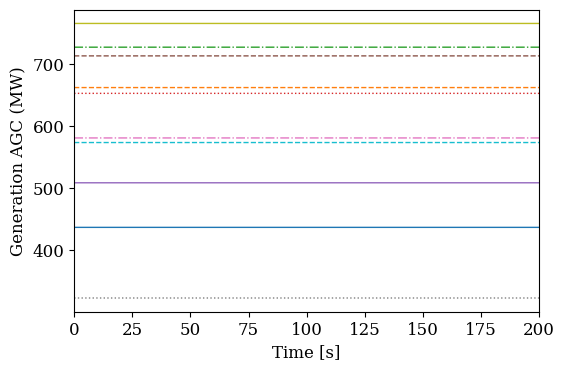

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [13]:
ss.TDS.plt.plot(ss.TGOV1N.pref, ytimes=100,ylabel='Generation AGC (MW)')

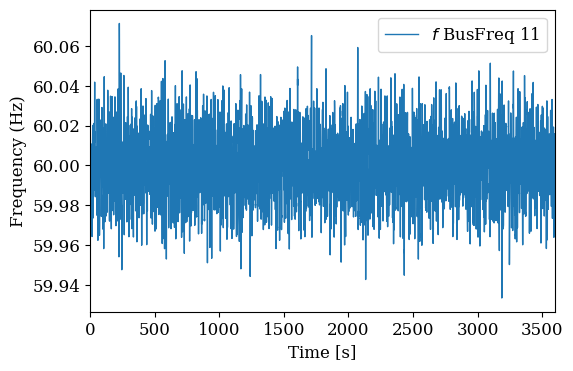

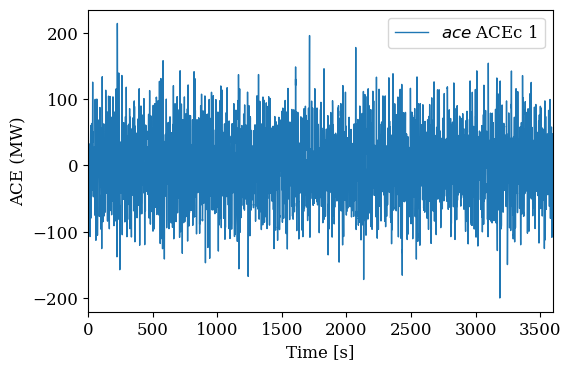

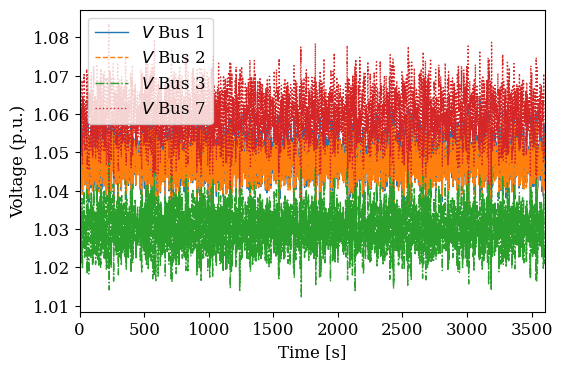

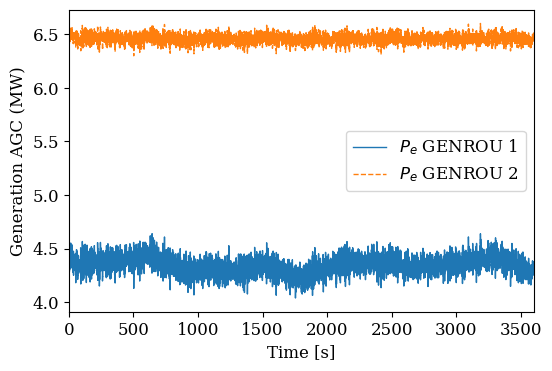

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [13]:
ss.TDS.load_plotter()
ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.GENROU.Pe, a=(0,1),ylabel='Generation AGC (MW)')

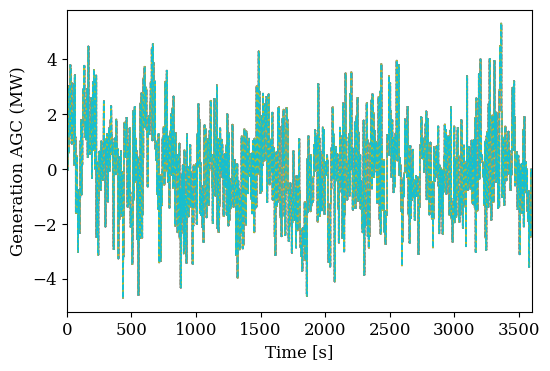

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [14]:
ss.TDS.plt.plot(ss.TGOV1N.paux, ytimes=100,ylabel='Generation AGC (MW)')

In [17]:
ss.TGOV1N.pref.v

array([0.        , 6.50799998, 7.29799998, 6.56799998, 5.12799998,
       6.91799997, 5.84799997, 5.68799996, 8.22757918, 7.32580681])

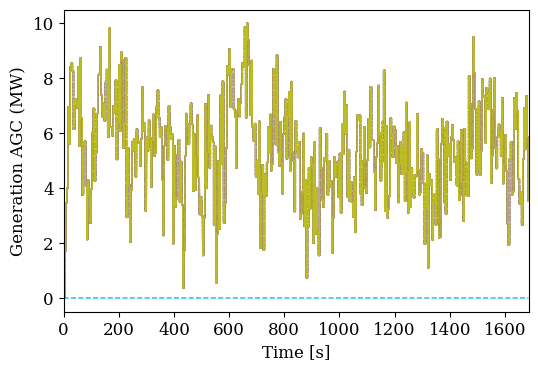

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [16]:
ss.TDS.plt.plot(ss.TGOV1N.paux, ytimes=100,ylabel='Generation AGC (MW)')

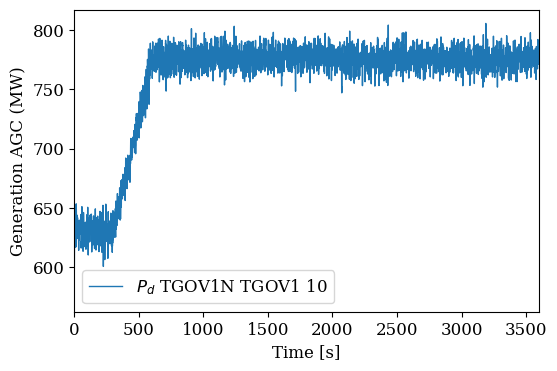

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [13]:
ss.TDS.plt.plot(ss.TGOV1N.pd, ytimes=100,a=(9),ylabel='Generation AGC (MW)')

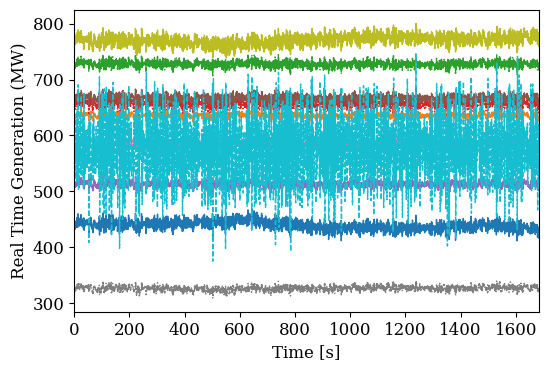

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Real Time Generation (MW)'>)

In [17]:
ss.TDS.plt.plot(ss.GENROU.Pe, ytimes=100,ylabel='Real Time Generation (MW)')

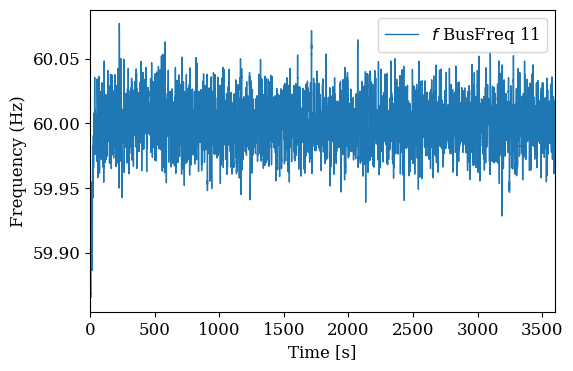

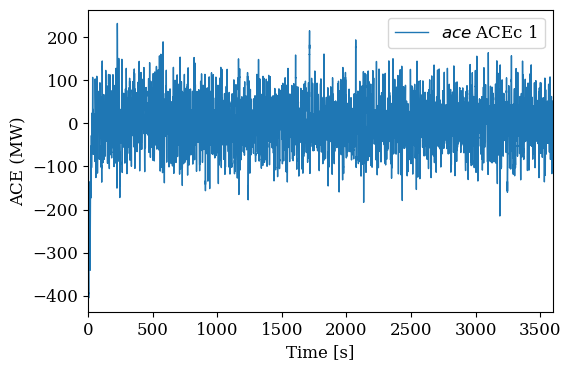

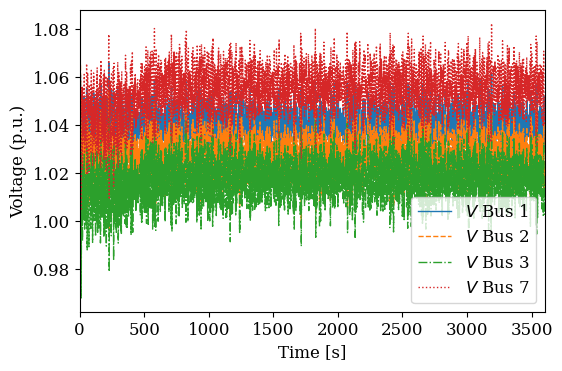

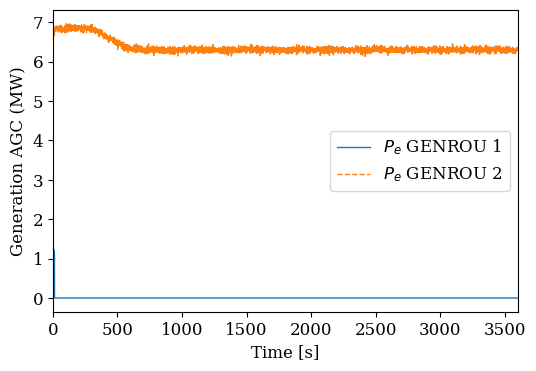

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [19]:
ss.TDS.load_plotter()

ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.GENROU.Pe, a=(0,1),ylabel='Generation AGC (MW)')

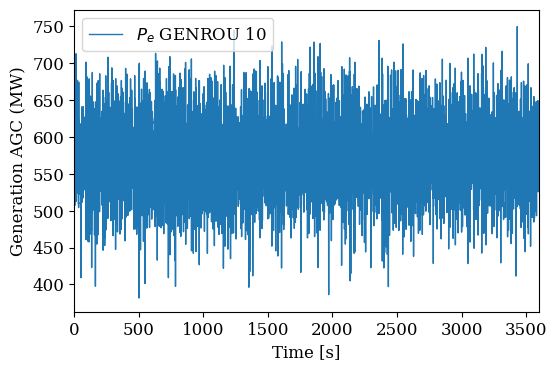

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [14]:
ss.TDS.plt.plot(ss.GENROU.Pe, ytimes=100,a=(9,),ylabel='Generation AGC (MW)')

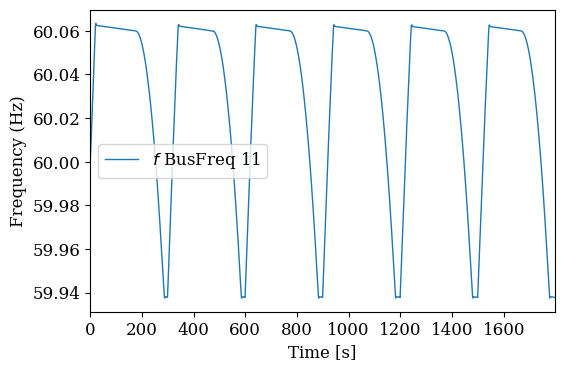

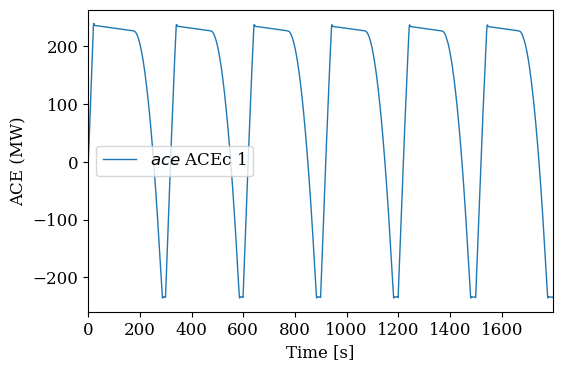

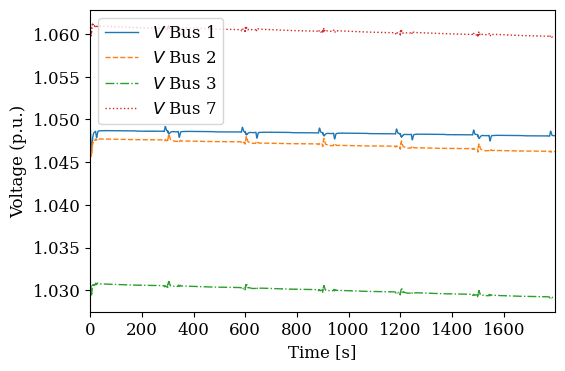

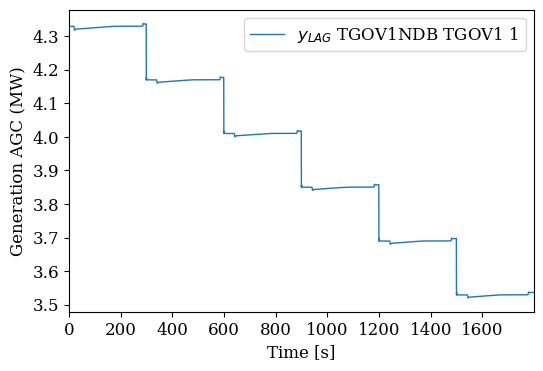

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [27]:
ss.TDS.load_plotter()

ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.TGOV1NDB.LAG_y, a=(0,),ylabel='Generation AGC (MW)')

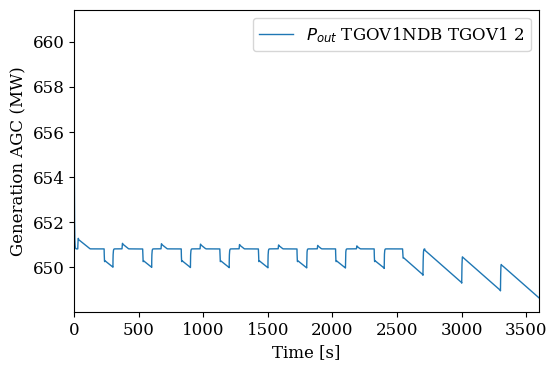

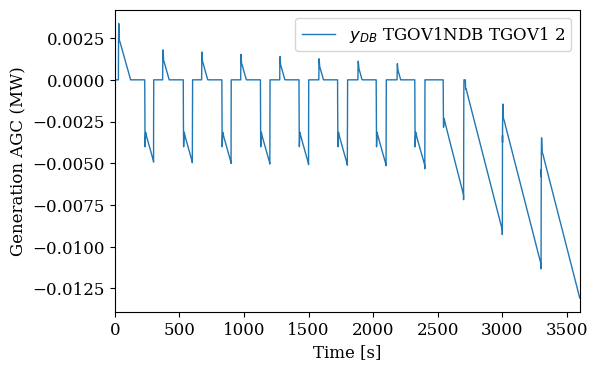

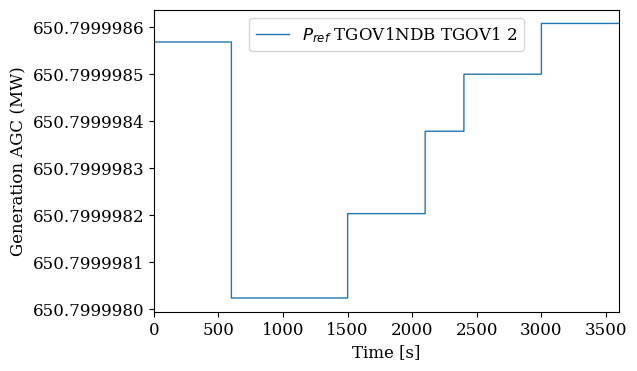

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [12]:
ss.TDS.plt.plot(ss.TGOV1NDB.pout,ytimes=100, a=(1,),ylabel='Generation AGC (MW)')
ss.TDS.plt.plot(ss.TGOV1NDB.DB_y,ytimes=100, a=(1,),ylabel='Generation AGC (MW)')
ss.TDS.plt.plot(ss.TGOV1NDB.pref,ytimes=100, a=(1,),ylabel='Generation AGC (MW)')

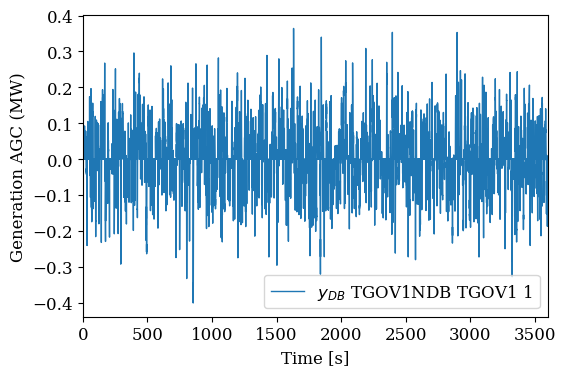

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [28]:
ss.TDS.plt.plot(ss.TGOV1NDB.DB_y, ytimes=100,a=(0,),ylabel='Generation AGC (MW)')

In [12]:
ss.TDS.plt.plot(ss.TGOV1NDB.LAG_y, a=(0,),ylabel='Generation AGC (MW)')

AttributeError: 'System' object has no attribute 'TGOV1NDB'

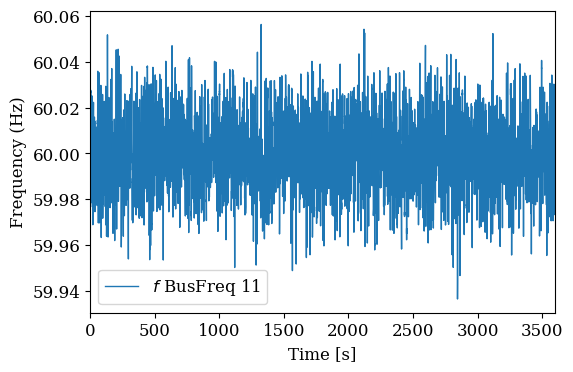

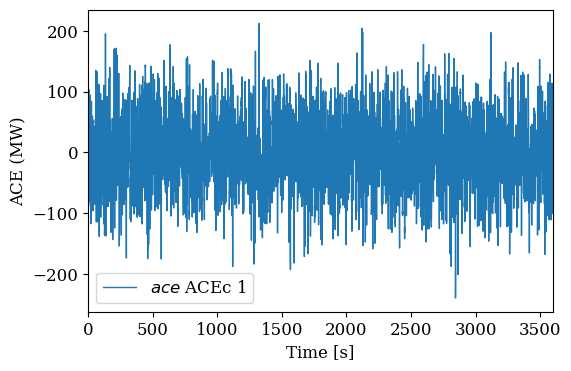

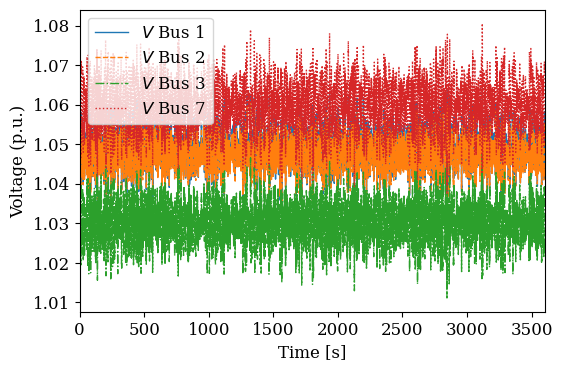

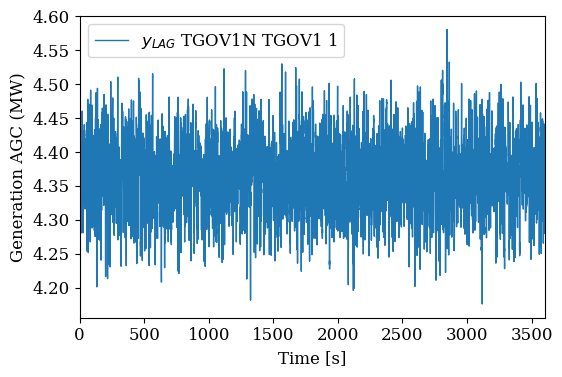

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [10]:
ss.TDS.load_plotter()

ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.TGOV1N.LAG_y, a=(0,),ylabel='Generation AGC (MW)')

In [12]:
net.load.p_mw=reference_load*1.01
pp.runopp(net, verbose=True, delta=1e-10)

gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.48 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    7367.0        -160.0 to 2807.0
Generators        10     On-line Capacity      7367.0        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5955.0            1612.9
Loads             19     Load                  5915.0            1734.5
  Fixed           19       Fixed               5915.0            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        39.99            994.55
Transformers  

In [13]:
new_gen = np.zeros(10)
for i in range(9):
    new_gen[i]=(net.res_gen.p_mw[i]+4.7)/100
new_gen[9]=(net.res_ext_grid.p_mw[0]+4.7)/100  

In [15]:
new_gen

array([4.36086412, 6.45999999, 7.24999999, 6.51999999, 5.07999999,
       6.86999999, 5.79999999, 3.21521333, 7.64783373, 5.74170577])

In [14]:
#set new load
Ppf = np.array(ss.PQ.Ppf.v)
shed_buses = np.array(ss.PQ.bus.v)
pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
pq_p = ss.PQ.get(src='Ppf', idx=pq_shed_idx, attr='v')

pq_p_new = pq_p*1.01

ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)

True

In [17]:
pq_p

array([6.   , 4.5  , 2.338, 5.22 , 1.2  , 3.2  , 3.29 , 1.58 , 6.8  ,
       2.74 , 2.475, 3.086, 2.24 , 1.39 , 2.81 , 2.06 , 2.835, 0.8  ,
       4.   ])

In [15]:
#set new generation set point
tg_names = ss.TGOV1N.idx.v
tg_idx = ss.TGOV1N.find_idx(keys='idx', values=tg_names)
ss.TurbineGov.set(src='pref0',idx=tg_idx, attr='v', value=new_gen)

True

In [26]:
sum(ss.TGOV1N.pref0.v)

59.42582846570426

In [27]:
sum(new_gen)

58.94561691403038

In [16]:
ss.TDS.config.tf = 40

ss.TDS.run()

100%|██████████████████████████████| 100.0/100 [00:02<00:00, 40.71%/s]

Simulation completed in 2.4567 seconds.
Outputs to "ieee39_out.lst" and "ieee39_out.npz".
Outputs written in 0.1217 seconds.


True

In [17]:
net.load.p_mw=reference_load*0.99
pp.runopp(net, verbose=True, delta=1e-10)

gen vm_pu > bus max_vm_pu for gens [6]. Setting bus limit for these gens.


PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.53 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    7367.0        -160.0 to 2807.0
Generators        10     On-line Capacity      7367.0        -160.0 to 2807.0
Committed Gens    10     Generation (actual)   5894.0            1591.9
Loads             19     Load                  5855.8            1734.5
  Fixed           19       Fixed               5855.8            1734.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)        38.15            974.39
Transformers  

In [18]:
new_gen = np.zeros(10)
for i in range(9):
    new_gen[i]=(net.res_gen.p_mw[i]+4.7)/100
new_gen[9]=(net.res_ext_grid.p_mw[0]+4.7)/100  

#set new load
Ppf = np.array(ss.PQ.Ppf.v)
shed_buses = np.array(ss.PQ.bus.v)
pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
pq_p = ss.PQ.get(src='Ppf', idx=pq_shed_idx, attr='v')

pq_p_new = pq_p*0.99

ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)

ss.TurbineGov.set(src='pref0',idx=tg_idx, attr='v', value=new_gen)

True

In [19]:
ss.TDS.config.tf = 60

ss.TDS.run()

100%|██████████████████████████████| 100.0/100 [00:02<00:00, 46.80%/s]

Simulation completed in 2.1368 seconds.


Outputs to "ieee39_out.lst" and "ieee39_out.npz".
Outputs written in 0.2094 seconds.


True

In [19]:
ss.ACEc.ace.v

array([0.00229565])

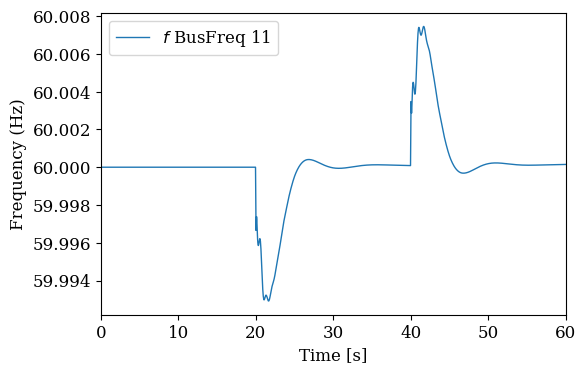

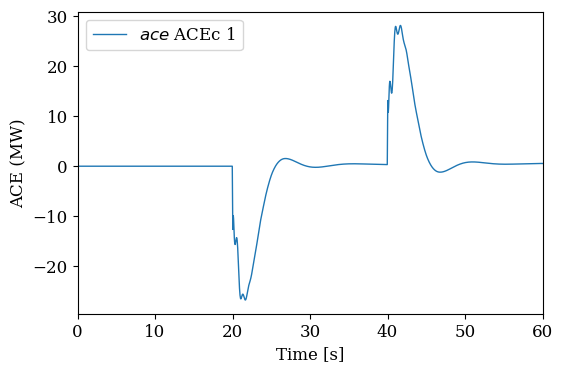

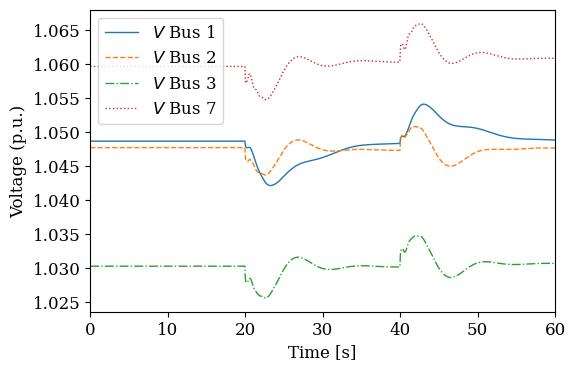

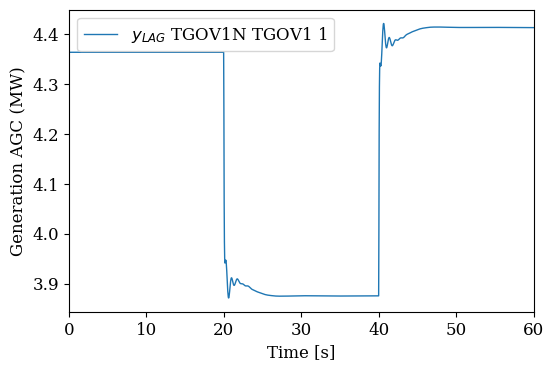

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [20]:
ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.TGOV1N.LAG_y, a=(0,),ylabel='Generation AGC (MW)')

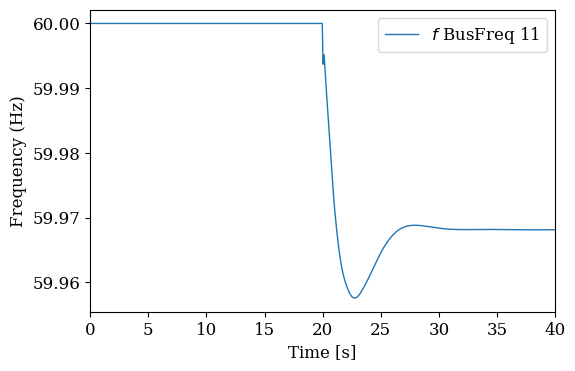

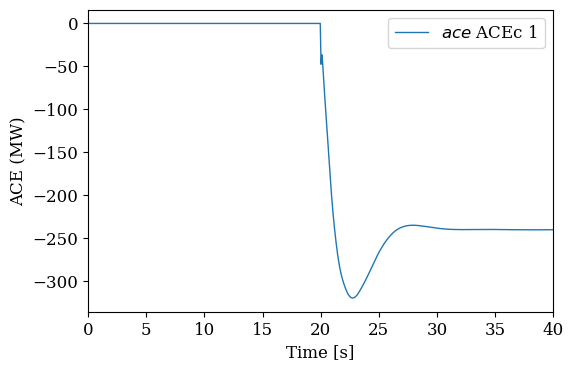

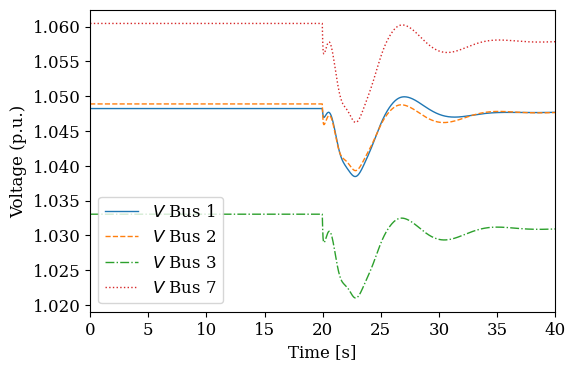

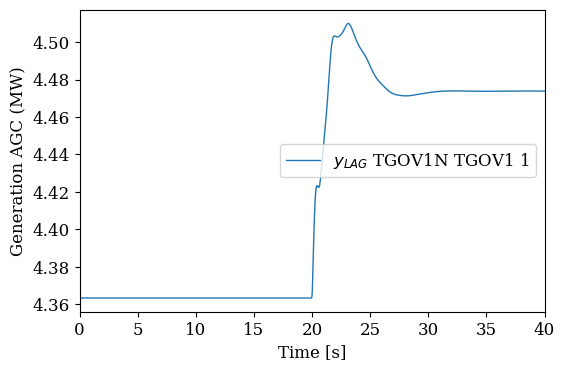

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Generation AGC (MW)'>)

In [20]:
ss.TDS.plt.plot(ss.ACEc.f,ytimes=60,ylabel='Frequency (Hz)')
ss.TDS.plt.plot(ss.ACEc.ace,ytimes=100,ylabel='ACE (MW)')
ss.TDS.plt.plot(ss.Bus.v, a=(0,1,2,6),ylabel='Voltage (p.u.)') 
ss.TDS.plt.plot(ss.TGOV1N.LAG_y, a=(0,),ylabel='Generation AGC (MW)')